# Hypothesis 3.1

If there are systematic differences in feature measurements across dataset, then the dataset identity will predict feature values.

In [1]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_setup.ipynb

## Setup

In [2]:
## Setup
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [3]:
#project directory
project_dir = Path('/data/NNDSP')
# NNDSP data directories
nndsp_project_dir = Path('/data/NNDSP')
nndsp_bids_dir = nndsp_project_dir.joinpath('bids_2017_07_14_generic')
nndsp_fs_dir = nndsp_project_dir.joinpath('derivatives/fs5.3_subj')
nndsp_bar_dir = nndsp_project_dir.joinpath('derivatives/bar_subj')
nndsp_mriqc_dir = nndsp_project_dir.joinpath('derivatives/mriqc_2018_06_08')
nndsp_pheno_file = nndsp_project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# HCP data directories
hcp_project_dir = Path('/data/HCP_preproc')
hcp_bids_dir = hcp_project_dir.joinpath('bids_hcp_1200')
hcp_fs_dir = nndsp_project_dir.joinpath('derivatives/fs_hcp_subj')
hcp_bar_dir = nndsp_project_dir.joinpath('derivatives/bar_hcp_subj')
hcp_mriqc_dir = hcp_project_dir.joinpath('mriqc_hcp_2018_07_22')
hcp_pheno_file = nndsp_project_dir.joinpath('nino/HCP_ages.csv')
hcp_pheno2_file = nndsp_project_dir.joinpath('anal/analysis_notebooks/phenotype_files/hcp_unrestricted.csv')

# NKI data directories
nki_project_dir = nndsp_project_dir
nki_bids_dir = nki_project_dir.joinpath('anal/NKI')
nki_fs_dir = nki_project_dir.joinpath('derivatives/fs_nki_subj')
nki_bar_dir = nki_project_dir.joinpath('derivatives/bar_nki_subj')
nki_mriqc_dir = nki_project_dir.joinpath('derivatives/mriqc_nki_2018_07_16')
nki_pheno_file = nki_project_dir.joinpath('anal/analysis_notebooks/phenotype_files/participants.tsv')

# CoRR data directories
corr_project_dir = Path('/data/DSST/CoRR')
corr_bids_dir = corr_project_dir.joinpath('bids_corr')
corr_fs_dir = corr_project_dir.joinpath('derivatives/fs_corr')
corr_bar_dir = corr_project_dir.joinpath('derivatives/bar_corr/baracus')
corr_mriqc_dir = corr_project_dir.joinpath('derivatives/mriqc_corr')
corr_pheno_file = corr_project_dir.joinpath('phenotype_files/corr_ages.csv')

# SALD data directories
sald_project_dir = Path('/data/DSST/SALD')
sald_bids_dir = sald_project_dir.joinpath('bids_sald')
sald_fs_dir = sald_project_dir.joinpath('derivatives/fs_sald')
sald_bar_dir = sald_project_dir.joinpath('derivatives/bar_sald/baracus')
sald_mriqc_dir = sald_project_dir.joinpath('derivatives/mriqc_sald')
sald_pheno_file = sald_project_dir.joinpath('phenotype_files/sub_information.xlsx')

In [4]:
dataset_mapping = {
    'nndsp': 3,
    'hcp': 4,
    'nki': 5,
    'corr': 6,
    'sald': 7
}

In [5]:
dataclass_mapping = {
    '3': 'nndsp',
    '4': 'hcp',
    '5': 'nki',
    '6': 'corr',
    '7': 'sald'
}

## Get Features

### Complex Features

In [6]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_models.ipynb

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
df_nndsp = nndsp_subjectdata(nndsp_fs_dir, nndsp_pheno_file)
df_hcp = hcp_subjectdata(hcp_fs_dir, hcp_pheno_file, hcp_pheno2_file)
df_nki = nki_subjectdata(nki_fs_dir, nki_pheno_file)
df_corr = corr_subjectdata(corr_fs_dir, corr_pheno_file)
df_sald = sald_subjectdata(sald_fs_dir, sald_pheno_file)

In [8]:
print("Features for NNDSP")
x, nndsp_cfeatures = subject_features([os.path.basename(s) for s in df_nndsp.subj_paths], nndsp_bar_dir)
print("Features for HCP")
x, hcp_cfeatures = subject_features([os.path.basename(s) for s in df_hcp.subj_paths], hcp_bar_dir)
print("Features for NKI")
x, nki_cfeatures = subject_features([os.path.basename(s) for s in df_nki.subj_paths], nki_bar_dir)
print("Features for CoRR")
x, corr_cfeatures = subject_features([os.path.basename(s) for s in df_corr.subj_paths], corr_bar_dir, session='_ses-1')
print("Features for SALD")
x, sald_cfeatures = subject_features([os.path.basename(s) for s in df_sald.subj_paths], sald_bar_dir)

Features for NNDSP
Features for HCP
Features for NKI
Features for CoRR
Features for SALD


In [9]:
cfeatures = [[df_nndsp, nndsp_cfeatures, True, 'nndsp'], 
             [df_hcp, hcp_cfeatures, True, 'hcp'], 
             [df_nki, nki_cfeatures, False, 'nki'],
             [df_corr, corr_cfeatures, True, 'corr'],
             [df_sald, sald_cfeatures, True, 'sald']]
sources = ['thickness', 'aseg', 'area']

df_total = pd.DataFrame([])
for data in cfeatures:
    df_source = pd.DataFrame(data[0].subject.values, columns=['subject'])
    for source in sources:
        df_target = data[0][['subject', 'age']]
        df_target = df_target.sort_values(by='subject')
        df = get_source_data(source, data[1], df_target, is_int = data[2]) # extract thickness info from features
        df = df.sort_values(by='subject')
        new_cols = [(source+str(col)) if col != 'subject' and col !='age' else col for col in df.columns]
        df.columns = new_cols
        df_source = pd.merge(df_source, df, on='subject')
    df_source['data_class'] = [dataset_mapping[data[3]] for x in range(len(df_source))]
    df_total = pd.concat([df_total, df_source], join='outer', sort=False)    

### Simple Features

In [10]:
print("Features for NNDSP")
nndsp_sfeatures = anat_features(df_nndsp, nndsp_bar_dir)
print("Features for HCP")
hcp_sfeatures = anat_features(df_hcp, hcp_bar_dir)
print("Features for NKI")
nki_sfeatures = anat_features(df_nki, nki_bar_dir, is_int = False)
print("Features for CoRR")
corr_sfeatures = anat_features(df_corr, corr_bar_dir, session='_ses-1')
print("Features for SALD")
sald_sfeatures = anat_features(df_sald, sald_bar_dir)

Features for NNDSP
Finding Subjects
Extracting Features
431
Features for HCP
Finding Subjects
Extracting Features
895
Features for NKI
Finding Subjects
Extracting Features
808
Features for CoRR
Finding Subjects
Extracting Features
1467
Features for SALD
Finding Subjects
Extracting Features
195


In [11]:
sfeatures = [[nndsp_sfeatures, 'nndsp'], 
             [hcp_sfeatures, 'hcp'], 
             [nki_sfeatures, 'nki'], 
             [corr_sfeatures, 'corr'], 
             [sald_sfeatures, 'sald']]

df_stotal = pd.DataFrame([])
for features in sfeatures:
    df = features[0][['subject', 'sex', 'Intra_Cran_Vol', 'WM_Frac', 'GM_Frac', 'CSF_Frac']]
    #df['data_class'] = [dataset_mapping[features[1]] for c in range(len(df))]
    df_stotal = pd.concat([df_stotal, df], join='outer', sort=False)

In [12]:
df_total = pd.merge(df_total, df_stotal, on='subject')

## Build Models

In [13]:
df_total.head()

,subject,thickness0,thickness1,thickness2,thickness3,thickness4,thickness5,thickness6,thickness7,thickness8,...,area5121,area5122,area5123,age,data_class,sex,Intra_Cran_Vol,WM_Frac,GM_Frac,CSF_Frac
0,102,3.305366,3.226945,2.209841,3.212811,2.919251,2.354458,2.736327,0.000000,3.154292,...,43.361240,28.880585,38.174156,28.542094,3,2,1.581414e+06,0.325566,0.039989,0.010659
1,114,3.079595,2.001180,2.031072,2.632975,2.426262,3.073457,2.639206,0.101857,2.694606,...,63.092190,60.416424,57.409924,25.957563,3,2,1.607836e+06,0.334801,0.041092,0.012042
2,126,2.900267,2.444894,2.336694,3.010283,3.012766,3.304097,1.675746,0.066457,2.338948,...,79.327354,46.815220,42.953053,6.015058,3,2,1.373947e+06,0.295549,0.041849,0.007700
3,127,3.167699,3.679227,1.833072,3.248728,3.608622,3.156340,2.562178,1.326940,3.019244,...,56.245037,56.724739,55.235676,7.926078,3,2,1.497001e+06,0.289696,0.039456,0.008569
4,133,3.277886,3.069667,2.171888,2.266851,2.950705,3.218155,2.977520,0.084246,2.545784,...,51.345055,52.372635,56.715862,22.168378,3,1,1.435193e+06,0.302876,0.040307,0.014680


In [14]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.anova import anova_lm
from sklearn import linear_model
from scipy.stats import f

### Features

In [39]:
features = [col if col not in ['subject', 'age', 'data_class', 'sex', 'age_x', 'age_y'] else None for col in df_total.columns]

In [40]:
features.remove(None)
features.remove(None)
features.remove(None)
features.remove(None)
features.remove(None)
features.remove(None)

In [41]:
len(features)

10318

In [62]:
p_vals = []
f_vals = []
X=pd.DataFrame([])
X['female'] = [1 if s==1 else 0 for s in df_total.sex]
X['male'] = [1 if s==2 else 0 for s in df_total.sex]
X['nndsp'] = [1 if c==3 else 0 for c in df_total.data_class]
X['hcp'] = [1 if c==4 else 0 for c in df_total.data_class]
X['nki'] = [1 if c==5 else 0 for c in df_total.data_class]
X['corr'] = [1 if c==6 else 0 for c in df_total.data_class]
X['sald'] = [1 if c==7 else 0 for c in df_total.data_class]
X_res = X[['female', 'male']]
X_norm = X
X_res_norm = X_res

for feature in features:
    from scipy.stats import f
    y = df_total[feature]
    X = pd.DataFrame([])
    
#     X_norm = (X-X.min())/(X.max()-X.min())
#     X_res_norm = (X_res-X_res.min())/(X_res.max()-X_res.min())
    
    
    lm_full = linear_model.LinearRegression().fit(X_norm, y)
    rss_f = np.mean((lm_full.predict(X_norm) - y) ** 2)

    lm_res = linear_model.LinearRegression().fit(X_res, y)
    rss_r = np.mean((lm_res.predict(X_res_norm) - y) ** 2)
    
    df_f = (len(X_norm) - 1) - (X_norm.shape[1] - 1)
    df_r = (len(X_res_norm) - 1) - (X_res_norm.shape[1] - 1)
    
    F = ((rss_r - rss_f)/(df_r - df_f))/(rss_f/df_f)
    f_vals.append(F)
    p_val = f.sf(F, df_r - df_f, df_f)
    p_vals.append(p_val)
    
    print("Model Comparison for", feature)
    print(F, p_val, f.ppf(q=1-0.1, dfn=(df_r-df_f), dfd=df_f))

Model Comparison for thickness0
67.96646633325841 3.1634661624642547e-68 1.8487921998112444
Model Comparison for thickness1
4.824719585372437 0.00021173848891693843 1.8487921998112444
Model Comparison for thickness2
41.41587082930247 1.2306014566116833e-41 1.8487921998112444
Model Comparison for thickness3
6.209978522092606 9.64556344865208e-06 1.8487921998112444
Model Comparison for thickness4
8.657049293077055 3.598256723367848e-08 1.8487921998112444
Model Comparison for thickness5
27.26312717546629 3.4121186409464764e-27 1.8487921998112444
Model Comparison for thickness6
30.158538374465845 3.686100381968196e-30 1.8487921998112444
Model Comparison for thickness7
255.15626523110126 1.319772045352815e-235 1.8487921998112444
Model Comparison for thickness8
15.178230413676298 8.569805157536694e-15 1.8487921998112444
Model Comparison for thickness9
26.994301656706853 6.436831668625198e-27 1.8487921998112444
Model Comparison for thickness10
30.85370659082696 7.1628185816833825e-31 1.848792

Model Comparison for thickness100
35.019654715046464 3.966726370169835e-35 1.8487921998112444
Model Comparison for thickness101
21.768001297946604 1.4882319897774955e-21 1.8487921998112444
Model Comparison for thickness102
23.707720833326597 1.517100612613042e-23 1.8487921998112444
Model Comparison for thickness103
14.489751161830622 4.3378081679242004e-14 1.8487921998112444
Model Comparison for thickness104
33.17523133201747 3.0300226397621836e-33 1.8487921998112444
Model Comparison for thickness105
57.75851172473252 4.337462341054082e-58 1.8487921998112444
Model Comparison for thickness106
39.50285484417586 1.0787791814275594e-39 1.8487921998112444
Model Comparison for thickness107
30.399570238722536 2.088542731057453e-30 1.8487921998112444
Model Comparison for thickness108
6.8243920398720785 2.3999951995551098e-06 1.8487921998112444
Model Comparison for thickness109
10.969467900941751 1.6732758513274287e-10 1.8487921998112444
Model Comparison for thickness110
3.9175901568405767 0.00

Model Comparison for thickness216
38.679771148950515 7.410407040103545e-39 1.8487921998112444
Model Comparison for thickness217
28.76593879788545 9.83442110656204e-29 1.8487921998112444
Model Comparison for thickness218
28.316138525193004 2.8420794589629725e-28 1.8487921998112444
Model Comparison for thickness219
73.2821712700652 1.8421049209321757e-73 1.8487921998112444
Model Comparison for thickness220
5.506149749712949 4.67776527661058e-05 1.8487921998112444
Model Comparison for thickness221
8.921793197465785 1.9519692291314575e-08 1.8487921998112444
Model Comparison for thickness222
18.377292516352195 4.5062277660172605e-18 1.8487921998112444
Model Comparison for thickness223
21.4113413874146 3.4587240747107734e-21 1.8487921998112444
Model Comparison for thickness224
177.17484401495759 7.02488426716185e-170 1.8487921998112444
Model Comparison for thickness225
7.97417100162958 1.7339436223462923e-07 1.8487921998112444
Model Comparison for thickness226
2.5031129620245745 0.0285444354

Model Comparison for thickness331
40.48234473964411 1.0908691935416408e-40 1.8487921998112444
Model Comparison for thickness332
18.112777760227885 8.41853185136245e-18 1.8487921998112444
Model Comparison for thickness333
18.53729821199442 3.0875355898953847e-18 1.8487921998112444
Model Comparison for thickness334
9.566584969331801 4.3835221684994606e-09 1.8487921998112444
Model Comparison for thickness335
43.06791812424068 2.6003428938028404e-43 1.8487921998112444
Model Comparison for thickness336
18.367158743828774 4.615430564950147e-18 1.8487921998112444
Model Comparison for thickness337
10.439415545982968 5.759909534887852e-10 1.8487921998112444
Model Comparison for thickness338
8.49865074028182 5.1855872122096143e-08 1.8487921998112444
Model Comparison for thickness339
55.10467644050438 1.9525580617231667e-55 1.8487921998112444
Model Comparison for thickness340
6.601014070207821 3.984474797338582e-06 1.8487921998112444
Model Comparison for thickness341
47.7939083595088 4.3396861655

10.106998646458855 1.248849444156488e-09 1.8487921998112444
Model Comparison for thickness419
28.242653287760618 3.3802074143252486e-28 1.8487921998112444
Model Comparison for thickness420
45.06019999805859 2.50251970626374e-45 1.8487921998112444
Model Comparison for thickness421
18.754650092486663 1.8473223498231366e-18 1.8487921998112444
Model Comparison for thickness422
71.42381876469618 1.2358334126929802e-71 1.8487921998112444
Model Comparison for thickness423
63.202670876459045 1.6486918803956214e-63 1.8487921998112444
Model Comparison for thickness424
4.735591861733449 0.000257550000450686 1.8487921998112444
Model Comparison for thickness425
179.65606711892133 4.713965480730252e-172 1.8487921998112444
Model Comparison for thickness426
202.10865535671232 1.8238422764515583e-191 1.8487921998112444
Model Comparison for thickness427
366.44639856758295 3.33e-321 1.8487921998112444
Model Comparison for thickness428
250.87006432399934 3.99101933167018e-232 1.8487921998112444
Model Comp

Model Comparison for thickness524
11.412894704400811 5.938325713369779e-11 1.8487921998112444
Model Comparison for thickness525
29.036708946435546 5.192294119149294e-29 1.8487921998112444
Model Comparison for thickness526
60.03212462177587 2.3435555884398248e-60 1.8487921998112444
Model Comparison for thickness527
63.5275945644019 7.845888337574445e-64 1.8487921998112444
Model Comparison for thickness528
21.62481570255824 2.0878737820022285e-21 1.8487921998112444
Model Comparison for thickness529
71.0461797973473 2.908091526120737e-71 1.8487921998112444
Model Comparison for thickness530
7.348644523832573 7.267949356838784e-07 1.8487921998112444
Model Comparison for thickness531
170.4765458043097 5.520047601366636e-164 1.8487921998112444
Model Comparison for thickness532
40.069010550601284 2.868234945183198e-40 1.8487921998112444
Model Comparison for thickness533
6.520608800961539 4.78053022667831e-06 1.8487921998112444
Model Comparison for thickness534
11.676670087413848 3.204249950165

Model Comparison for thickness619
22.580316145860873 2.1804532125219225e-22 1.8487921998112444
Model Comparison for thickness620
17.126026810049865 8.657632093673873e-17 1.8487921998112444
Model Comparison for thickness621
25.162392215136574 4.874304921933398e-25 1.8487921998112444
Model Comparison for thickness622
32.53814181236477 1.3566194288951567e-32 1.8487921998112444
Model Comparison for thickness623
7.769625567132593 2.772787616837323e-07 1.8487921998112444
Model Comparison for thickness624
13.06705682589348 1.230726340596331e-12 1.8487921998112444
Model Comparison for thickness625
44.11275529541062 2.2747899225539e-44 1.8487921998112444
Model Comparison for thickness626
19.438586074574566 3.6685823109935553e-19 1.8487921998112444
Model Comparison for thickness627
0.4938746621451091 0.7810743494547758 1.8487921998112444
Model Comparison for thickness628
0.46197772985161367 0.8047824920658894 1.8487921998112444
Model Comparison for thickness629
5.171366028333931 9.84786165490481

Model Comparison for thickness707
136.08611696506836 4.79538464692424e-133 1.8487921998112444
Model Comparison for thickness708
88.4569095342342 3.0763929159612547e-88 1.8487921998112444
Model Comparison for thickness709
11.149134380747611 1.0999142667230712e-10 1.8487921998112444
Model Comparison for thickness710
98.7298283986021 4.205041740244633e-98 1.8487921998112444
Model Comparison for thickness711
21.02106756472172 8.70314949562316e-21 1.8487921998112444
Model Comparison for thickness712
5.832257339713854 2.255596596312689e-05 1.8487921998112444
Model Comparison for thickness713
8.17333158613979 1.0969950507689283e-07 1.8487921998112444
Model Comparison for thickness714
89.81805175055626 1.4948395426313186e-89 1.8487921998112444
Model Comparison for thickness715
34.06324223992051 3.754312756066463e-34 1.8487921998112444
Model Comparison for thickness716
101.33912442414072 1.3679491661139074e-100 1.8487921998112444
Model Comparison for thickness717
13.510685818756794 4.3403905473

Model Comparison for thickness821
33.11984615659783 3.451672896998438e-33 1.8487921998112444
Model Comparison for thickness822
10.539131632207036 4.5656804386686615e-10 1.8487921998112444
Model Comparison for thickness823
18.79221651403802 1.6903867247563755e-18 1.8487921998112444
Model Comparison for thickness824
25.80899221505876 1.057916580696205e-25 1.8487921998112444
Model Comparison for thickness825
6.018925194481713 1.4831717341768428e-05 1.8487921998112444
Model Comparison for thickness826
42.67864989872591 6.4490981299531674e-43 1.8487921998112444
Model Comparison for thickness827
41.08858910600547 2.64400535970923e-41 1.8487921998112444
Model Comparison for thickness828
46.13884397507953 2.032949571961203e-46 1.8487921998112444
Model Comparison for thickness829
27.095485387079325 5.068931748113114e-27 1.8487921998112444
Model Comparison for thickness830
35.08890108842795 3.3712300080010785e-35 1.8487921998112444
Model Comparison for thickness831
27.64220021690927 1.3944097708

13.619549303977415 3.360429055066696e-13 1.8487921998112444
Model Comparison for thickness924
23.223117275321943 4.77024149133536e-23 1.8487921998112444
Model Comparison for thickness925
20.00623825756517 9.587612659508249e-20 1.8487921998112444
Model Comparison for thickness926
10.641168700005744 3.599192044988038e-10 1.8487921998112444
Model Comparison for thickness927
28.93647672404166 6.577137727244938e-29 1.8487921998112444
Model Comparison for thickness928
17.19562692600582 7.345610685007673e-17 1.8487921998112444
Model Comparison for thickness929
30.36060521120015 2.28942302290149e-30 1.8487921998112444
Model Comparison for thickness930
22.80738913272065 1.274644041345007e-22 1.8487921998112444
Model Comparison for thickness931
11.430049014435106 5.7048703673721704e-11 1.8487921998112444
Model Comparison for thickness932
10.232843454251544 9.318141286772215e-10 1.8487921998112444
Model Comparison for thickness933
11.834201219302527 2.2161888264526177e-11 1.8487921998112444
Model

Model Comparison for thickness1039
9.340502285416207 7.404931928820255e-09 1.8487921998112444
Model Comparison for thickness1040
4.397567325925758 0.0005391878188592737 1.8487921998112444
Model Comparison for thickness1041
8.176081763845193 1.0900764316080893e-07 1.8487921998112444
Model Comparison for thickness1042
6.3360563362811915 7.256782812674792e-06 1.8487921998112444
Model Comparison for thickness1043
7.827401615327238 2.4286362819344006e-07 1.8487921998112444
Model Comparison for thickness1044
4.739817175498619 0.00025517203960037974 1.8487921998112444
Model Comparison for thickness1045
13.35242969915654 6.295695695627428e-13 1.8487921998112444
Model Comparison for thickness1046
3.310350546608824 0.005500938375248747 1.8487921998112444
Model Comparison for thickness1047
5.221141348001175 8.818704191339548e-05 1.8487921998112444
Model Comparison for thickness1048
10.25453565426517 8.859307489661752e-10 1.8487921998112444
Model Comparison for thickness1049
3.992410177463735 0.00

Model Comparison for thickness1127
69.0025949225793 3.0020801050483925e-69 1.8487921998112444
Model Comparison for thickness1128
25.407485068317733 2.73155833028004e-25 1.8487921998112444
Model Comparison for thickness1129
19.887382514034556 1.2698185598509733e-19 1.8487921998112444
Model Comparison for thickness1130
20.03964297658727 8.859572525149e-20 1.8487921998112444
Model Comparison for thickness1131
21.16440414188641 6.201390555945992e-21 1.8487921998112444
Model Comparison for thickness1132
16.85244859729278 1.6515934642345382e-16 1.8487921998112444
Model Comparison for thickness1133
34.9574156817083 4.5912461914377265e-35 1.8487921998112444
Model Comparison for thickness1134
13.674101155225516 2.955945698128473e-13 1.8487921998112444
Model Comparison for thickness1135
19.571598447462733 2.6788392738833506e-19 1.8487921998112444
Model Comparison for thickness1136
31.752682173806594 8.619514561427409e-32 1.8487921998112444
Model Comparison for thickness1137
45.24153770228589 1.6

Model Comparison for thickness1220
37.55391339985905 1.0364907362513468e-37 1.8487921998112444
Model Comparison for thickness1221
85.12857587121735 5.106020168435673e-85 1.8487921998112444
Model Comparison for thickness1222
43.62310158760189 7.123230073729137e-44 1.8487921998112444
Model Comparison for thickness1223
31.671346443333423 1.0439076566734684e-31 1.8487921998112444
Model Comparison for thickness1224
20.947431026720338 1.035835481745066e-20 1.8487921998112444
Model Comparison for thickness1225
45.49123833365229 9.174150850318756e-46 1.8487921998112444
Model Comparison for thickness1226
91.79400348737457 1.8680785172234527e-91 1.8487921998112444
Model Comparison for thickness1227
16.239703682244073 7.013437197322119e-16 1.8487921998112444
Model Comparison for thickness1228
16.915558096787457 1.4229879552555946e-16 1.8487921998112444
Model Comparison for thickness1229
20.691955911530993 1.8950661632148228e-20 1.8487921998112444
Model Comparison for thickness1230
82.031354623299

Model Comparison for thickness1313
7.314976332778952 7.848957167354025e-07 1.8487921998112444
Model Comparison for thickness1314
11.391507939895174 6.242786368518e-11 1.8487921998112444
Model Comparison for thickness1315
7.976195491541493 1.7258990059898175e-07 1.8487921998112444
Model Comparison for thickness1316
31.762236090098416 8.42776938464135e-32 1.8487921998112444
Model Comparison for thickness1317
9.01540582662873 1.5719812308680055e-08 1.8487921998112444
Model Comparison for thickness1318
12.29053229732234 7.609795467939568e-12 1.8487921998112444
Model Comparison for thickness1319
12.746732001413658 2.6104811586967454e-12 1.8487921998112444
Model Comparison for thickness1320
81.01611837894701 5.047824349200064e-81 1.8487921998112444
Model Comparison for thickness1321
27.741626614602662 1.1027277268051189e-27 1.8487921998112444
Model Comparison for thickness1322
73.29417797512501 1.7927698920994802e-73 1.8487921998112444
Model Comparison for thickness1323
60.25940668096967 1.3

Model Comparison for thickness1403
56.43384320073535 9.135983348335379e-57 1.8487921998112444
Model Comparison for thickness1404
14.685271601315879 2.7373273640727297e-14 1.8487921998112444
Model Comparison for thickness1405
26.57702501047933 1.7242711448635338e-26 1.8487921998112444
Model Comparison for thickness1406
18.255849993163757 6.003877501109348e-18 1.8487921998112444
Model Comparison for thickness1407
26.752740062864277 1.1386579332499699e-26 1.8487921998112444
Model Comparison for thickness1408
37.38769780713696 1.5304028970650361e-37 1.8487921998112444
Model Comparison for thickness1409
22.95702093930074 8.948523269274159e-23 1.8487921998112444
Model Comparison for thickness1410
10.973047967749764 1.6593498080535547e-10 1.8487921998112444
Model Comparison for thickness1411
5.946399182577595 1.7457902665149356e-05 1.8487921998112444
Model Comparison for thickness1412
21.221200950837368 5.42208278323269e-21 1.8487921998112444
Model Comparison for thickness1413
76.851926246812

9.095377125050383 1.306417688901138e-08 1.8487921998112444
Model Comparison for thickness1512
29.203894614965908 3.5003190876552155e-29 1.8487921998112444
Model Comparison for thickness1513
20.61468666939065 2.2749232066693524e-20 1.8487921998112444
Model Comparison for thickness1514
29.420539576368913 2.0999949271339205e-29 1.8487921998112444
Model Comparison for thickness1515
32.981953894914525 4.774367087511527e-33 1.8487921998112444
Model Comparison for thickness1516
31.853637228057217 6.7958827723813e-32 1.8487921998112444
Model Comparison for thickness1517
17.93637330481589 1.2771079278534764e-17 1.8487921998112444
Model Comparison for thickness1518
23.81298284025713 1.18291128989196e-23 1.8487921998112444
Model Comparison for thickness1519
23.97221643767428 8.118721482016812e-24 1.8487921998112444
Model Comparison for thickness1520
8.822236050774046 2.4570322551213706e-08 1.8487921998112444
Model Comparison for thickness1521
24.207558831559805 4.654829832095534e-24 1.84879219981

Model Comparison for thickness1606
12.536609064789078 4.273676022240765e-12 1.8487921998112444
Model Comparison for thickness1607
13.296403639088883 7.181435007436118e-13 1.8487921998112444
Model Comparison for thickness1608
8.718232639956057 3.124251272367914e-08 1.8487921998112444
Model Comparison for thickness1609
48.35089899414435 1.1907573500584865e-48 1.8487921998112444
Model Comparison for thickness1610
7.214338929210966 9.876050653174901e-07 1.8487921998112444
Model Comparison for thickness1611
30.813308777381557 7.8780966650652446e-31 1.8487921998112444
Model Comparison for thickness1612
29.524454949363335 1.6436042152063944e-29 1.8487921998112444
Model Comparison for thickness1613
25.55254919832025 1.9389341578647194e-25 1.8487921998112444
Model Comparison for thickness1614
14.996138723282868 1.3161689432938448e-14 1.8487921998112444
Model Comparison for thickness1615
11.855431934954913 2.1087326385285054e-11 1.8487921998112444
Model Comparison for thickness1616
10.3585929883

204.99879678012564 6.233643706025962e-194 1.8487921998112444
Model Comparison for thickness1713
96.71322445629177 3.558961044400309e-96 1.8487921998112444
Model Comparison for thickness1714
69.59643812338848 7.79416284210048e-70 1.8487921998112444
Model Comparison for thickness1715
20.637643684387527 2.1547349798442868e-20 1.8487921998112444
Model Comparison for thickness1716
15.784257306414691 2.0535371395978647e-15 1.8487921998112444
Model Comparison for thickness1717
36.409423513741075 1.518283721214526e-36 1.8487921998112444
Model Comparison for thickness1718
11.713120260000297 2.942279639319168e-11 1.8487921998112444
Model Comparison for thickness1719
6.23426790918988 9.131351864395181e-06 1.8487921998112444
Model Comparison for thickness1720
8.041105664008299 1.4867749148974763e-07 1.8487921998112444
Model Comparison for thickness1721
19.501704025200947 3.160104705611756e-19 1.8487921998112444
Model Comparison for thickness1722
13.26660004135458 7.702281306347083e-13 1.8487921998

Model Comparison for thickness1816
3.7183664441981557 0.002326827332343191 1.8487921998112444
Model Comparison for thickness1817
4.55476914418603 0.0003827055528072433 1.8487921998112444
Model Comparison for thickness1818
1.3357795149013616 0.24590075940737713 1.8487921998112444
Model Comparison for thickness1819
6.148517728513946 1.1078874460401837e-05 1.8487921998112444
Model Comparison for thickness1820
11.773729430611482 2.5531775995471114e-11 1.8487921998112444
Model Comparison for thickness1821
25.58019276525337 1.816349572727101e-25 1.8487921998112444
Model Comparison for thickness1822
17.159030630364256 8.008587223316248e-17 1.8487921998112444
Model Comparison for thickness1823
14.612154101259836 3.251659897784442e-14 1.8487921998112444
Model Comparison for thickness1824
9.746338430555747 2.8879994823025227e-09 1.8487921998112444
Model Comparison for thickness1825
8.64929864309956 3.663208948955346e-08 1.8487921998112444
Model Comparison for thickness1826
15.71321240754612 2.42

Model Comparison for thickness1920
8.745627808877858 2.9327164080245232e-08 1.8487921998112444
Model Comparison for thickness1921
11.640168628183977 3.4899311558760646e-11 1.8487921998112444
Model Comparison for thickness1922
22.082914024789545 7.068015361054616e-22 1.8487921998112444
Model Comparison for thickness1923
8.018295496042859 1.5667868607146552e-07 1.8487921998112444
Model Comparison for thickness1924
4.59647132490414 0.00034935465618584477 1.8487921998112444
Model Comparison for thickness1925
17.484138904624984 3.716526982911506e-17 1.8487921998112444
Model Comparison for thickness1926
11.80470344239222 2.3746242549202355e-11 1.8487921998112444
Model Comparison for thickness1927
15.95180977766577 1.3831921553460621e-15 1.8487921998112444
Model Comparison for thickness1928
30.391927683499908 2.1265021761937425e-30 1.8487921998112444
Model Comparison for thickness1929
27.652496811773208 1.3609279448748886e-27 1.8487921998112444
Model Comparison for thickness1930
26.8743457457

Model Comparison for thickness2025
28.63086070843949 1.352522892396146e-28 1.8487921998112444
Model Comparison for thickness2026
19.782907967473935 1.6255670242935652e-19 1.8487921998112444
Model Comparison for thickness2027
65.00801093425407 2.671158623258876e-65 1.8487921998112444
Model Comparison for thickness2028
31.69768760374089 9.811228222909034e-32 1.8487921998112444
Model Comparison for thickness2029
47.06181666434082 2.377500513160703e-47 1.8487921998112444
Model Comparison for thickness2030
35.7419833362899 7.27300983187233e-36 1.8487921998112444
Model Comparison for thickness2031
31.704119760029016 9.663743232097663e-32 1.8487921998112444
Model Comparison for thickness2032
18.642319240982562 2.4089673446714105e-18 1.8487921998112444
Model Comparison for thickness2033
27.87117092046658 8.122315766690732e-28 1.8487921998112444
Model Comparison for thickness2034
13.076357975236537 1.2041368974270208e-12 1.8487921998112444
Model Comparison for thickness2035
22.437039968411977 3

Model Comparison for thickness2117
10.78686466961415 2.562324906160079e-10 1.8487921998112444
Model Comparison for thickness2118
14.62367975974948 3.1645953130666913e-14 1.8487921998112444
Model Comparison for thickness2119
48.23259311068278 1.5670754924503128e-48 1.8487921998112444
Model Comparison for thickness2120
60.1947688290688 1.6139365878645866e-60 1.8487921998112444
Model Comparison for thickness2121
40.344549256990305 1.5056382657336181e-40 1.8487921998112444
Model Comparison for thickness2122
17.27777578026754 6.050399753664713e-17 1.8487921998112444
Model Comparison for thickness2123
14.45105363853493 4.7515614100034104e-14 1.8487921998112444
Model Comparison for thickness2124
71.34745741812758 1.4692563247189988e-71 1.8487921998112444
Model Comparison for thickness2125
83.16969569903155 4.062240068738383e-83 1.8487921998112444
Model Comparison for thickness2126
43.752401090142975 5.26925663348618e-44 1.8487921998112444
Model Comparison for thickness2127
74.55037561264557 1

Model Comparison for thickness2212
13.795545769377894 2.2216693347047833e-13 1.8487921998112444
Model Comparison for thickness2213
15.524725487101726 3.786804595376067e-15 1.8487921998112444
Model Comparison for thickness2214
17.36310475965389 4.9462255666734e-17 1.8487921998112444
Model Comparison for thickness2215
7.437144864117873 5.936982778342515e-07 1.8487921998112444
Model Comparison for thickness2216
20.94867326195336 1.0327975190435582e-20 1.8487921998112444
Model Comparison for thickness2217
5.591130232823767 3.8695157794595513e-05 1.8487921998112444
Model Comparison for thickness2218
12.68379715220691 3.0258832869484708e-12 1.8487921998112444
Model Comparison for thickness2219
14.18584036771213 8.870278733925616e-14 1.8487921998112444
Model Comparison for thickness2220
16.74467204966444 2.130059201709945e-16 1.8487921998112444
Model Comparison for thickness2221
12.107414915689267 1.1687761982505265e-11 1.8487921998112444
Model Comparison for thickness2222
12.452100056213173 

Model Comparison for thickness2299
45.163532985507416 1.96736024292126e-45 1.8487921998112444
Model Comparison for thickness2300
14.158864737532035 9.45159853718733e-14 1.8487921998112444
Model Comparison for thickness2301
207.95528562005532 1.9029346145372637e-196 1.8487921998112444
Model Comparison for thickness2302
144.4685948103081 1.0812687550825303e-140 1.8487921998112444
Model Comparison for thickness2303
38.6863999738612 7.296246845171763e-39 1.8487921998112444
Model Comparison for thickness2304
29.884323237213508 7.035617596697133e-30 1.8487921998112444
Model Comparison for thickness2305
62.815682265089734 3.9937826846505523e-63 1.8487921998112444
Model Comparison for thickness2306
14.993209072004719 1.3252850137119978e-14 1.8487921998112444
Model Comparison for thickness2307
5.4320283050565115 5.518134908114263e-05 1.8487921998112444
Model Comparison for thickness2308
24.66912472741884 1.5636568968435593e-24 1.8487921998112444
Model Comparison for thickness2309
63.67890208833

Model Comparison for thickness2401
31.99937713046186 4.821968053957398e-32 1.8487921998112444
Model Comparison for thickness2402
54.084506562942835 2.0537027151808878e-54 1.8487921998112444
Model Comparison for thickness2403
62.88322099573204 3.422260785930169e-63 1.8487921998112444
Model Comparison for thickness2404
52.5278157624701 7.481405263592919e-53 1.8487921998112444
Model Comparison for thickness2405
22.752448063983074 1.4514484457426476e-22 1.8487921998112444
Model Comparison for thickness2406
21.83454236032648 1.2715736444139661e-21 1.8487921998112444
Model Comparison for thickness2407
31.8642746491113 6.627785322465364e-32 1.8487921998112444
Model Comparison for thickness2408
0.3757395228539593 0.8656248625649454 1.8487921998112444
Model Comparison for thickness2409
1.5583564699512025 0.16837987070853963 1.8487921998112444
Model Comparison for thickness2410
0.6923980575825008 0.6291786423786867 1.8487921998112444
Model Comparison for thickness2411
1.3259047419585397 0.249944

Model Comparison for thickness2501
111.90426400204032 1.368578488017399e-110 1.8487921998112444
Model Comparison for thickness2502
4.6190434326158885 0.00033251822635267555 1.8487921998112444
Model Comparison for thickness2503
13.41028136458729 5.49549291411163e-13 1.8487921998112444
Model Comparison for thickness2504
9.295589562264757 8.217164769920308e-09 1.8487921998112444
Model Comparison for thickness2505
48.49443300466865 8.533796424087913e-49 1.8487921998112444
Model Comparison for thickness2506
47.949493529938934 3.023743133605848e-48 1.8487921998112444
Model Comparison for thickness2507
19.35510766024028 4.468845046696284e-19 1.8487921998112444
Model Comparison for thickness2508
14.69051622734742 2.703725981982003e-14 1.8487921998112444
Model Comparison for thickness2509
13.151368953406848 1.0096484525402694e-12 1.8487921998112444
Model Comparison for thickness2510
12.367873419641334 6.347987690390458e-12 1.8487921998112444
Model Comparison for thickness2511
87.37422274642473 

31.38977225445557 2.0260652106886363e-31 1.8487921998112444
Model Comparison for thickness2595
11.225538674737054 9.20108586068428e-11 1.8487921998112444
Model Comparison for thickness2596
27.584059545115934 1.599531566741659e-27 1.8487921998112444
Model Comparison for thickness2597
41.80611670449355 4.945396697782856e-42 1.8487921998112444
Model Comparison for thickness2598
8.937864520005457 1.8807648275616013e-08 1.8487921998112444
Model Comparison for thickness2599
46.296857443461 1.407691867955862e-46 1.8487921998112444
Model Comparison for thickness2600
3.0761283649625932 0.008946284150699233 1.8487921998112444
Model Comparison for thickness2601
16.036573507814726 1.1325297420893063e-15 1.8487921998112444
Model Comparison for thickness2602
30.85444385403097 7.150387064494807e-31 1.8487921998112444
Model Comparison for thickness2603
4.23667266260605 0.0007645941547277939 1.8487921998112444
Model Comparison for thickness2604
32.72735004825546 8.691287859393486e-33 1.8487921998112444

Model Comparison for thickness2688
28.23522197909953 3.440004915776203e-28 1.8487921998112444
Model Comparison for thickness2689
26.60966789487001 1.5963428518037498e-26 1.8487921998112444
Model Comparison for thickness2690
154.4367689377404 1.0717158264732805e-149 1.8487921998112444
Model Comparison for thickness2691
38.25896125078263 1.9858629504433148e-38 1.8487921998112444
Model Comparison for thickness2692
9.359479949574599 7.086280127443238e-09 1.8487921998112444
Model Comparison for thickness2693
101.69547708462585 6.264413586799274e-101 1.8487921998112444
Model Comparison for thickness2694
68.72064551646781 5.69659067013525e-69 1.8487921998112444
Model Comparison for thickness2695
4.503255379984868 0.0004282720715033557 1.8487921998112444
Model Comparison for thickness2696
89.71534701446986 1.8777232122244084e-89 1.8487921998112444
Model Comparison for thickness2697
98.14546916042787 1.5201361425520742e-97 1.8487921998112444
Model Comparison for thickness2698
11.868475196649149

32.22616143702608 2.8272426036308383e-32 1.8487921998112444
Model Comparison for thickness2798
178.60259774672653 3.9391966404655434e-171 1.8487921998112444
Model Comparison for thickness2799
11.856267072476415 2.1046137800837748e-11 1.8487921998112444
Model Comparison for thickness2800
51.89261249414979 3.2496673258395044e-52 1.8487921998112444
Model Comparison for thickness2801
49.39902320834891 1.046636078386348e-49 1.8487921998112444
Model Comparison for thickness2802
32.36262164625402 2.0505269653166883e-32 1.8487921998112444
Model Comparison for thickness2803
53.07712278573262 2.1023966030025194e-53 1.8487921998112444
Model Comparison for thickness2804
54.07232117153259 2.112275311888588e-54 1.8487921998112444
Model Comparison for thickness2805
41.605358833090115 7.904212427233008e-42 1.8487921998112444
Model Comparison for thickness2806
3.450591654140019 0.004099864561055652 1.8487921998112444
Model Comparison for thickness2807
21.791736953578376 1.4070098936778206e-21 1.8487921

Model Comparison for thickness2908
2.874487259898105 0.013527452017528516 1.8487921998112444
Model Comparison for thickness2909
130.67388463215067 4.520777833440623e-128 1.8487921998112444
Model Comparison for thickness2910
68.33974303011105 1.353871165632289e-68 1.8487921998112444
Model Comparison for thickness2911
33.97561722385418 4.613116187501e-34 1.8487921998112444
Model Comparison for thickness2912
32.120488044006315 3.625748221093333e-32 1.8487921998112444
Model Comparison for thickness2913
42.99306003028914 3.0965471493019437e-43 1.8487921998112444
Model Comparison for thickness2914
29.418101519617572 2.1121033566337063e-29 1.8487921998112444
Model Comparison for thickness2915
17.469278784157712 3.849274253794522e-17 1.8487921998112444
Model Comparison for thickness2916
15.692127806853781 2.5518518645704833e-15 1.8487921998112444
Model Comparison for thickness2917
33.493335364657135 1.43384370522442e-33 1.8487921998112444
Model Comparison for thickness2918
177.40821365387552 4

Model Comparison for thickness3010
16.200661555255497 7.690154194394318e-16 1.8487921998112444
Model Comparison for thickness3011
17.811224473765037 1.7164052857221436e-17 1.8487921998112444
Model Comparison for thickness3012
25.483724140659987 2.2812984917759303e-25 1.8487921998112444
Model Comparison for thickness3013
17.672503574574616 2.3819081003726254e-17 1.8487921998112444
Model Comparison for thickness3014
17.08144129787895 9.618720387646923e-17 1.8487921998112444
Model Comparison for thickness3015
14.823669059665743 1.9758957054237785e-14 1.8487921998112444
Model Comparison for thickness3016
5.28764426068893 7.608240473355237e-05 1.8487921998112444
Model Comparison for thickness3017
8.933598099738935 1.8994107583244013e-08 1.8487921998112444
Model Comparison for thickness3018
16.54329154232884 3.426202593237507e-16 1.8487921998112444
Model Comparison for thickness3019
32.88953163070511 5.934068301779721e-33 1.8487921998112444
Model Comparison for thickness3020
24.2157111428954

Model Comparison for thickness3097
4.03778888573861 0.0011746520801030338 1.8487921998112444
Model Comparison for thickness3098
50.168063166844995 1.7605801374760385e-50 1.8487921998112444
Model Comparison for thickness3099
12.471260868324409 4.981481444462456e-12 1.8487921998112444
Model Comparison for thickness3100
23.54987942030568 2.2032278888031897e-23 1.8487921998112444
Model Comparison for thickness3101
86.79858304583165 1.232912092866363e-86 1.8487921998112444
Model Comparison for thickness3102
104.1062190427757 3.2044530849358165e-103 1.8487921998112444
Model Comparison for thickness3103
56.50160312356424 7.816453849630679e-57 1.8487921998112444
Model Comparison for thickness3104
36.61972406348771 9.26951347082518e-37 1.8487921998112444
Model Comparison for thickness3105
28.60782249301338 1.4280707250117978e-28 1.8487921998112444
Model Comparison for thickness3106
9.231669094791808 9.52869500189502e-09 1.8487921998112444
Model Comparison for thickness3107
5.993343834720144 1.5

Model Comparison for thickness3196
10.146867326009941 1.1382187841321937e-09 1.8487921998112444
Model Comparison for thickness3197
15.651654466246319 2.8073885405439144e-15 1.8487921998112444
Model Comparison for thickness3198
54.86963136879677 3.357067749816346e-55 1.8487921998112444
Model Comparison for thickness3199
78.24068533296031 2.5675918069033155e-78 1.8487921998112444
Model Comparison for thickness3200
120.15041934517181 2.581537341131678e-118 1.8487921998112444
Model Comparison for thickness3201
28.396133617416737 2.3532125829119395e-28 1.8487921998112444
Model Comparison for thickness3202
32.42030720925223 1.790193258184419e-32 1.8487921998112444
Model Comparison for thickness3203
30.85932712281329 7.068589913191296e-31 1.8487921998112444
Model Comparison for thickness3204
4.442580379251884 0.0004888509816292335 1.8487921998112444
Model Comparison for thickness3205
1.4923803826793902 0.18877638516416692 1.8487921998112444
Model Comparison for thickness3206
3.136762791140267

Model Comparison for thickness3296
10.163220105624976 1.0957221270591684e-09 1.8487921998112444
Model Comparison for thickness3297
9.210237338849812 1.0013621211413696e-08 1.8487921998112444
Model Comparison for thickness3298
18.85180027657279 1.4683534900836153e-18 1.8487921998112444
Model Comparison for thickness3299
12.79494600616148 2.331220481343927e-12 1.8487921998112444
Model Comparison for thickness3300
14.38163634802551 5.595071615090378e-14 1.8487921998112444
Model Comparison for thickness3301
29.089472311808873 4.584700290879643e-29 1.8487921998112444
Model Comparison for thickness3302
15.66920614016123 2.6935733990561775e-15 1.8487921998112444
Model Comparison for thickness3303
16.408709603436474 4.706994413809495e-16 1.8487921998112444
Model Comparison for thickness3304
15.200048604571347 8.140305459147507e-15 1.8487921998112444
Model Comparison for thickness3305
35.17943779055114 2.725400069997082e-35 1.8487921998112444
Model Comparison for thickness3306
28.33797450765069

Model Comparison for thickness3407
6.106682043281659 1.2173678423731483e-05 1.8487921998112444
Model Comparison for thickness3408
21.963694038633385 9.369574113298987e-22 1.8487921998112444
Model Comparison for thickness3409
11.662943717096004 3.308832150985684e-11 1.8487921998112444
Model Comparison for thickness3410
11.926235024476194 1.7865968663103665e-11 1.8487921998112444
Model Comparison for thickness3411
30.15271891825315 3.737012011217351e-30 1.8487921998112444
Model Comparison for thickness3412
8.862128154445683 2.2406474300627012e-08 1.8487921998112444
Model Comparison for thickness3413
31.043870593923177 4.576270772143948e-31 1.8487921998112444
Model Comparison for thickness3414
26.787150733430963 1.0497926679553624e-26 1.8487921998112444
Model Comparison for thickness3415
54.21124505738547 1.5329273085635705e-54 1.8487921998112444
Model Comparison for thickness3416
42.355463974919296 1.3712285273656378e-42 1.8487921998112444
Model Comparison for thickness3417
78.4224176624

Model Comparison for thickness3494
49.62260765365698 6.232572627937576e-50 1.8487921998112444
Model Comparison for thickness3495
59.235905628523064 1.4564222881166984e-59 1.8487921998112444
Model Comparison for thickness3496
54.51152039168997 7.667517681123032e-55 1.8487921998112444
Model Comparison for thickness3497
36.04924133091523 3.53559684831062e-36 1.8487921998112444
Model Comparison for thickness3498
44.58834608111318 7.510375464868462e-45 1.8487921998112444
Model Comparison for thickness3499
42.057131193969155 2.751778551627763e-42 1.8487921998112444
Model Comparison for thickness3500
33.835828355313 6.408096247316608e-34 1.8487921998112444
Model Comparison for thickness3501
38.85488246348508 4.917445052160298e-39 1.8487921998112444
Model Comparison for thickness3502
52.44216667770071 9.119392496663992e-53 1.8487921998112444
Model Comparison for thickness3503
55.347905746353256 1.114584303161263e-55 1.8487921998112444
Model Comparison for thickness3504
53.07162397427117 2.1292

Model Comparison for thickness3599
32.85773084616948 6.395108373419446e-33 1.8487921998112444
Model Comparison for thickness3600
10.440498602740197 5.745394518464939e-10 1.8487921998112444
Model Comparison for thickness3601
32.05188048964366 4.261302635325769e-32 1.8487921998112444
Model Comparison for thickness3602
105.13569684795775 3.3823204576256945e-104 1.8487921998112444
Model Comparison for thickness3603
57.323187863077436 1.1802664481859812e-57 1.8487921998112444
Model Comparison for thickness3604
7.705644726205306 3.2108443831309595e-07 1.8487921998112444
Model Comparison for thickness3605
27.284613072610963 3.2433546074811555e-27 1.8487921998112444
Model Comparison for thickness3606
41.41580805043167 1.2307819744979593e-41 1.8487921998112444
Model Comparison for thickness3607
70.2413258162964 1.803862882071922e-70 1.8487921998112444
Model Comparison for thickness3608
36.66761296161878 8.284443365729761e-37 1.8487921998112444
Model Comparison for thickness3609
42.5305877234565

Model Comparison for thickness3702
94.56686747786766 4.0516231427157185e-94 1.8487921998112444
Model Comparison for thickness3703
52.27507758792476 1.3419225199606844e-52 1.8487921998112444
Model Comparison for thickness3704
78.93293831284801 5.416423297671007e-79 1.8487921998112444
Model Comparison for thickness3705
80.5705712718803 1.3709329048541715e-80 1.8487921998112444
Model Comparison for thickness3706
98.67575860633154 4.735832806779224e-98 1.8487921998112444
Model Comparison for thickness3707
117.15810338791488 1.6097773971451015e-115 1.8487921998112444
Model Comparison for thickness3708
90.34623957739458 4.6285687919521965e-90 1.8487921998112444
Model Comparison for thickness3709
93.7729665195646 2.3413130231942025e-93 1.8487921998112444
Model Comparison for thickness3710
81.18343788548762 3.469038514176579e-81 1.8487921998112444
Model Comparison for thickness3711
42.18702364840285 2.031865277804695e-42 1.8487921998112444
Model Comparison for thickness3712
162.742031582418 3.

Model Comparison for thickness3815
4.2879258565218175 0.0006842068812543324 1.8487921998112444
Model Comparison for thickness3816
3.4646269777262977 0.003980578810102135 1.8487921998112444
Model Comparison for thickness3817
2.657922842855047 0.020962161629988495 1.8487921998112444
Model Comparison for thickness3818
3.2213989084728856 0.0066215113872929825 1.8487921998112444
Model Comparison for thickness3819
2.2816985466691873 0.04407224311288456 1.8487921998112444
Model Comparison for thickness3820
62.651900559866476 5.808349719386305e-63 1.8487921998112444
Model Comparison for thickness3821
23.264171438118865 4.32902045467086e-23 1.8487921998112444
Model Comparison for thickness3822
105.84761265448438 7.154131570899797e-105 1.8487921998112444
Model Comparison for thickness3823
9.598180856219141 4.073617984251594e-09 1.8487921998112444
Model Comparison for thickness3824
3.896410105652824 0.001591194041626887 1.8487921998112444
Model Comparison for thickness3825
10.642122964142597 3.59

Model Comparison for thickness3914
2.6079360848057447 0.02316933890267073 1.8487921998112444
Model Comparison for thickness3915
6.165409939122328 1.0665073437833158e-05 1.8487921998112444
Model Comparison for thickness3916
12.063473764511027 1.2954974466571273e-11 1.8487921998112444
Model Comparison for thickness3917
128.94500374362377 1.7800062106269837e-126 1.8487921998112444
Model Comparison for thickness3918
4.646605168394981 0.00031304432617182843 1.8487921998112444
Model Comparison for thickness3919
7.906075705706551 2.027433988446982e-07 1.8487921998112444
Model Comparison for thickness3920
103.75334947901264 6.930006581141895e-103 1.8487921998112444
Model Comparison for thickness3921
132.31969496646408 1.3786187909930443e-129 1.8487921998112444
Model Comparison for thickness3922
158.6668080813172 1.730836926538246e-153 1.8487921998112444
Model Comparison for thickness3923
204.92137631567576 7.256245815407656e-194 1.8487921998112444
Model Comparison for thickness3924
27.38052932

Model Comparison for thickness4013
24.04315864911542 6.865346810515659e-24 1.8487921998112444
Model Comparison for thickness4014
12.76271194237533 2.5144050782290893e-12 1.8487921998112444
Model Comparison for thickness4015
22.392990763875055 3.39544403924485e-22 1.8487921998112444
Model Comparison for thickness4016
41.94526848854765 3.5732331000897776e-42 1.8487921998112444
Model Comparison for thickness4017
18.726361949272793 1.9750408232280924e-18 1.8487921998112444
Model Comparison for thickness4018
35.65262338150192 8.970808202470527e-36 1.8487921998112444
Model Comparison for thickness4019
12.636344313918032 3.382213778776753e-12 1.8487921998112444
Model Comparison for thickness4020
15.794370007216305 2.0051424412837394e-15 1.8487921998112444
Model Comparison for thickness4021
14.494447039388486 4.2901148334244746e-14 1.8487921998112444
Model Comparison for thickness4022
77.5274850366072 1.277399843962256e-77 1.8487921998112444
Model Comparison for thickness4023
69.56872994542343

Model Comparison for thickness4119
5.244991119404269 8.364095226820882e-05 1.8487921998112444
Model Comparison for thickness4120
42.830338652956534 4.526546484569715e-43 1.8487921998112444
Model Comparison for thickness4121
24.227568117365923 4.43981158747275e-24 1.8487921998112444
Model Comparison for thickness4122
31.236363517084698 2.907910542756559e-31 1.8487921998112444
Model Comparison for thickness4123
40.04037030358351 3.066984539825926e-40 1.8487921998112444
Model Comparison for thickness4124
28.28719183888134 3.042987859519235e-28 1.8487921998112444
Model Comparison for thickness4125
49.03138146450463 2.4551886295879154e-49 1.8487921998112444
Model Comparison for thickness4126
45.18272856768286 1.8813683684029114e-45 1.8487921998112444
Model Comparison for thickness4127
59.17471037757224 1.6760787081253195e-59 1.8487921998112444
Model Comparison for thickness4128
50.73124139468363 4.776615059375511e-51 1.8487921998112444
Model Comparison for thickness4129
42.67576215630236 6.

Model Comparison for thickness4233
32.68036499365369 9.70736175365151e-33 1.8487921998112444
Model Comparison for thickness4234
12.8527869467397 2.035296383118399e-12 1.8487921998112444
Model Comparison for thickness4235
24.837181982146845 1.0511371097673014e-24 1.8487921998112444
Model Comparison for thickness4236
32.020452999574424 4.588546301517177e-32 1.8487921998112444
Model Comparison for thickness4237
20.06073067429258 8.428712259511266e-20 1.8487921998112444
Model Comparison for thickness4238
32.45284758407964 1.658206223233883e-32 1.8487921998112444
Model Comparison for thickness4239
34.106884769769536 3.3882403644766048e-34 1.8487921998112444
Model Comparison for thickness4240
31.98128304459629 5.031819296523895e-32 1.8487921998112444
Model Comparison for thickness4241
22.47135413003602 2.8211806230412234e-22 1.8487921998112444
Model Comparison for thickness4242
28.471939549341126 1.9678055582036161e-28 1.8487921998112444
Model Comparison for thickness4243
37.368545844999616 

5.450585104932519 5.2946496169988916e-05 1.8487921998112444
Model Comparison for thickness4347
21.2608750696482 4.9365769502779186e-21 1.8487921998112444
Model Comparison for thickness4348
8.538847771283024 4.726490763250572e-08 1.8487921998112444
Model Comparison for thickness4349
11.58759729257439 3.9466559432226774e-11 1.8487921998112444
Model Comparison for thickness4350
10.28224204435835 8.305911725409636e-10 1.8487921998112444
Model Comparison for thickness4351
16.11779836011821 9.350503698145554e-16 1.8487921998112444
Model Comparison for thickness4352
38.62841462582527 8.357587382953547e-39 1.8487921998112444
Model Comparison for thickness4353
9.465998592813293 5.535560216114929e-09 1.8487921998112444
Model Comparison for thickness4354
6.009426461272041 1.515194984657596e-05 1.8487921998112444
Model Comparison for thickness4355
26.520503914836084 1.970498814552615e-26 1.8487921998112444
Model Comparison for thickness4356
22.35739971054723 3.6935388010594575e-22 1.84879219981124

Model Comparison for thickness4450
30.08499281536766 4.383861090205166e-30 1.8487921998112444
Model Comparison for thickness4451
43.094638946850154 2.4431945499009347e-43 1.8487921998112444
Model Comparison for thickness4452
44.54631280033433 8.28302581147467e-45 1.8487921998112444
Model Comparison for thickness4453
39.23373955471263 2.0253624211391083e-39 1.8487921998112444
Model Comparison for thickness4454
15.944761669541624 1.406378883181335e-15 1.8487921998112444
Model Comparison for thickness4455
23.207743459157786 4.94680623107393e-23 1.8487921998112444
Model Comparison for thickness4456
46.704544258943855 5.454951350001982e-47 1.8487921998112444
Model Comparison for thickness4457
36.598168547634955 9.750352114410301e-37 1.8487921998112444
Model Comparison for thickness4458
28.21549267845089 3.6039443940211923e-28 1.8487921998112444
Model Comparison for thickness4459
25.952006473852713 7.54621766311675e-26 1.8487921998112444
Model Comparison for thickness4460
25.763425133898338 

Model Comparison for thickness4547
19.683317873261505 2.0570784802338205e-19 1.8487921998112444
Model Comparison for thickness4548
35.60200273727553 1.0103006477247573e-35 1.8487921998112444
Model Comparison for thickness4549
36.55467615414629 1.0797837041787111e-36 1.8487921998112444
Model Comparison for thickness4550
22.521020165781703 2.508607774495595e-22 1.8487921998112444
Model Comparison for thickness4551
31.380694502626707 2.0698503820328944e-31 1.8487921998112444
Model Comparison for thickness4552
16.14865171857627 8.694088965620352e-16 1.8487921998112444
Model Comparison for thickness4553
17.27674031278369 6.065211840916812e-17 1.8487921998112444
Model Comparison for thickness4554
4.244194103937949 0.0007522390224264213 1.8487921998112444
Model Comparison for thickness4555
29.319437787087814 2.6654098614276045e-29 1.8487921998112444
Model Comparison for thickness4556
10.399507700166929 6.321060055873093e-10 1.8487921998112444
Model Comparison for thickness4557
41.010774577362

Model Comparison for thickness4660
25.64625876322919 1.553866569364795e-25 1.8487921998112444
Model Comparison for thickness4661
30.416012438892345 2.009158647162122e-30 1.8487921998112444
Model Comparison for thickness4662
35.92934842269271 4.684736545698179e-36 1.8487921998112444
Model Comparison for thickness4663
57.586402500250955 6.443059795121811e-58 1.8487921998112444
Model Comparison for thickness4664
47.655751523457916 5.981563047203642e-48 1.8487921998112444
Model Comparison for thickness4665
61.95405215181996 2.867316385972458e-62 1.8487921998112444
Model Comparison for thickness4666
88.7236074090118 1.7003308702271962e-88 1.8487921998112444
Model Comparison for thickness4667
40.3776502215686 1.393481002406072e-40 1.8487921998112444
Model Comparison for thickness4668
24.233893200301832 4.373931210955814e-24 1.8487921998112444
Model Comparison for thickness4669
21.865239590908928 1.1825498625940274e-21 1.8487921998112444
Model Comparison for thickness4670
20.35624385992276 4.

Model Comparison for thickness4772
264.22139602013175 6.41249721537803e-243 1.8487921998112444
Model Comparison for thickness4773
11.399039475375496 6.133829623094283e-11 1.8487921998112444
Model Comparison for thickness4774
20.844358567224607 1.3216942629943794e-20 1.8487921998112444
Model Comparison for thickness4775
28.97853370776333 5.955978992929528e-29 1.8487921998112444
Model Comparison for thickness4776
48.11404249769116 2.063560522586322e-48 1.8487921998112444
Model Comparison for thickness4777
16.73406358928987 2.1840699856279444e-16 1.8487921998112444
Model Comparison for thickness4778
57.80427644607303 3.904302171244302e-58 1.8487921998112444
Model Comparison for thickness4779
25.269377564910894 3.785532441773013e-25 1.8487921998112444
Model Comparison for thickness4780
32.51795809236571 1.4226158533336498e-32 1.8487921998112444
Model Comparison for thickness4781
27.37524356623442 2.618620887125908e-27 1.8487921998112444
Model Comparison for thickness4782
27.883019164501217

Model Comparison for thickness4873
13.52003853248697 4.246019020580224e-13 1.8487921998112444
Model Comparison for thickness4874
3.8618541798162167 0.0017133308877436996 1.8487921998112444
Model Comparison for thickness4875
0.8130740559086159 0.540124735429013 1.8487921998112444
Model Comparison for thickness4876
13.095805731109241 1.1503811632447532e-12 1.8487921998112444
Model Comparison for thickness4877
12.85866183416177 2.0074240046710956e-12 1.8487921998112444
Model Comparison for thickness4878
37.847015136440206 5.214193172740114e-38 1.8487921998112444
Model Comparison for thickness4879
29.206652338247526 3.477626859878963e-29 1.8487921998112444
Model Comparison for thickness4880
8.201946933620475 1.0270986737119144e-07 1.8487921998112444
Model Comparison for thickness4881
26.82627375465062 9.57153774912894e-27 1.8487921998112444
Model Comparison for thickness4882
19.408640820269312 3.9376727333157174e-19 1.8487921998112444
Model Comparison for thickness4883
10.95150485610862 1.

Model Comparison for thickness4967
16.851250362994705 1.6562717466627992e-16 1.8487921998112444
Model Comparison for thickness4968
15.175829632945018 8.618427551955374e-15 1.8487921998112444
Model Comparison for thickness4969
9.255205562932728 9.023097359922876e-09 1.8487921998112444
Model Comparison for thickness4970
28.265301898304838 3.204298070668669e-28 1.8487921998112444
Model Comparison for thickness4971
23.707375656089365 1.5183390006805863e-23 1.8487921998112444
Model Comparison for thickness4972
32.12433371056599 3.593071919017112e-32 1.8487921998112444
Model Comparison for thickness4973
36.24481847184566 2.2341417474156863e-36 1.8487921998112444
Model Comparison for thickness4974
11.33058545440868 7.19823740966186e-11 1.8487921998112444
Model Comparison for thickness4975
14.076402048672687 1.1475487252336952e-13 1.8487921998112444
Model Comparison for thickness4976
13.98100443170615 1.436283397767355e-13 1.8487921998112444
Model Comparison for thickness4977
26.77035998204597

Model Comparison for thickness5060
8.263259697630332 8.919244967206234e-08 1.8487921998112444
Model Comparison for thickness5061
2.441930630058953 0.0322132996652603 1.8487921998112444
Model Comparison for thickness5062
26.15342160403397 4.689280939938046e-26 1.8487921998112444
Model Comparison for thickness5063
19.84453797540035 1.4051740744392822e-19 1.8487921998112444
Model Comparison for thickness5064
4.8394499022568285 0.00020498604299176511 1.8487921998112444
Model Comparison for thickness5065
26.601616832332468 1.6269848403133224e-26 1.8487921998112444
Model Comparison for thickness5066
103.48403403008857 1.2487721586016114e-102 1.8487921998112444
Model Comparison for thickness5067
41.00984002344883 3.178309366789971e-41 1.8487921998112444
Model Comparison for thickness5068
26.744007408467176 1.1623826119584097e-26 1.8487921998112444
Model Comparison for thickness5069
19.258195017957718 5.619283243439565e-19 1.8487921998112444
Model Comparison for thickness5070
11.56696408827338

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


Model Comparison for aseg44
23.129980547840866 5.94519257703939e-23 1.8487921998112444
Model Comparison for aseg45
27.304075146706033 3.0977044761652657e-27 1.8487921998112444
Model Comparison for aseg46
30.661918985203485 1.125489626518858e-30 1.8487921998112444
Model Comparison for aseg47
30.003722649651216 5.309555133535746e-30 1.8487921998112444
Model Comparison for aseg48
70.13993584753577 2.2703793602529234e-70 1.8487921998112444
Model Comparison for aseg49
85.51834684198847 2.1398397129362446e-85 1.8487921998112444
Model Comparison for aseg50
77.33392702909204 1.9748236126497128e-77 1.8487921998112444
Model Comparison for aseg51
6.311083963552067 7.677838400785174e-06 1.8487921998112444
Model Comparison for aseg52
5.232467671015243 8.59983456741316e-05 1.8487921998112444
Model Comparison for aseg53
5.361627006325668 6.454391762238709e-05 1.8487921998112444
Model Comparison for aseg54
99.23678081104103 1.3800038695416829e-98 1.8487921998112444
Model Comparison for aseg55
73.88317

Model Comparison for area89
28.576425074987426 1.5378719398190688e-28 1.8487921998112444
Model Comparison for area90
41.153799036480265 2.270260108354324e-41 1.8487921998112444
Model Comparison for area91
8.335382525873396 7.554472682716294e-08 1.8487921998112444
Model Comparison for area92
6.105191351150107 1.2214611645637925e-05 1.8487921998112444
Model Comparison for area93
12.73127944190058 2.706872773539984e-12 1.8487921998112444
Model Comparison for area94
4.476287221893842 0.0004542230769965487 1.8487921998112444
Model Comparison for area95
5.619462492373261 3.632150964410874e-05 1.8487921998112444
Model Comparison for area96
9.833135559234474 2.3606498480170136e-09 1.8487921998112444
Model Comparison for area97
9.380507674715423 6.749159744738506e-09 1.8487921998112444
Model Comparison for area98
20.01310264097457 9.433277547666383e-20 1.8487921998112444
Model Comparison for area99
11.47689498393505 5.112981276375354e-11 1.8487921998112444
Model Comparison for area100
14.471314

Model Comparison for area197
20.580497655918613 2.4664528865877035e-20 1.8487921998112444
Model Comparison for area198
7.767246596048172 2.7879555597578794e-07 1.8487921998112444
Model Comparison for area199
4.262003912962703 0.0007237631733198528 1.8487921998112444
Model Comparison for area200
5.106288572557921 0.00011374791027971262 1.8487921998112444
Model Comparison for area201
2.1354231821043745 0.05841230620956818 1.8487921998112444
Model Comparison for area202
2.754762847964364 0.01724795291306057 1.8487921998112444
Model Comparison for area203
12.781056758314651 2.408458203851581e-12 1.8487921998112444
Model Comparison for area204
10.79258402383438 2.528363898521001e-10 1.8487921998112444
Model Comparison for area205
7.20021610509346 1.0199449562399913e-06 1.8487921998112444
Model Comparison for area206
8.22708735697776 9.693638822451283e-08 1.8487921998112444
Model Comparison for area207
9.451625631225518 5.723183439893086e-09 1.8487921998112444
Model Comparison for area208
1.

Model Comparison for area301
18.164172365948943 7.455937392162853e-18 1.8487921998112444
Model Comparison for area302
2.5616978380213298 0.025408430008513217 1.8487921998112444
Model Comparison for area303
9.501559976757084 5.0973020203706986e-09 1.8487921998112444
Model Comparison for area304
15.492063882509436 4.08991274427147e-15 1.8487921998112444
Model Comparison for area305
6.525641240113194 4.726365367066397e-06 1.8487921998112444
Model Comparison for area306
8.146354542427993 1.1672250522285807e-07 1.8487921998112444
Model Comparison for area307
10.079278637075836 1.3320327086427549e-09 1.8487921998112444
Model Comparison for area308
14.179983178741114 8.99338489347363e-14 1.8487921998112444
Model Comparison for area309
10.94260051135329 1.7815791830934777e-10 1.8487921998112444
Model Comparison for area310
23.408535581064598 3.0773156448280575e-23 1.8487921998112444
Model Comparison for area311
9.565393522088607 4.395657736272382e-09 1.8487921998112444
Model Comparison for are

Model Comparison for area404
24.302527222957416 3.718955491708457e-24 1.8487921998112444
Model Comparison for area405
14.770667290557903 2.2386245727528955e-14 1.8487921998112444
Model Comparison for area406
8.787587497668591 2.661812738124816e-08 1.8487921998112444
Model Comparison for area407
16.1733365092275 8.202240439960737e-16 1.8487921998112444
Model Comparison for area408
22.697123060797484 1.6542797156098002e-22 1.8487921998112444
Model Comparison for area409
18.98967043062039 1.0600307984673451e-18 1.8487921998112444
Model Comparison for area410
14.158835147395587 9.45225666012501e-14 1.8487921998112444
Model Comparison for area411
24.69173205470395 1.4823077698302498e-24 1.8487921998112444
Model Comparison for area412
27.327603060570404 2.930333676833202e-27 1.8487921998112444
Model Comparison for area413
16.669629110907227 2.5428289922160095e-16 1.8487921998112444
Model Comparison for area414
12.542775792387152 4.2123092800204696e-12 1.8487921998112444
Model Comparison for 

Model Comparison for area511
34.720755807616065 8.005836891815269e-35 1.8487921998112444
Model Comparison for area512
41.81215513177868 4.876138895492945e-42 1.8487921998112444
Model Comparison for area513
26.079932203904235 5.578197975569615e-26 1.8487921998112444
Model Comparison for area514
10.486505459138987 5.161393029545126e-10 1.8487921998112444
Model Comparison for area515
41.73708144255171 5.810711363998064e-42 1.8487921998112444
Model Comparison for area516
26.01810329079846 6.455377331233037e-26 1.8487921998112444
Model Comparison for area517
18.168313599274303 7.38334268090226e-18 1.8487921998112444
Model Comparison for area518
19.732281550455856 1.8322372767947757e-19 1.8487921998112444
Model Comparison for area519
41.0053787790852 3.2116240335451165e-41 1.8487921998112444
Model Comparison for area520
41.92749203254952 3.7246954874252354e-42 1.8487921998112444
Model Comparison for area521
31.774650922547753 8.18496640766175e-32 1.8487921998112444
Model Comparison for area5

Model Comparison for area618
49.33941662872269 1.2017726942240898e-49 1.8487921998112444
Model Comparison for area619
7.544916423599888 4.639746123384567e-07 1.8487921998112444
Model Comparison for area620
23.322321513443967 3.7730008500886543e-23 1.8487921998112444
Model Comparison for area621
16.832246733163295 1.732264030171779e-16 1.8487921998112444
Model Comparison for area622
13.416119610538669 5.420612960586124e-13 1.8487921998112444
Model Comparison for area623
11.970695043798601 1.6099437686801002e-11 1.8487921998112444
Model Comparison for area624
98.59450148000843 5.662220697399621e-98 1.8487921998112444
Model Comparison for area625
23.052151722152605 7.146208519775178e-23 1.8487921998112444
Model Comparison for area626
9.306017613177765 8.020990744450666e-09 1.8487921998112444
Model Comparison for area627
181.29509959910374 1.741361048272824e-173 1.8487921998112444
Model Comparison for area628
154.63242414293103 7.150144513363874e-150 1.8487921998112444
Model Comparison for

Model Comparison for area727
5.092445858172805 0.00011728667372693314 1.8487921998112444
Model Comparison for area728
3.7775035469396574 0.0020514893124115334 1.8487921998112444
Model Comparison for area729
2.6870132763341723 0.019772281046771038 1.8487921998112444
Model Comparison for area730
8.917750967123947 1.9702976540857953e-08 1.8487921998112444
Model Comparison for area731
15.665942268482675 2.714383417410242e-15 1.8487921998112444
Model Comparison for area732
30.333134965476876 2.4425519889048143e-30 1.8487921998112444
Model Comparison for area733
10.649424004522468 3.530577030942738e-10 1.8487921998112444
Model Comparison for area734
11.241211783498606 8.87022583215345e-11 1.8487921998112444
Model Comparison for area735
13.448862654341935 5.019159941213109e-13 1.8487921998112444
Model Comparison for area736
14.978873038678335 1.3708119718137922e-14 1.8487921998112444
Model Comparison for area737
36.23511592882962 2.2855977446217863e-36 1.8487921998112444
Model Comparison for 

Model Comparison for area824
2.0135670670429238 0.07359559337066071 1.8487921998112444
Model Comparison for area825
7.3035554279907275 8.056371253586224e-07 1.8487921998112444
Model Comparison for area826
4.98312953417551 0.00014934274595723674 1.8487921998112444
Model Comparison for area827
2.47770275791296 0.030016888695300493 1.8487921998112444
Model Comparison for area828
7.675597422033687 3.4397270474267525e-07 1.8487921998112444
Model Comparison for area829
6.721563042423296 3.031300640720013e-06 1.8487921998112444
Model Comparison for area830
6.345768008429568 7.099307561506527e-06 1.8487921998112444
Model Comparison for area831
9.21809650071501 9.833001389839378e-09 1.8487921998112444
Model Comparison for area832
6.2450790510051934 8.911330660644077e-06 1.8487921998112444
Model Comparison for area833
1.1807011602645157 0.3159470272738317 1.8487921998112444
Model Comparison for area834
2.1102619634345707 0.06128389849611299 1.8487921998112444
Model Comparison for area835
4.80359

Model Comparison for area931
3.4814871604787387 0.003841768702711592 1.8487921998112444
Model Comparison for area932
3.2127649945430683 0.006741445068247994 1.8487921998112444
Model Comparison for area933
6.392763806160677 6.3839771281412515e-06 1.8487921998112444
Model Comparison for area934
11.225604758239237 9.199665282284319e-11 1.8487921998112444
Model Comparison for area935
9.564502991206608 4.404750186571478e-09 1.8487921998112444
Model Comparison for area936
9.384465757490803 6.687516072621133e-09 1.8487921998112444
Model Comparison for area937
9.388987171884775 6.617786055760456e-09 1.8487921998112444
Model Comparison for area938
7.566131970165406 4.4198162982790956e-07 1.8487921998112444
Model Comparison for area939
8.238679132465004 9.438445124239926e-08 1.8487921998112444
Model Comparison for area940
4.144974684627209 0.0009323005409770241 1.8487921998112444
Model Comparison for area941
3.857179357029705 0.0017305460810389333 1.8487921998112444
Model Comparison for area942


12.962003442423137 1.5750168878356945e-12 1.8487921998112444
Model Comparison for area1042
9.543457670853364 4.6251738857250125e-09 1.8487921998112444
Model Comparison for area1043
19.790874181405933 1.595240324070353e-19 1.8487921998112444
Model Comparison for area1044
16.291041079155914 6.213356684242118e-16 1.8487921998112444
Model Comparison for area1045
13.383464191669509 5.852941348551653e-13 1.8487921998112444
Model Comparison for area1046
17.679231165300042 2.344357588812596e-17 1.8487921998112444
Model Comparison for area1047
15.851146260312788 1.753854002450615e-15 1.8487921998112444
Model Comparison for area1048
15.245416937454806 7.314853612561735e-15 1.8487921998112444
Model Comparison for area1049
9.595770595590238 4.096468160726481e-09 1.8487921998112444
Model Comparison for area1050
14.072571328419773 1.157938081697145e-13 1.8487921998112444
Model Comparison for area1051
9.823074357580772 2.4164828553667424e-09 1.8487921998112444
Model Comparison for area1052
11.5922494

Model Comparison for area1143
18.325784361350067 5.0894318386737e-18 1.8487921998112444
Model Comparison for area1144
11.008071757281405 1.5290693583001687e-10 1.8487921998112444
Model Comparison for area1145
16.353091818011016 5.367109835427712e-16 1.8487921998112444
Model Comparison for area1146
17.405435464017714 4.475682586023319e-17 1.8487921998112444
Model Comparison for area1147
15.405139296728688 5.020038082390289e-15 1.8487921998112444
Model Comparison for area1148
13.48464468348455 4.614340499132331e-13 1.8487921998112444
Model Comparison for area1149
17.999715409103562 1.0996145540716612e-17 1.8487921998112444
Model Comparison for area1150
22.958749834539017 8.912021237823811e-23 1.8487921998112444
Model Comparison for area1151
21.194804469609604 5.771276938206651e-21 1.8487921998112444
Model Comparison for area1152
14.849863250691392 1.8576660076212717e-14 1.8487921998112444
Model Comparison for area1153
12.938998074332035 1.6624196208771966e-12 1.8487921998112444
Model Com

Model Comparison for area1253
1.7034918982558955 0.13021910269987244 1.8487921998112444
Model Comparison for area1254
2.98563273078225 0.010777270022946846 1.8487921998112444
Model Comparison for area1255
4.697464190759853 0.00028002336194134285 1.8487921998112444
Model Comparison for area1256
3.5309287482923124 0.0034614686400142288 1.8487921998112444
Model Comparison for area1257
11.277103835135952 8.156611866939526e-11 1.8487921998112444
Model Comparison for area1258
20.4275992994411 3.540549383928012e-20 1.8487921998112444
Model Comparison for area1259
16.41730960597323 4.612434263711921e-16 1.8487921998112444
Model Comparison for area1260
33.85172706166992 6.172975293452996e-34 1.8487921998112444
Model Comparison for area1261
16.078090016783175 1.026873446884875e-15 1.8487921998112444
Model Comparison for area1262
8.438071767217739 5.962792597989954e-08 1.8487921998112444
Model Comparison for area1263
15.80705101135535 1.9460648364246657e-15 1.8487921998112444
Model Comparison for

13.18686832925484 9.28879088992517e-13 1.8487921998112444
Model Comparison for area1355
12.193736644542664 9.547576484974454e-12 1.8487921998112444
Model Comparison for area1356
18.26175640686876 5.920673384518102e-18 1.8487921998112444
Model Comparison for area1357
13.203296009274093 8.937195996069967e-13 1.8487921998112444
Model Comparison for area1358
11.695097209585647 3.0690244973273754e-11 1.8487921998112444
Model Comparison for area1359
16.937996197544244 1.3495723630663112e-16 1.8487921998112444
Model Comparison for area1360
7.940702514593647 1.8724828253817795e-07 1.8487921998112444
Model Comparison for area1361
10.082611365093864 1.3217463025410246e-09 1.8487921998112444
Model Comparison for area1362
8.624289950765109 3.880866246045079e-08 1.8487921998112444
Model Comparison for area1363
2.1703016838189155 0.05464020685600859 1.8487921998112444
Model Comparison for area1364
23.61786832315488 1.876113756451267e-23 1.8487921998112444
Model Comparison for area1365
20.76810111833

Model Comparison for area1459
4.742537225926043 0.0002536527267568602 1.8487921998112444
Model Comparison for area1460
10.146871905094779 1.1382066569357369e-09 1.8487921998112444
Model Comparison for area1461
10.27427381870403 8.461432642249079e-10 1.8487921998112444
Model Comparison for area1462
19.089523717739436 8.371881754628222e-19 1.8487921998112444
Model Comparison for area1463
21.86476778448555 1.18386980914892e-21 1.8487921998112444
Model Comparison for area1464
17.83785523549245 1.6117573989613877e-17 1.8487921998112444
Model Comparison for area1465
14.616681204396398 3.2171803723701134e-14 1.8487921998112444
Model Comparison for area1466
12.637209252903297 3.375357921348864e-12 1.8487921998112444
Model Comparison for area1467
14.049499148335103 1.222530737392965e-13 1.8487921998112444
Model Comparison for area1468
14.608585795383867 3.2790970495716924e-14 1.8487921998112444
Model Comparison for area1469
16.97931001568009 1.2241578778675687e-16 1.8487921998112444
Model Compa

10.414666607019793 6.101753036919589e-10 1.8487921998112444
Model Comparison for area1571
14.098333585904845 1.0898360339722732e-13 1.8487921998112444
Model Comparison for area1572
11.965244807156337 1.630624285023916e-11 1.8487921998112444
Model Comparison for area1573
10.456263224405724 5.538205933871238e-10 1.8487921998112444
Model Comparison for area1574
14.393016085596049 5.447183567961931e-14 1.8487921998112444
Model Comparison for area1575
11.432802602215101 5.6682596806873455e-11 1.8487921998112444
Model Comparison for area1576
14.717946965081628 2.5345833772210238e-14 1.8487921998112444
Model Comparison for area1577
19.856539152801293 1.3658674939619282e-19 1.8487921998112444
Model Comparison for area1578
18.77723729632419 1.7512985473028347e-18 1.8487921998112444
Model Comparison for area1579
18.117818627910655 8.318866845816294e-18 1.8487921998112444
Model Comparison for area1580
15.87738696975241 1.648601902336389e-15 1.8487921998112444
Model Comparison for area1581
19.0082

Model Comparison for area1682
4.820422974845173 0.00021374920916022278 1.8487921998112444
Model Comparison for area1683
9.659733797142133 3.5312749589941832e-09 1.8487921998112444
Model Comparison for area1684
4.738467064404428 0.0002559294972078129 1.8487921998112444
Model Comparison for area1685
3.045818485897379 0.009523035719510502 1.8487921998112444
Model Comparison for area1686
4.231824792449778 0.0007726633492311214 1.8487921998112444
Model Comparison for area1687
6.778515862831298 2.663618059121513e-06 1.8487921998112444
Model Comparison for area1688
6.961042201643146 1.7589551149060396e-06 1.8487921998112444
Model Comparison for area1689
2.059777498885723 0.06744900156453534 1.8487921998112444
Model Comparison for area1690
9.504755375801643 5.059659554683511e-09 1.8487921998112444
Model Comparison for area1691
3.230881800101922 0.0064921809565551885 1.8487921998112444
Model Comparison for area1692
5.969560097530807 1.6572592205237963e-05 1.8487921998112444
Model Comparison for

14.95404312612722 1.453393250633781e-14 1.8487921998112444
Model Comparison for area1786
20.14843029440946 6.850397746811502e-20 1.8487921998112444
Model Comparison for area1787
18.29184138071082 5.514420608839147e-18 1.8487921998112444
Model Comparison for area1788
15.531524869473225 3.726585335086529e-15 1.8487921998112444
Model Comparison for area1789
17.705060330171968 2.2056068603133014e-17 1.8487921998112444
Model Comparison for area1790
17.19768260572962 7.310041838032554e-17 1.8487921998112444
Model Comparison for area1791
18.726998105671875 1.9720738052625443e-18 1.8487921998112444
Model Comparison for area1792
20.35696161413239 4.184091537244525e-20 1.8487921998112444
Model Comparison for area1793
21.206372907771115 5.615554271285495e-21 1.8487921998112444
Model Comparison for area1794
31.207532347722008 3.1122559727578515e-31 1.8487921998112444
Model Comparison for area1795
23.865765468552894 1.0441584259926734e-23 1.8487921998112444
Model Comparison for area1796
13.50583281

Model Comparison for area1893
109.14454428942983 5.458522920734132e-108 1.8487921998112444
Model Comparison for area1894
26.157108874515544 4.6486173297091853e-26 1.8487921998112444
Model Comparison for area1895
17.152903473870374 8.125291705055205e-17 1.8487921998112444
Model Comparison for area1896
11.341070426296124 7.023973099041536e-11 1.8487921998112444
Model Comparison for area1897
119.63172582717006 7.864868646676537e-118 1.8487921998112444
Model Comparison for area1898
9.534645319716041 4.7207102532619686e-09 1.8487921998112444
Model Comparison for area1899
7.148523567591291 1.1475691623109373e-06 1.8487921998112444
Model Comparison for area1900
7.806806690161802 2.5461351670856606e-07 1.8487921998112444
Model Comparison for area1901
102.57060483282464 9.214431526515433e-102 1.8487921998112444
Model Comparison for area1902
159.95059708787412 1.2326725135569515e-154 1.8487921998112444
Model Comparison for area1903
1.754601342630427 0.1187552085360787 1.8487921998112444
Model Co

Model Comparison for area1997
10.096246234977492 1.2804817042872995e-09 1.8487921998112444
Model Comparison for area1998
18.471472365346866 3.607158778009939e-18 1.8487921998112444
Model Comparison for area1999
8.75517978606249 2.8687243692438193e-08 1.8487921998112444
Model Comparison for area2000
165.56723585692438 1.228241712116989e-159 1.8487921998112444
Model Comparison for area2001
284.51873026903985 4.5949471869245247e-259 1.8487921998112444
Model Comparison for area2002
18.003656685680788 1.0894235830113567e-17 1.8487921998112444
Model Comparison for area2003
30.58982954228814 1.3338816573100407e-30 1.8487921998112444
Model Comparison for area2004
21.410888481645237 3.462429942270488e-21 1.8487921998112444
Model Comparison for area2005
326.8247463168048 9.807245737314047e-292 1.8487921998112444
Model Comparison for area2006
25.277408141233614 3.714380204208956e-25 1.8487921998112444
Model Comparison for area2007
168.48710152868227 3.16907599565517e-162 1.8487921998112444
Model 

13.035240652416237 1.3261946714862453e-12 1.8487921998112444
Model Comparison for area2110
18.23830227149023 6.2580333761092315e-18 1.8487921998112444
Model Comparison for area2111
34.25252832818115 2.405979974096504e-34 1.8487921998112444
Model Comparison for area2112
22.191233636245865 5.471029962519184e-22 1.8487921998112444
Model Comparison for area2113
30.820673533520548 7.7425708068935605e-31 1.8487921998112444
Model Comparison for area2114
31.21553846269286 3.054112305395109e-31 1.8487921998112444
Model Comparison for area2115
38.75757170130014 6.176027561070672e-39 1.8487921998112444
Model Comparison for area2116
29.02583180386142 5.32723093812305e-29 1.8487921998112444
Model Comparison for area2117
24.455802336879987 2.588767253608017e-24 1.8487921998112444
Model Comparison for area2118
18.83860359921484 1.5148705341761907e-18 1.8487921998112444
Model Comparison for area2119
46.427060001901566 1.039921066404555e-46 1.8487921998112444
Model Comparison for area2120
43.1045858593

Model Comparison for area2213
19.8333753809123 1.4427486894302148e-19 1.8487921998112444
Model Comparison for area2214
11.226256459372436 9.185667571372922e-11 1.8487921998112444
Model Comparison for area2215
21.350372565451167 3.995059858400423e-21 1.8487921998112444
Model Comparison for area2216
9.02152167768293 1.549896517899414e-08 1.8487921998112444
Model Comparison for area2217
26.785696386940764 1.0534041480409667e-26 1.8487921998112444
Model Comparison for area2218
17.708447416267944 2.188031524369692e-17 1.8487921998112444
Model Comparison for area2219
31.163298012158442 3.4540457730902253e-31 1.8487921998112444
Model Comparison for area2220
20.30056783408179 4.780854952743779e-20 1.8487921998112444
Model Comparison for area2221
21.523765681608246 2.651368489530074e-21 1.8487921998112444
Model Comparison for area2222
28.427084755001395 2.1874840190663206e-28 1.8487921998112444
Model Comparison for area2223
32.44881649966922 1.6740132893554996e-32 1.8487921998112444
Model Compa

5.195496047638609 9.334884976280476e-05 1.8487921998112444
Model Comparison for area2315
4.739863990702144 0.0002551458145117952 1.8487921998112444
Model Comparison for area2316
8.74718497601985 2.9221881142399328e-08 1.8487921998112444
Model Comparison for area2317
1.655028893697547 0.14200052875935096 1.8487921998112444
Model Comparison for area2318
38.46907167507821 1.2138809539735994e-38 1.8487921998112444
Model Comparison for area2319
19.427460751103926 3.766338843063665e-19 1.8487921998112444
Model Comparison for area2320
0.9800789713768142 0.4283096487038395 1.8487921998112444
Model Comparison for area2321
18.88987015524922 1.342010178929469e-18 1.8487921998112444
Model Comparison for area2322
18.36099055706674 4.683191019117726e-18 1.8487921998112444
Model Comparison for area2323
30.4838350917953 1.7123689222743537e-30 1.8487921998112444
Model Comparison for area2324
22.67860955706457 1.7282977810761695e-22 1.8487921998112444
Model Comparison for area2325
27.05845414247217 5.53

Model Comparison for area2419
249.634288229115 4.048644639755689e-231 1.8487921998112444
Model Comparison for area2420
230.3355060693182 3.0325312010198397e-215 1.8487921998112444
Model Comparison for area2421
264.27167858212994 5.843059353233856e-243 1.8487921998112444
Model Comparison for area2422
149.33731339495407 4.2087681739628545e-145 1.8487921998112444
Model Comparison for area2423
117.0503634518433 2.030339788846968e-115 1.8487921998112444
Model Comparison for area2424
233.93575507806912 3.142123826031696e-218 1.8487921998112444
Model Comparison for area2425
213.30412973138607 5.597414180788259e-201 1.8487921998112444
Model Comparison for area2426
265.1597733103639 1.1314832032074499e-243 1.8487921998112444
Model Comparison for area2427
139.31701938012264 5.311479044375179e-136 1.8487921998112444
Model Comparison for area2428
155.4834727138213 1.230870706960327e-150 1.8487921998112444
Model Comparison for area2429
235.7285886876567 1.0350733060552832e-219 1.8487921998112444
Mo

Model Comparison for area2534
15.160935273068114 8.926301478968173e-15 1.8487921998112444
Model Comparison for area2535
30.493219411113394 1.6749145769935685e-30 1.8487921998112444
Model Comparison for area2536
107.34810446412445 2.718498038151323e-106 1.8487921998112444
Model Comparison for area2537
10.414453501484918 6.104782811684278e-10 1.8487921998112444
Model Comparison for area2538
25.006118792736196 7.051535898926746e-25 1.8487921998112444
Model Comparison for area2539
18.225708437148043 6.447042793417341e-18 1.8487921998112444
Model Comparison for area2540
7.129216011644854 1.1992133037725182e-06 1.8487921998112444
Model Comparison for area2541
5.539299899683474 4.344267053538893e-05 1.8487921998112444
Model Comparison for area2542
0.6225122382726495 0.6826442414519189 1.8487921998112444
Model Comparison for area2543
22.276091759431967 4.476440807918081e-22 1.8487921998112444
Model Comparison for area2544
15.86131785779503 1.7122809996614715e-15 1.8487921998112444
Model Compar

Model Comparison for area2644
29.24494677523902 3.177309921708298e-29 1.8487921998112444
Model Comparison for area2645
33.51317511489043 1.3684784338867923e-33 1.8487921998112444
Model Comparison for area2646
8.957696472176776 1.796459892409316e-08 1.8487921998112444
Model Comparison for area2647
262.32958747853684 2.127934299307296e-241 1.8487921998112444
Model Comparison for area2648
13.83363776698 2.0313039732194624e-13 1.8487921998112444
Model Comparison for area2649
151.15834720787194 9.565475279050851e-147 1.8487921998112444
Model Comparison for area2650
153.165836943575 1.4883520449873927e-148 1.8487921998112444
Model Comparison for area2651
133.4447735435505 1.272989641197435e-130 1.8487921998112444
Model Comparison for area2652
76.03870021658652 3.6528921903206367e-76 1.8487921998112444
Model Comparison for area2653
26.659147140696522 1.4202993242101212e-26 1.8487921998112444
Model Comparison for area2654
8.509220369419007 5.0607285742763634e-08 1.8487921998112444
Model Compar

Model Comparison for area2745
11.434289690180107 5.6485855752900545e-11 1.8487921998112444
Model Comparison for area2746
5.2343108718784785 8.564729574084837e-05 1.8487921998112444
Model Comparison for area2747
10.436110506056412 5.804430026065594e-10 1.8487921998112444
Model Comparison for area2748
14.321735138663362 6.442284971681784e-14 1.8487921998112444
Model Comparison for area2749
7.6981952887877805 3.266134475793205e-07 1.8487921998112444
Model Comparison for area2750
11.28120208446098 8.078866475081895e-11 1.8487921998112444
Model Comparison for area2751
11.023479772532065 1.4750391015857254e-10 1.8487921998112444
Model Comparison for area2752
11.897999624803255 1.9087059134485862e-11 1.8487921998112444
Model Comparison for area2753
14.437342480081362 4.907436164069705e-14 1.8487921998112444
Model Comparison for area2754
9.164998635712172 1.1119551244770976e-08 1.8487921998112444
Model Comparison for area2755
1.857818359337853 0.09835307303089337 1.8487921998112444
Model Compa

Model Comparison for area2843
16.69267724241074 2.4081933015987805e-16 1.8487921998112444
Model Comparison for area2844
33.48247178133017 1.4709494509533988e-33 1.8487921998112444
Model Comparison for area2845
30.100901021742118 4.2225134505384486e-30 1.8487921998112444
Model Comparison for area2846
9.703678141121006 3.1887578728741944e-09 1.8487921998112444
Model Comparison for area2847
11.50918384606595 4.7411215823320314e-11 1.8487921998112444
Model Comparison for area2848
23.566664536034153 2.1175175836084942e-23 1.8487921998112444
Model Comparison for area2849
19.486997291632935 3.2718959571028555e-19 1.8487921998112444
Model Comparison for area2850
26.14835290658679 4.74576036963055e-26 1.8487921998112444
Model Comparison for area2851
23.26877478175284 4.2821646060388046e-23 1.8487921998112444
Model Comparison for area2852
19.21198353807608 6.267844942587855e-19 1.8487921998112444
Model Comparison for area2853
17.628155293253254 2.6449449956875018e-17 1.8487921998112444
Model Com

Model Comparison for area2948
72.17608867071517 2.249465154699224e-72 1.8487921998112444
Model Comparison for area2949
22.74607911688193 1.473469614657144e-22 1.8487921998112444
Model Comparison for area2950
12.45906324117306 5.126023158821068e-12 1.8487921998112444
Model Comparison for area2951
29.098091535649527 4.4924367605146187e-29 1.8487921998112444
Model Comparison for area2952
20.16680823932902 6.559127657291838e-20 1.8487921998112444
Model Comparison for area2953
26.174998577730552 4.4562788581371653e-26 1.8487921998112444
Model Comparison for area2954
3.910344223944777 0.001544403239123848 1.8487921998112444
Model Comparison for area2955
9.504439160483905 5.063372237693892e-09 1.8487921998112444
Model Comparison for area2956
4.744870527649465 0.0002523565679173519 1.8487921998112444
Model Comparison for area2957
9.775828152168929 2.6968105145037903e-09 1.8487921998112444
Model Comparison for area2958
5.604638480355768 3.754484368576981e-05 1.8487921998112444
Model Comparison 

Model Comparison for area3042
4.503841397081714 0.00042772472881440774 1.8487921998112444
Model Comparison for area3043
8.15083125907001 1.155268039351824e-07 1.8487921998112444
Model Comparison for area3044
13.90188964866125 1.7300577404053094e-13 1.8487921998112444
Model Comparison for area3045
15.90140809415834 1.5577973571637659e-15 1.8487921998112444
Model Comparison for area3046
17.62577072202127 2.6598837646600117e-17 1.8487921998112444
Model Comparison for area3047
11.301883636733312 7.697675344985345e-11 1.8487921998112444
Model Comparison for area3048
15.725152135076764 2.360669774531599e-15 1.8487921998112444
Model Comparison for area3049
11.141243984441092 1.1203746524516182e-10 1.8487921998112444
Model Comparison for area3050
16.01989407734114 1.1779769748569044e-15 1.8487921998112444
Model Comparison for area3051
17.14655216801581 8.248060466390146e-17 1.8487921998112444
Model Comparison for area3052
13.900151921886305 1.737143371859595e-13 1.8487921998112444
Model Compar

Model Comparison for area3144
4.368922767194928 0.00057384932762396 1.8487921998112444
Model Comparison for area3145
4.139703733962472 0.0009429725056894079 1.8487921998112444
Model Comparison for area3146
1.3531528629090828 0.23891858062266308 1.8487921998112444
Model Comparison for area3147
21.536158669520606 2.57480310738566e-21 1.8487921998112444
Model Comparison for area3148
14.404161318806775 5.306130281613811e-14 1.8487921998112444
Model Comparison for area3149
7.464120958202773 5.58180628977889e-07 1.8487921998112444
Model Comparison for area3150
15.88549650870908 1.6173695658668305e-15 1.8487921998112444
Model Comparison for area3151
21.573117129518753 2.359349394139212e-21 1.8487921998112444
Model Comparison for area3152
28.50153720491566 1.8350760739643715e-28 1.8487921998112444
Model Comparison for area3153
11.763882252657767 2.612705212977245e-11 1.8487921998112444
Model Comparison for area3154
5.009864937235536 0.00014078059882492258 1.8487921998112444
Model Comparison fo

8.803246622538653 2.567236844568605e-08 1.8487921998112444
Model Comparison for area3253
7.396304594399136 6.517982302892268e-07 1.8487921998112444
Model Comparison for area3254
3.9745014070925984 0.0013458444919163249 1.8487921998112444
Model Comparison for area3255
4.070443201799539 0.0010948981394503013 1.8487921998112444
Model Comparison for area3256
5.066472953751891 0.00012422321276588005 1.8487921998112444
Model Comparison for area3257
6.180753323800887 1.0302543796741016e-05 1.8487921998112444
Model Comparison for area3258
5.715724643567325 2.9285743793108866e-05 1.8487921998112444
Model Comparison for area3259
7.525741177368716 4.847887718907107e-07 1.8487921998112444
Model Comparison for area3260
5.837048895118066 2.231487213411255e-05 1.8487921998112444
Model Comparison for area3261
10.468287403328395 5.385205281095957e-10 1.8487921998112444
Model Comparison for area3262
13.920631043643539 1.6554503401544664e-13 1.8487921998112444
Model Comparison for area3263
11.07344902756

Model Comparison for area3354
5.573692273160168 4.023196488900868e-05 1.8487921998112444
Model Comparison for area3355
10.898191971496463 1.9761493189790477e-10 1.8487921998112444
Model Comparison for area3356
6.465388053307727 5.416995981278817e-06 1.8487921998112444
Model Comparison for area3357
4.716546765037726 0.00026854327376158745 1.8487921998112444
Model Comparison for area3358
4.163232243342181 0.0008962468196003851 1.8487921998112444
Model Comparison for area3359
11.434501813643967 5.6457847546279327e-11 1.8487921998112444
Model Comparison for area3360
6.774584260791929 2.687508161337003e-06 1.8487921998112444
Model Comparison for area3361
4.556796643662107 0.0003810136630120929 1.8487921998112444
Model Comparison for area3362
2.7148403556525063 0.018695104563638452 1.8487921998112444
Model Comparison for area3363
5.521825031442823 4.517016611823533e-05 1.8487921998112444
Model Comparison for area3364
6.543636541091312 4.537625487274043e-06 1.8487921998112444
Model Comparison

Model Comparison for area3449
8.594846337491003 4.1537049476335604e-08 1.8487921998112444
Model Comparison for area3450
31.768545918458504 8.30347781246018e-32 1.8487921998112444
Model Comparison for area3451
17.748053681426192 1.9926191015297213e-17 1.8487921998112444
Model Comparison for area3452
37.10169098019633 2.99276052705639e-37 1.8487921998112444
Model Comparison for area3453
22.969083366951338 8.696933991427617e-23 1.8487921998112444
Model Comparison for area3454
9.049792033520578 1.4517650438753186e-08 1.8487921998112444
Model Comparison for area3455
14.13494062886861 9.998934119272697e-14 1.8487921998112444
Model Comparison for area3456
28.886653329315685 7.39738207956611e-29 1.8487921998112444
Model Comparison for area3457
33.20359989862164 2.8344203876974765e-33 1.8487921998112444
Model Comparison for area3458
16.89972835197677 1.4771707512133055e-16 1.8487921998112444
Model Comparison for area3459
28.03575992806492 5.507845058107685e-28 1.8487921998112444
Model Compariso

Model Comparison for area3550
12.710391575828446 2.8428450629970153e-12 1.8487921998112444
Model Comparison for area3551
16.422858999098093 4.552427092179278e-16 1.8487921998112444
Model Comparison for area3552
14.675395413512819 2.8017393602640746e-14 1.8487921998112444
Model Comparison for area3553
12.801051680591852 2.2980547551160533e-12 1.8487921998112444
Model Comparison for area3554
12.654869582486606 3.238371189553917e-12 1.8487921998112444
Model Comparison for area3555
10.430339617495283 5.882991811262608e-10 1.8487921998112444
Model Comparison for area3556
14.269861936279796 7.278851343054926e-14 1.8487921998112444
Model Comparison for area3557
20.456446090257106 3.307125452586066e-20 1.8487921998112444
Model Comparison for area3558
14.413423940289606 5.1916846691846805e-14 1.8487921998112444
Model Comparison for area3559
11.891910039678525 1.9361151668702834e-11 1.8487921998112444
Model Comparison for area3560
7.339451169193749 7.422207574281778e-07 1.8487921998112444
Model 

Model Comparison for area3665
31.197883529184683 3.1838028603532704e-31 1.8487921998112444
Model Comparison for area3666
23.662739073106785 1.6873047649489552e-23 1.8487921998112444
Model Comparison for area3667
7.000605443690753 1.6074775979290082e-06 1.8487921998112444
Model Comparison for area3668
13.18370734445082 9.358013035798443e-13 1.8487921998112444
Model Comparison for area3669
11.18972363740976 1.0004134160607384e-10 1.8487921998112444
Model Comparison for area3670
11.977451161708867 1.5846714586321007e-11 1.8487921998112444
Model Comparison for area3671
10.796440973045097 2.5057157693097035e-10 1.8487921998112444
Model Comparison for area3672
29.750613819217097 9.642900720002872e-30 1.8487921998112444
Model Comparison for area3673
28.13342056005209 4.374109212615039e-28 1.8487921998112444
Model Comparison for area3674
23.940224461232923 8.756472066176937e-24 1.8487921998112444
Model Comparison for area3675
14.210166683015753 8.376753064973268e-14 1.8487921998112444
Model Co

Model Comparison for area3771
41.86431795259894 4.3168426161018325e-42 1.8487921998112444
Model Comparison for area3772
20.656231844171156 2.0620870619295772e-20 1.8487921998112444
Model Comparison for area3773
19.812896540695984 1.514314568701163e-19 1.8487921998112444
Model Comparison for area3774
39.77253901548123 5.739161605028882e-40 1.8487921998112444
Model Comparison for area3775
25.303351658857963 3.493529714785726e-25 1.8487921998112444
Model Comparison for area3776
10.048757366941993 1.4300318597909337e-09 1.8487921998112444
Model Comparison for area3777
15.621147464236886 3.016770202353792e-15 1.8487921998112444
Model Comparison for area3778
27.041764700185528 5.754426519833125e-27 1.8487921998112444
Model Comparison for area3779
4.558335189580547 0.00037973472443958634 1.8487921998112444
Model Comparison for area3780
27.203272972964484 3.930016464498983e-27 1.8487921998112444
Model Comparison for area3781
55.53305658406155 7.274512975152276e-56 1.8487921998112444
Model Comp

Model Comparison for area3887
250.43729446146125 8.981027143441782e-232 1.8487921998112444
Model Comparison for area3888
211.55439971812703 1.6889147371518324e-199 1.8487921998112444
Model Comparison for area3889
282.31848934793373 2.4959613084705034e-257 1.8487921998112444
Model Comparison for area3890
277.17652802553215 2.9246344288983315e-253 1.8487921998112444
Model Comparison for area3891
177.92091117163267 1.558041673560769e-170 1.8487921998112444
Model Comparison for area3892
148.7411875736028 1.4549454156533114e-144 1.8487921998112444
Model Comparison for area3893
90.31097310976484 5.00532925577191e-90 1.8487921998112444
Model Comparison for area3894
14.925485647603761 1.5545377537797333e-14 1.8487921998112444
Model Comparison for area3895
34.69116685040165 8.582245887931848e-35 1.8487921998112444
Model Comparison for area3896
7.826411171511085 2.434161279233043e-07 1.8487921998112444
Model Comparison for area3897
16.074922494104417 1.034575141659789e-15 1.8487921998112444
Mode

Model Comparison for area3990
12.890585825240207 1.8624992277517833e-12 1.8487921998112444
Model Comparison for area3991
37.09861988475424 3.0143932630625445e-37 1.8487921998112444
Model Comparison for area3992
7.703644795328758 3.2255957395120046e-07 1.8487921998112444
Model Comparison for area3993
8.555143877472654 4.552127618814047e-08 1.8487921998112444
Model Comparison for area3994
4.148119789595764 0.0009259895055370742 1.8487921998112444
Model Comparison for area3995
8.374048320465471 6.910707214124868e-08 1.8487921998112444
Model Comparison for area3996
8.016887377864155 1.5718644791033494e-07 1.8487921998112444
Model Comparison for area3997
5.705785100083049 2.994458450908813e-05 1.8487921998112444
Model Comparison for area3998
8.449674231485341 5.805441458261199e-08 1.8487921998112444
Model Comparison for area3999
10.860187496856707 2.159420023923598e-10 1.8487921998112444
Model Comparison for area4000
6.191747128907659 1.0050342352754548e-05 1.8487921998112444
Model Comparis

Model Comparison for area4104
10.84483576272377 2.238177430459106e-10 1.8487921998112444
Model Comparison for area4105
10.789615050949726 2.5459369188183046e-10 1.8487921998112444
Model Comparison for area4106
4.6208881186024025 0.0003311782732801369 1.8487921998112444
Model Comparison for area4107
7.5548910330503665 4.535019214064419e-07 1.8487921998112444
Model Comparison for area4108
4.53161684650998 0.0004025597575861057 1.8487921998112444
Model Comparison for area4109
8.991712100891155 1.660544701280293e-08 1.8487921998112444
Model Comparison for area4110
2.034365205209936 0.07076723662244003 1.8487921998112444
Model Comparison for area4111
5.37158361197243 6.312985594397343e-05 1.8487921998112444
Model Comparison for area4112
8.98412325692293 1.6899496911882882e-08 1.8487921998112444
Model Comparison for area4113
3.5926706776327397 0.0030380115607197304 1.8487921998112444
Model Comparison for area4114
4.324880559018018 0.0006314764539154992 1.8487921998112444
Model Comparison for

Model Comparison for area4212
8.227459487452236 9.685340472524368e-08 1.8487921998112444
Model Comparison for area4213
11.430554791410957 5.698128084807006e-11 1.8487921998112444
Model Comparison for area4214
7.022373668495916 1.529745552103602e-06 1.8487921998112444
Model Comparison for area4215
6.785742793230179 2.6202539919313265e-06 1.8487921998112444
Model Comparison for area4216
8.119916872408847 1.240396163227516e-07 1.8487921998112444
Model Comparison for area4217
5.606098076986868 3.7422599516845004e-05 1.8487921998112444
Model Comparison for area4218
4.098890545791093 0.0010297822213642554 1.8487921998112444
Model Comparison for area4219
4.14586215868782 0.0009305154367450723 1.8487921998112444
Model Comparison for area4220
5.249883546112288 8.273750888149577e-05 1.8487921998112444
Model Comparison for area4221
6.938249951345009 1.8525856816858035e-06 1.8487921998112444
Model Comparison for area4222
10.439959691158363 5.752612386769984e-10 1.8487921998112444
Model Comparison 

Model Comparison for area4317
9.113767733500698 1.2519747089186146e-08 1.8487921998112444
Model Comparison for area4318
9.716608543870196 3.0944375278639035e-09 1.8487921998112444
Model Comparison for area4319
7.580158351372902 4.2801467555136794e-07 1.8487921998112444
Model Comparison for area4320
8.909522276116059 2.0081405385293377e-08 1.8487921998112444
Model Comparison for area4321
9.419097259768158 6.171566025351121e-09 1.8487921998112444
Model Comparison for area4322
7.057206249339167 1.4130724876460722e-06 1.8487921998112444
Model Comparison for area4323
7.670335565234247 3.481449319230906e-07 1.8487921998112444
Model Comparison for area4324
11.285776801903102 7.992956016327796e-11 1.8487921998112444
Model Comparison for area4325
11.803998872735987 2.3785437828363887e-11 1.8487921998112444
Model Comparison for area4326
10.295375457839706 8.055781107399938e-10 1.8487921998112444
Model Comparison for area4327
10.778274193219119 2.6141920288697854e-10 1.8487921998112444
Model Comp

Model Comparison for area4423
18.449357014392547 3.80067319564392e-18 1.8487921998112444
Model Comparison for area4424
5.999898249539167 1.548007630730733e-05 1.8487921998112444
Model Comparison for area4425
18.462994648135645 3.680148211333874e-18 1.8487921998112444
Model Comparison for area4426
8.774427414938513 2.743976937682536e-08 1.8487921998112444
Model Comparison for area4427
17.796561000934094 1.776898987871957e-17 1.8487921998112444
Model Comparison for area4428
16.54513881106345 3.4112982568128943e-16 1.8487921998112444
Model Comparison for area4429
11.784493089383247 2.4896582064955867e-11 1.8487921998112444
Model Comparison for area4430
8.397093272257814 6.553345668484187e-08 1.8487921998112444
Model Comparison for area4431
26.59106429177605 1.6680399639501624e-26 1.8487921998112444
Model Comparison for area4432
18.53681034464458 3.0910971155451617e-18 1.8487921998112444
Model Comparison for area4433
7.408227162197306 6.342751557664233e-07 1.8487921998112444
Model Comparis

Model Comparison for area4538
8.974156617953158 1.7293584458690727e-08 1.8487921998112444
Model Comparison for area4539
10.434517128096122 5.826016160449585e-10 1.8487921998112444
Model Comparison for area4540
16.209276833529923 7.535422640325467e-16 1.8487921998112444
Model Comparison for area4541
16.76188958579794 2.0452271203572802e-16 1.8487921998112444
Model Comparison for area4542
13.705693712679423 2.7443365651207763e-13 1.8487921998112444
Model Comparison for area4543
17.88561629402383 1.4397966129679326e-17 1.8487921998112444
Model Comparison for area4544
23.43599332251986 2.883910975536011e-23 1.8487921998112444
Model Comparison for area4545
16.499159187490378 3.8022907569332067e-16 1.8487921998112444
Model Comparison for area4546
15.512100098396052 3.901213950377359e-15 1.8487921998112444
Model Comparison for area4547
19.843512363923068 1.4085851903042802e-19 1.8487921998112444
Model Comparison for area4548
10.602469029075603 3.9390251526085543e-10 1.8487921998112444
Model C

15.807063578650903 1.9460071601166094e-15 1.8487921998112444
Model Comparison for area4650
7.77236329282322 2.755434040175917e-07 1.8487921998112444
Model Comparison for area4651
16.000877199158136 1.2320213241724413e-15 1.8487921998112444
Model Comparison for area4652
11.95372365327439 1.675217843226004e-11 1.8487921998112444
Model Comparison for area4653
22.111668453116213 6.603448776234505e-22 1.8487921998112444
Model Comparison for area4654
4.937208165588444 0.00016526898026621907 1.8487921998112444
Model Comparison for area4655
8.303569583648624 8.128720440036277e-08 1.8487921998112444
Model Comparison for area4656
6.425175794345679 5.9328564796682994e-06 1.8487921998112444
Model Comparison for area4657
17.326716004124894 5.390058329455344e-17 1.8487921998112444
Model Comparison for area4658
12.786779475552722 2.376329396307464e-12 1.8487921998112444
Model Comparison for area4659
11.377060357895465 6.457234750757725e-11 1.8487921998112444
Model Comparison for area4660
6.5116072337

Model Comparison for area4758
9.349553018629017 7.251217372027261e-09 1.8487921998112444
Model Comparison for area4759
15.79976440949535 1.9797952935700622e-15 1.8487921998112444
Model Comparison for area4760
10.851720390202226 2.202509378318332e-10 1.8487921998112444
Model Comparison for area4761
4.215772955268093 0.0007999852501601904 1.8487921998112444
Model Comparison for area4762
4.726770572368307 0.0002625853910343528 1.8487921998112444
Model Comparison for area4763
8.152931458008831 1.1497006983797175e-07 1.8487921998112444
Model Comparison for area4764
19.106881778434353 8.03536060256688e-19 1.8487921998112444
Model Comparison for area4765
19.089811360969712 8.366191982933775e-19 1.8487921998112444
Model Comparison for area4766
11.320809464920494 7.364605240191507e-11 1.8487921998112444
Model Comparison for area4767
15.363005515983817 5.544214777010339e-15 1.8487921998112444
Model Comparison for area4768
28.807250943585878 8.921215218519083e-29 1.8487921998112444
Model Comparis

Model Comparison for area4861
8.116229914338014 1.2509573746027339e-07 1.8487921998112444
Model Comparison for area4862
12.540697490070672 4.232892041662364e-12 1.8487921998112444
Model Comparison for area4863
7.273562319756566 8.627428855621743e-07 1.8487921998112444
Model Comparison for area4864
9.96134890293619 1.7523348252208603e-09 1.8487921998112444
Model Comparison for area4865
6.807457819415476 2.4941378033351277e-06 1.8487921998112444
Model Comparison for area4866
8.556131485333847 4.541769088083243e-08 1.8487921998112444
Model Comparison for area4867
3.3129427337650177 0.0054712284941565706 1.8487921998112444
Model Comparison for area4868
3.8783790456695666 0.0016538159901634713 1.8487921998112444
Model Comparison for area4869
12.005476096184392 1.484001758373593e-11 1.8487921998112444
Model Comparison for area4870
6.275350840301361 8.32290031097668e-06 1.8487921998112444
Model Comparison for area4871
3.699522708957883 0.002421953383547125 1.8487921998112444
Model Comparison 

Model Comparison for area4954
21.304283263247292 4.455035882991886e-21 1.8487921998112444
Model Comparison for area4955
21.383857464924812 3.690952735596604e-21 1.8487921998112444
Model Comparison for area4956
24.96864415996247 7.704459793116593e-25 1.8487921998112444
Model Comparison for area4957
26.928649204993636 7.51615952424234e-27 1.8487921998112444
Model Comparison for area4958
35.06401710422443 3.5741611000436666e-35 1.8487921998112444
Model Comparison for area4959
26.100340750190874 5.315669729247556e-26 1.8487921998112444
Model Comparison for area4960
11.239647321760703 8.902710764362779e-11 1.8487921998112444
Model Comparison for area4961
20.611274669166455 2.2933496277874285e-20 1.8487921998112444
Model Comparison for area4962
7.390684375027088 6.602248783840997e-07 1.8487921998112444
Model Comparison for area4963
16.394064213273705 4.872507081972788e-16 1.8487921998112444
Model Comparison for area4964
26.744660785088882 1.1605905473667202e-26 1.8487921998112444
Model Compa

13.246145669873433 8.081418016283931e-13 1.8487921998112444
Model Comparison for area5063
19.324600394396025 4.803002708453951e-19 1.8487921998112444
Model Comparison for area5064
14.03988590725689 1.2504952072740245e-13 1.8487921998112444
Model Comparison for area5065
20.081240486068243 8.029766990452644e-20 1.8487921998112444
Model Comparison for area5066
13.990428618924804 1.4047920226683903e-13 1.8487921998112444
Model Comparison for area5067
10.937883557226968 1.801303134388693e-10 1.8487921998112444
Model Comparison for area5068
23.48116314097963 2.5918354786749435e-23 1.8487921998112444
Model Comparison for area5069
12.916515497733855 1.7525156991833953e-12 1.8487921998112444
Model Comparison for area5070
23.149915189885714 5.671506763757447e-23 1.8487921998112444
Model Comparison for area5071
10.241766288482033 9.126601484147848e-10 1.8487921998112444
Model Comparison for area5072
18.42822205849912 3.995300783769512e-18 1.8487921998112444
Model Comparison for area5073
8.6973034

In [63]:
import statsmodels.stats.multitest as ssm

df_pvals = pd.DataFrame([])
df_pvals['feature'] = features
df_pvals['f_statistic'] = f_vals
df_pvals['pvals'] = p_vals
df_pvals['pvals_fdr'] = ssm.multipletests(p_vals, alpha=0.1)[1]

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/statsmodels/stats/multitest.py:157: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [64]:
#df_pvals = df_pvals[df_pvals.pvals_fdr <= 0.1]
len(df_pvals)

10318

In [65]:
print(len(df_pvals))
df_pvals = df_pvals[df_pvals.feature != 'age_x']
df_pvals = df_pvals[df_pvals.feature != 'age_y']
print(len(df_pvals))

10318
10318


In [66]:
df_pvals.to_csv('/data/NNDSP/anal/analysis_notebooks/follow_up_analysis/figures/h3.1_significant_features.csv')

In [27]:
f_count = 0
s_count = 0
a_count = 0 
o_count = 0
for f in df_pvals.feature:
    if 'thickness' in f:
        f_count += 1
    elif 'area' in f:
        a_count += 1
    elif 'aseg' in f:
        s_count +=1
    else:
        print(f)
        o_count += 1
print(f_count, s_count, a_count, o_count)

age_x
age_y
Intra_Cran_Vol
WM_Frac
GM_Frac
CSF_Frac
4685 61 4409 6


## Visualize Results

In [129]:
df_total.head()

,subject,thickness0,thickness1,thickness2,thickness3,thickness4,thickness5,thickness6,thickness7,thickness8,...,area5121,area5122,area5123,age,data_class,sex,Intra_Cran_Vol,WM_Frac,GM_Frac,CSF_Frac
0,102,3.305366,3.226945,2.209841,3.212811,2.919251,2.354458,2.736327,0.000000,3.154292,...,43.361240,28.880585,38.174156,28.542094,3,2,1.581414e+06,0.325566,0.039989,0.010659
1,114,3.079595,2.001180,2.031072,2.632975,2.426262,3.073457,2.639206,0.101857,2.694606,...,63.092190,60.416424,57.409924,25.957563,3,2,1.607836e+06,0.334801,0.041092,0.012042
2,126,2.900267,2.444894,2.336694,3.010283,3.012766,3.304097,1.675746,0.066457,2.338948,...,79.327354,46.815220,42.953053,6.015058,3,2,1.373947e+06,0.295549,0.041849,0.007700
3,127,3.167699,3.679227,1.833072,3.248728,3.608622,3.156340,2.562178,1.326940,3.019244,...,56.245037,56.724739,55.235676,7.926078,3,2,1.497001e+06,0.289696,0.039456,0.008569
4,133,3.277886,3.069667,2.171888,2.266851,2.950705,3.218155,2.977520,0.084246,2.545784,...,51.345055,52.372635,56.715862,22.168378,3,1,1.435193e+06,0.302876,0.040307,0.014680


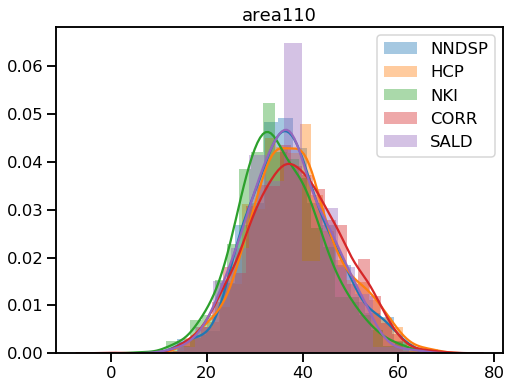

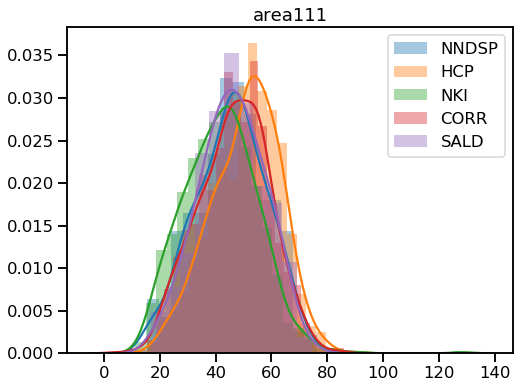

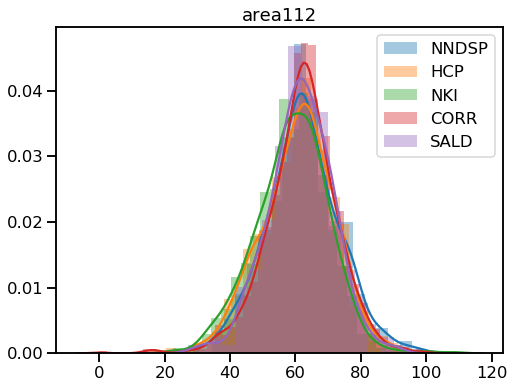

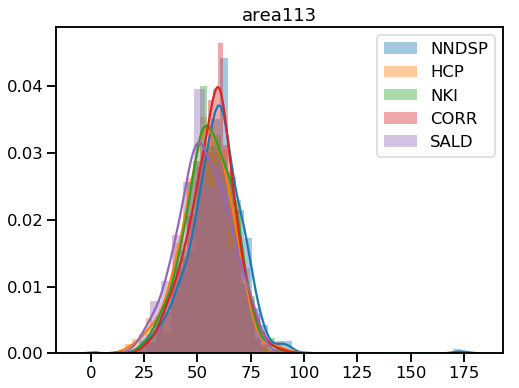

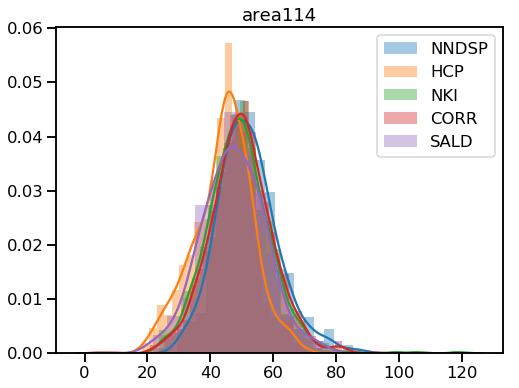

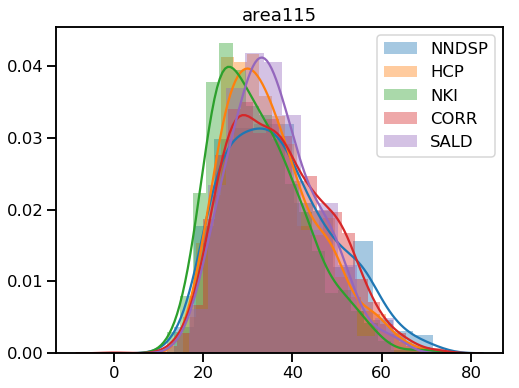

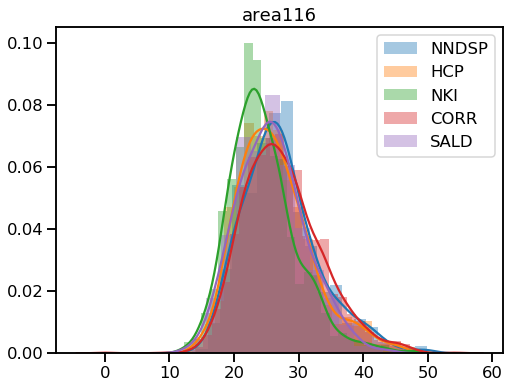

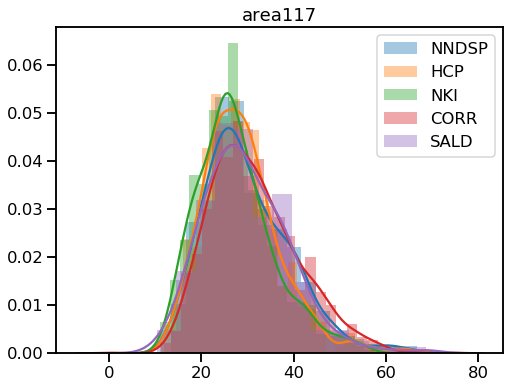

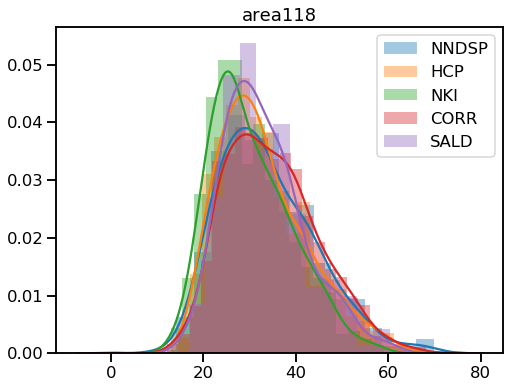

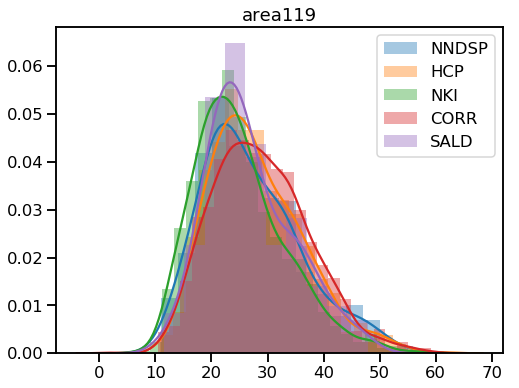

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature in features[5300:5310]:
    plt.figure(figsize=(8,6))
    for data_class in df_total.data_class.drop_duplicates():
        sns.set_context('talk')
        x = df_total[df_total.data_class == data_class][feature].dropna().values
        sns.distplot(x, label=dataclass_mapping[str(data_class)].upper())
    plt.title(feature)
    plt.xlabel('')
    plt.legend(loc='best')
    plt.savefig('/data/NNDSP/anal/analysis_notebooks/follow_up_analysis/figures/h3.1_'+feature+'.png', dpi=300)
    plt.show()        

# Hypothesis 3.2

In [67]:
p_vals = []
f_vals = []

X['female'] = [1 if s==1 else 0 for s in df_total.sex]
X['male'] = [1 if s==2 else 0 for s in df_total.sex]
X['nndsp'] = [1 if c==3 else 0 for c in df_total.data_class]
X['hcp'] = [1 if c==4 else 0 for c in df_total.data_class]
X['nki'] = [1 if c==5 else 0 for c in df_total.data_class]
X['corr'] = [1 if c==6 else 0 for c in df_total.data_class]
X['sald'] = [1 if c==7 else 0 for c in df_total.data_class]
X['age'] = df_total.age
X['nndsp*age'] = [X.nndsp.values[i]*df_total.age.values[i] for i in range(len(X))]
X['hcp*age'] = [X.hcp.values[i]*df_total.age.values[i] for i in range(len(X))]
X['nki*age'] = [X.nki.values[i]*df_total.age.values[i] for i in range(len(X))]
X['corr*age'] = [X['corr'].values[i]*df_total.age.values[i] for i in range(len(X))]
X['sald*age'] = [X.sald.values[i]*df_total.age.values[i] for i in range(len(X))]
X_res = X[['female', 'male', 'nndsp', 'hcp', 'nki', 'corr', 'sald', 'age']]
# X_norm = (X-X.min())/(X.max()-X.min())
# X_res_norm = (X_res-X_res.min())/(X_res.max()-X_res.min())
X_norm = X
X_res_norm = X_res

for feature in df_pvals.feature:
    from scipy.stats import f
    y = df_total[feature]    

#     X_norm = X
#     X_res_norm = X_res
    
    lm_full = linear_model.LinearRegression().fit(X_norm, y)
    rss_f = np.mean((lm_full.predict(X_norm) - y) ** 2)

    lm_res = linear_model.LinearRegression().fit(X_res, y)
    rss_r = np.mean((lm_res.predict(X_res_norm) - y) ** 2)
    
    df_f = (len(X_norm) - 1) - (X_norm.shape[1] - 1)
    df_r = (len(X_res_norm) - 1) - (X_res_norm.shape[1] - 1)
    
    F = ((rss_r - rss_f)/(df_r - df_f))/(rss_f/df_f)
    f_vals.append(F)
    p_val = f.sf(F, df_r - df_f, df_f)
    p_vals.append(p_val)
    
    print("Model Comparison for", feature)
    print(F, p_val, f.ppf(q=1-0.1, dfn=(df_r-df_f), dfd=df_f))

Model Comparison for thickness0
0.4968213947567471 0.7788612251942868 1.8487946128472565
Model Comparison for thickness1
1.6229284081933342 0.1503210952295312 1.8487946128472565
Model Comparison for thickness2
3.1032649066076163 0.008458975728333252 1.8487946128472565
Model Comparison for thickness3
0.25667983789951904 0.9366009590640543 1.8487946128472565
Model Comparison for thickness4
2.122115368975274 0.05991536679364009 1.8487946128472565
Model Comparison for thickness5
3.479460972994136 0.0038582815596936077 1.8487946128472565
Model Comparison for thickness6
6.264044220694335 8.538732946770854e-06 1.8487946128472565
Model Comparison for thickness7
9.522594170862828 4.855551139333321e-09 1.8487946128472565
Model Comparison for thickness8
2.831680525073146 0.014758740666161977 1.8487946128472565
Model Comparison for thickness9
6.515710131455739 4.834288155417587e-06 1.8487946128472565
Model Comparison for thickness10
3.681298854924916 0.0025176389636691796 1.8487946128472565
Model 

Model Comparison for thickness107
4.633383935925005 0.00032225472769216386 1.8487946128472565
Model Comparison for thickness108
2.189209217352357 0.05269275687229426 1.8487946128472565
Model Comparison for thickness109
2.820916256801067 0.015084966149908178 1.8487946128472565
Model Comparison for thickness110
3.2429236176065013 0.006331614185831852 1.8487946128472565
Model Comparison for thickness111
5.286709150692465 7.62449987141859e-05 1.8487946128472565
Model Comparison for thickness112
8.68885828351499 3.344066771271274e-08 1.8487946128472565
Model Comparison for thickness113
5.752233265381619 2.69888010086862e-05 1.8487946128472565
Model Comparison for thickness114
0.5532309914640802 0.735970121380882 1.8487946128472565
Model Comparison for thickness115
2.705124773574256 0.019064833205546382 1.8487946128472565
Model Comparison for thickness116
3.9450781276919438 0.0014336190945403256 1.8487946128472565
Model Comparison for thickness117
6.604059944968206 3.95743378236269e-06 1.848

1.2207658821631822 0.29648377680472243 1.8487946128472565
Model Comparison for thickness198
2.9437133917423317 0.011744231233754284 1.8487946128472565
Model Comparison for thickness199
3.18928616255356 0.007078522969152325 1.8487946128472565
Model Comparison for thickness200
0.5250172556404368 0.757530344375579 1.8487946128472565
Model Comparison for thickness201
3.9767850525327466 0.0013393008767385829 1.8487946128472565
Model Comparison for thickness202
4.009549236796645 0.0012482541395865202 1.8487946128472565
Model Comparison for thickness203
0.9243945475270201 0.4638613270784657 1.8487946128472565
Model Comparison for thickness204
4.638122097886742 0.00031892846807659355 1.8487946128472565
Model Comparison for thickness205
3.4628118851421017 0.0039958989577766274 1.8487946128472565
Model Comparison for thickness206
3.8142922174806886 0.0018966760815479523 1.8487946128472565
Model Comparison for thickness207
3.3429950075868544 0.005138125590551032 1.8487946128472565
Model Compariso

Model Comparison for thickness299
5.812810693713474 2.3562960543071466e-05 1.8487946128472565
Model Comparison for thickness300
6.325270777511229 7.436378362236239e-06 1.8487946128472565
Model Comparison for thickness301
7.099050642878022 1.2847099658278068e-06 1.8487946128472565
Model Comparison for thickness302
1.258832253161801 0.2788859127573207 1.8487946128472565
Model Comparison for thickness303
9.212418647526786 9.96506829458044e-09 1.8487946128472565
Model Comparison for thickness304
1.4782744665159797 0.193406635606275 1.8487946128472565
Model Comparison for thickness305
6.373167436464909 6.67368235760024e-06 1.8487946128472565
Model Comparison for thickness306
6.884063682084097 2.0957913500961934e-06 1.8487946128472565
Model Comparison for thickness307
2.6504733737596697 0.021278014936072273 1.8487946128472565
Model Comparison for thickness308
3.2116040704735545 0.0067578551302818 1.8487946128472565
Model Comparison for thickness309
11.413456967940759 5.932305823977187e-11 1.

Model Comparison for thickness390
2.5569094566600032 0.025652090367341517 1.8487946128472565
Model Comparison for thickness391
2.1395671570014767 0.05795203641732594 1.8487946128472565
Model Comparison for thickness392
3.038087257125332 0.00967599152057706 1.8487946128472565
Model Comparison for thickness393
4.75150275003052 0.00024871925107165164 1.8487946128472565
Model Comparison for thickness394
2.5188109979206867 0.02766985622519735 1.8487946128472565
Model Comparison for thickness395
5.572043832761095 4.038294460647656e-05 1.8487946128472565
Model Comparison for thickness396
4.050382207282127 0.0011432747651450126 1.8487946128472565
Model Comparison for thickness397
4.465910757899736 0.0004646349507424395 1.8487946128472565
Model Comparison for thickness398
2.332050815375782 0.039959284552290635 1.8487946128472565
Model Comparison for thickness399
0.5055788463832857 0.7722646157054317 1.8487946128472565
Model Comparison for thickness400
1.8510090655437152 0.09959362363797555 1.84

3.355886522786958 0.005001340220376554 1.8487946128472565
Model Comparison for thickness486
1.0169357104699182 0.40580158680706857 1.8487946128472565
Model Comparison for thickness487
0.9626624758271393 0.43923208284046444 1.8487946128472565
Model Comparison for thickness488
1.4926619993098473 0.18868539325879902 1.8487946128472565
Model Comparison for thickness489
3.0305498321781728 0.0098272557873483 1.8487946128472565
Model Comparison for thickness490
0.8204844875841693 0.5348508299314993 1.8487946128472565
Model Comparison for thickness491
1.8748990330804423 0.09530490608952337 1.8487946128472565
Model Comparison for thickness492
3.273052244123888 0.005946378246933345 1.8487946128472565
Model Comparison for thickness493
13.90046011639552 1.7366694990721525e-13 1.8487946128472565
Model Comparison for thickness494
4.552330735071227 0.00038476595900792247 1.8487946128472565
Model Comparison for thickness495
4.686388286846631 0.0002869203906833868 1.8487946128472565
Model Comparison fo

Model Comparison for thickness582
5.550193997413155 4.2401775570381195e-05 1.8487946128472565
Model Comparison for thickness583
3.3683930671788898 0.004872042025412984 1.8487946128472565
Model Comparison for thickness584
4.700364711923636 0.00027825991433216737 1.8487946128472565
Model Comparison for thickness585
1.6284398625190313 0.14886239939444812 1.8487946128472565
Model Comparison for thickness586
2.2455193241981863 0.04727237805947365 1.8487946128472565
Model Comparison for thickness587
3.511435782872482 0.003606871074423586 1.8487946128472565
Model Comparison for thickness588
6.913527137295831 1.9599652193993485e-06 1.8487946128472565
Model Comparison for thickness589
2.3288430450629396 0.040210072090182264 1.8487946128472565
Model Comparison for thickness590
7.42558571875528 6.096717369979605e-07 1.8487946128472565
Model Comparison for thickness591
2.417518579181332 0.033799678011326516 1.8487946128472565
Model Comparison for thickness592
6.7224011079351556 3.0258349113599013e

Model Comparison for thickness672
6.074540427277852 1.3088265578133086e-05 1.8487946128472565
Model Comparison for thickness673
6.6786959038573395 3.3412933246855355e-06 1.8487946128472565
Model Comparison for thickness674
6.5831698675765455 4.149290188550516e-06 1.8487946128472565
Model Comparison for thickness675
1.860255717073051 0.0979130789311271 1.8487946128472565
Model Comparison for thickness676
1.5754815233961024 0.1634131756568608 1.8487946128472565
Model Comparison for thickness677
1.5027698840655095 0.18542862120787892 1.8487946128472565
Model Comparison for thickness678
2.565750311550382 0.025204438732856094 1.8487946128472565
Model Comparison for thickness679
2.4125722235243527 0.03412999621980314 1.8487946128472565
Model Comparison for thickness680
3.6999166476570666 0.002419987814466598 1.8487946128472565
Model Comparison for thickness681
1.1499657676684543 0.331543707205771 1.8487946128472565
Model Comparison for thickness682
0.15041863077631062 0.9799745360737198 1.84

Model Comparison for thickness764
0.8496238813302703 0.5143710619999415 1.8487946128472565
Model Comparison for thickness765
0.9899011355495919 0.4222307570356928 1.8487946128472565
Model Comparison for thickness766
1.7217330807072309 0.12601810736003027 1.8487946128472565
Model Comparison for thickness767
1.6747787817880897 0.13708897373707996 1.8487946128472565
Model Comparison for thickness768
0.5174283568168367 0.7632965365289667 1.8487946128472565
Model Comparison for thickness769
1.0155174971174366 0.40665233405011475 1.8487946128472565
Model Comparison for thickness770
1.8912252717535964 0.09247239502673445 1.8487946128472565
Model Comparison for thickness771
1.1411936681653747 0.33610183713030795 1.8487946128472565
Model Comparison for thickness772
1.4757482415189525 0.19424608247274566 1.8487946128472565
Model Comparison for thickness773
3.601283155468079 0.0029832028998453167 1.8487946128472565
Model Comparison for thickness774
4.220627408362114 0.0007916508527592296 1.848794

Model Comparison for thickness856
0.4504645327208795 0.8132108677175589 1.8487946128472565
Model Comparison for thickness857
2.029586572197901 0.07140838441792542 1.8487946128472565
Model Comparison for thickness858
2.099016748663487 0.06261002659427037 1.8487946128472565
Model Comparison for thickness859
1.7843110523817374 0.1125200058671199 1.8487946128472565
Model Comparison for thickness860
2.65057338553366 0.021273747611977725 1.8487946128472565
Model Comparison for thickness861
3.1558768026947845 0.007586428582213317 1.8487946128472565
Model Comparison for thickness862
2.042995115677238 0.06962407021388217 1.8487946128472565
Model Comparison for thickness863
0.19759440710019913 0.9635091351272579 1.8487946128472565
Model Comparison for thickness864
2.571470980315779 0.024918778123284642 1.8487946128472565
Model Comparison for thickness865
2.247580786656729 0.04708430425785338 1.8487946128472565
Model Comparison for thickness866
0.452492475043604 0.8117318722506635 1.8487946128472

Model Comparison for thickness962
0.26999213924034077 0.9296765216293225 1.8487946128472565
Model Comparison for thickness963
0.7129459838072718 0.6136566559651977 1.8487946128472565
Model Comparison for thickness964
0.1630224478553425 0.9760441173987925 1.8487946128472565
Model Comparison for thickness965
0.6116763676626461 0.6909890005794062 1.8487946128472565
Model Comparison for thickness966
0.08435348172525363 0.9947045408784343 1.8487946128472565
Model Comparison for thickness967
1.1525221124507492 0.33022433708469084 1.8487946128472565
Model Comparison for thickness968
0.5666847715616598 0.725638676669249 1.8487946128472565
Model Comparison for thickness969
-0.07566998403453852 1.0 1.8487946128472565
Model Comparison for thickness970
0.7061258386521638 0.618795570991669 1.8487946128472565
Model Comparison for thickness971
1.5559400164482193 0.16909182254378127 1.8487946128472565
Model Comparison for thickness972
0.39151321946202366 0.8549479930270183 1.8487946128472565
Model Com

Model Comparison for thickness1058
1.1792701687345633 0.3166606464849037 1.8487946128472565
Model Comparison for thickness1059
3.690710509061157 0.0024678007617063395 1.8487946128472565
Model Comparison for thickness1060
1.7230710423222153 0.12571480768523652 1.8487946128472565
Model Comparison for thickness1061
0.607843553627144 0.6939419275724428 1.8487946128472565
Model Comparison for thickness1062
-0.7458609213516504 1.0 1.8487946128472565
Model Comparison for thickness1063
0.8382265968945334 0.5223311503761288 1.8487946128472565
Model Comparison for thickness1064
1.2391006649492735 0.2878998932321526 1.8487946128472565
Model Comparison for thickness1065
-0.4870420666713355 1.0 1.8487946128472565
Model Comparison for thickness1066
2.748918421847923 0.017453062826353397 1.8487946128472565
Model Comparison for thickness1067
0.40787767377281375 0.843632357436117 1.8487946128472565
Model Comparison for thickness1068
4.733435394935758 0.0002587836706173669 1.8487946128472565
Model Compa

4.977617540183703 0.00015117866729210538 1.8487946128472565
Model Comparison for thickness1164
5.385713112252189 6.117939357203479e-05 1.8487946128472565
Model Comparison for thickness1165
4.873901305506563 0.00019002312019220102 1.8487946128472565
Model Comparison for thickness1166
3.2210664978643404 0.006626211672042009 1.8487946128472565
Model Comparison for thickness1167
2.1033925438687833 0.062090985641562256 1.8487946128472565
Model Comparison for thickness1168
3.8164101881539896 0.0018881185263038551 1.8487946128472565
Model Comparison for thickness1169
6.743378094628178 2.8851319832067605e-06 1.8487946128472565
Model Comparison for thickness1170
3.555089173512645 0.0032893669374336456 1.8487946128472565
Model Comparison for thickness1171
2.530358772568823 0.02704273931130098 1.8487946128472565
Model Comparison for thickness1172
2.0759166220724663 0.06541808623928498 1.8487946128472565
Model Comparison for thickness1173
6.453588586726278 5.564054028873054e-06 1.8487946128472565


Model Comparison for thickness1266
0.8819179470063964 0.49218185937417214 1.8487946128472565
Model Comparison for thickness1267
2.495424946296382 0.028982769419271377 1.8487946128472565
Model Comparison for thickness1268
7.7067379368454 3.203228492668069e-07 1.8487946128472565
Model Comparison for thickness1269
5.260460161169269 8.082193028577606e-05 1.8487946128472565
Model Comparison for thickness1270
8.36351621807115 7.081539154860112e-08 1.8487946128472565
Model Comparison for thickness1271
1.0567847311705698 0.3824045363623439 1.8487946128472565
Model Comparison for thickness1272
1.5730762914668062 0.1641029249100139 1.8487946128472565
Model Comparison for thickness1273
2.855441256791331 0.014062606940277538 1.8487946128472565
Model Comparison for thickness1274
8.535776481632992 4.760865744682303e-08 1.8487946128472565
Model Comparison for thickness1275
4.850951619969038 0.0001998716009729653 1.8487946128472565
Model Comparison for thickness1276
8.314631537705012 7.92549028986755e

Model Comparison for thickness1364
3.290926288428341 0.005728743542592824 1.8487946128472565
Model Comparison for thickness1365
3.9352965580440253 0.001464013442155303 1.8487946128472565
Model Comparison for thickness1366
1.578643875323126 0.16251020139506758 1.8487946128472565
Model Comparison for thickness1367
3.938509966041696 0.001453959136333699 1.8487946128472565
Model Comparison for thickness1368
4.079277512410961 0.0010742882468117395 1.8487946128472565
Model Comparison for thickness1369
2.611035236647461 0.0230264910543273 1.8487946128472565
Model Comparison for thickness1370
4.454572847841847 0.0004762605611574315 1.8487946128472565
Model Comparison for thickness1371
2.140591486806881 0.057838697125751744 1.8487946128472565
Model Comparison for thickness1372
0.82021724020589 0.5350405784480341 1.8487946128472565
Model Comparison for thickness1373
1.8458137336250295 0.10054942497644803 1.8487946128472565
Model Comparison for thickness1374
3.2795211337438044 0.00586669721274244

Model Comparison for thickness1471
1.29428897580279 0.2632633073932669 1.8487946128472565
Model Comparison for thickness1472
2.322466709344767 0.04071302632354908 1.8487946128472565
Model Comparison for thickness1473
4.643017475631765 0.00031552748588170116 1.8487946128472565
Model Comparison for thickness1474
2.4460208487283865 0.03195489647680069 1.8487946128472565
Model Comparison for thickness1475
1.025750912028837 0.4005413263714401 1.8487946128472565
Model Comparison for thickness1476
0.8144188999752173 0.5391658100073313 1.8487946128472565
Model Comparison for thickness1477
1.666852138206098 0.13904182319798908 1.8487946128472565
Model Comparison for thickness1478
3.7523585790932943 0.0021644730841332005 1.8487946128472565
Model Comparison for thickness1479
4.740319139005988 0.0002549024509834944 1.8487946128472565
Model Comparison for thickness1480
3.9727227771775886 0.0013510350694141845 1.8487946128472565
Model Comparison for thickness1481
3.126959144221931 0.0080545585277706

Model Comparison for thickness1559
3.4761985852682438 0.003884877172307189 1.8487946128472565
Model Comparison for thickness1560
1.993171300221192 0.07647154273431243 1.8487946128472565
Model Comparison for thickness1561
2.18973197096449 0.0526398444086237 1.8487946128472565
Model Comparison for thickness1562
1.4974587110860325 0.18713374337745067 1.8487946128472565
Model Comparison for thickness1563
1.768923972544644 0.11571137997706374 1.8487946128472565
Model Comparison for thickness1564
1.1928717324266969 0.309931685610889 1.8487946128472565
Model Comparison for thickness1565
3.4797224717384374 0.0038561575014258815 1.8487946128472565
Model Comparison for thickness1566
3.5779246112342316 0.0031343554112419664 1.8487946128472565
Model Comparison for thickness1567
2.61477611875136 0.022854888930111148 1.8487946128472565
Model Comparison for thickness1568
1.5538670557143053 0.1697042841097868 1.8487946128472565
Model Comparison for thickness1569
1.280191003680676 0.26938726412672576 1

Model Comparison for thickness1663
6.188391146810116 1.0127495575756267e-05 1.8487946128472565
Model Comparison for thickness1664
6.486405182575232 5.165853041561979e-06 1.8487946128472565
Model Comparison for thickness1665
6.127427953054549 1.1618886466032577e-05 1.8487946128472565
Model Comparison for thickness1666
7.965190912545991 1.770328861959912e-07 1.8487946128472565
Model Comparison for thickness1667
10.969566231226038 1.6733542613691553e-10 1.8487946128472565
Model Comparison for thickness1668
6.147378167638625 1.1108247717788364e-05 1.8487946128472565
Model Comparison for thickness1669
7.2692494431773556 8.713799176103022e-07 1.8487946128472565
Model Comparison for thickness1670
14.934755324335887 1.5217554923421986e-14 1.8487946128472565
Model Comparison for thickness1671
5.026154081209864 0.00013581110545312687 1.8487946128472565
Model Comparison for thickness1672
13.6635610912626 3.0314328117369293e-13 1.8487946128472565
Model Comparison for thickness1673
8.43405056806085

Model Comparison for thickness1760
4.958284787127344 0.000157768538189116 1.8487946128472565
Model Comparison for thickness1761
4.12309928235981 0.000977416030959193 1.8487946128472565
Model Comparison for thickness1762
6.8566020086480055 2.230808058368256e-06 1.8487946128472565
Model Comparison for thickness1763
6.972605307724227 1.7134509201306216e-06 1.8487946128472565
Model Comparison for thickness1764
1.2872038680991735 0.26632658304346696 1.8487946128472565
Model Comparison for thickness1765
4.371866095277358 0.0005702100450969138 1.8487946128472565
Model Comparison for thickness1766
6.683030499532246 3.308598333793028e-06 1.8487946128472565
Model Comparison for thickness1767
3.614489344163289 0.002900931953058985 1.8487946128472565
Model Comparison for thickness1768
6.570533471119804 4.2698057597926784e-06 1.8487946128472565
Model Comparison for thickness1769
4.78193090883049 0.00023263703717497233 1.8487946128472565
Model Comparison for thickness1770
5.136393013562182 0.0001064

Model Comparison for thickness1858
1.7555518337298608 0.11855140678141096 1.8487946128472565
Model Comparison for thickness1859
0.3062222738678728 0.9094170730663311 1.8487946128472565
Model Comparison for thickness1860
0.49896451590827284 0.7772495499985896 1.8487946128472565
Model Comparison for thickness1861
0.32979157728911 0.8952300693153132 1.8487946128472565
Model Comparison for thickness1862
1.5899266630637414 0.1593243444078261 1.8487946128472565
Model Comparison for thickness1863
4.509366763095184 0.0004226148360900905 1.8487946128472565
Model Comparison for thickness1864
1.0156486537464962 0.40657360495302536 1.8487946128472565
Model Comparison for thickness1865
0.5249698968416057 0.7575663786563938 1.8487946128472565
Model Comparison for thickness1866
0.24150417574417554 0.9441262155353881 1.8487946128472565
Model Comparison for thickness1867
2.968265953576941 0.011168219760571951 1.8487946128472565
Model Comparison for thickness1868
5.78932831312117 2.4836453523312544e-05 

Model Comparison for thickness1951
2.2692764239983 0.04514738790841822 1.8487946128472565
Model Comparison for thickness1952
2.8886206145218183 0.01314344592175908 1.8487946128472565
Model Comparison for thickness1953
2.8339744484611353 0.014690107139943398 1.8487946128472565
Model Comparison for thickness1954
3.9918956323597485 0.0012965265206016858 1.8487946128472565
Model Comparison for thickness1955
1.461039679537209 0.19919642863214163 1.8487946128472565
Model Comparison for thickness1956
9.265487567392295 8.812417923449848e-09 1.8487946128472565
Model Comparison for thickness1957
2.85745698842932 0.014005034450092817 1.8487946128472565
Model Comparison for thickness1958
4.857247955421831 0.00019712043180478646 1.8487946128472565
Model Comparison for thickness1959
0.9125453201778754 0.4716596377906488 1.8487946128472565
Model Comparison for thickness1960
2.1129246056490243 0.06097425499459296 1.8487946128472565
Model Comparison for thickness1961
6.2048874084655266 9.75773673126813

Model Comparison for thickness2052
3.6185146774678065 0.002876300482410352 1.8487946128472565
Model Comparison for thickness2053
1.2000418087245344 0.30642991279986276 1.8487946128472565
Model Comparison for thickness2054
0.606417042116249 0.6950410656770372 1.8487946128472565
Model Comparison for thickness2055
4.897321976894274 0.00018046774629721914 1.8487946128472565
Model Comparison for thickness2056
12.518261996338369 4.463208547867156e-12 1.8487946128472565
Model Comparison for thickness2057
8.72249294732936 3.094193312703544e-08 1.8487946128472565
Model Comparison for thickness2058
3.1600583864190512 0.007520966267410866 1.8487946128472565
Model Comparison for thickness2059
6.777667993698246 2.669016801279156e-06 1.8487946128472565
Model Comparison for thickness2060
2.5882538777382824 0.024098535632985387 1.8487946128472565
Model Comparison for thickness2061
7.180071682029218 1.0680264044608046e-06 1.8487946128472565
Model Comparison for thickness2062
4.070603092506577 0.0010945

Model Comparison for thickness2158
1.1715243740568544 0.3205432326089906 1.8487946128472565
Model Comparison for thickness2159
1.7957725094494292 0.11019512458600456 1.8487946128472565
Model Comparison for thickness2160
1.6613909927635415 0.1404017270724849 1.8487946128472565
Model Comparison for thickness2161
3.2579980021390793 0.006135919380240971 1.8487946128472565
Model Comparison for thickness2162
5.057239469879039 0.00012679243982882633 1.8487946128472565
Model Comparison for thickness2163
0.5974506930943535 0.7019503324980498 1.8487946128472565
Model Comparison for thickness2164
-0.2136612718339483 1.0 1.8487946128472565
Model Comparison for thickness2165
1.4884383317461125 0.19006090780428184 1.8487946128472565
Model Comparison for thickness2166
0.8492820069156484 0.5146088757683507 1.8487946128472565
Model Comparison for thickness2167
0.8537593075518424 0.5114991330269898 1.8487946128472565
Model Comparison for thickness2168
2.741915848529477 0.017701651431429218 1.84879461284

Model Comparison for thickness2252
0.6805063194653428 0.6382119498114577 1.8487946128472565
Model Comparison for thickness2253
0.7278995062823095 0.6024388581604044 1.8487946128472565
Model Comparison for thickness2254
1.5394984804283949 0.17400334433376982 1.8487946128472565
Model Comparison for thickness2255
2.574788975313798 0.02475452015084232 1.8487946128472565
Model Comparison for thickness2256
4.177190349044853 0.000869642686608939 1.8487946128472565
Model Comparison for thickness2257
1.0726325516754704 0.3733731923560022 1.8487946128472565
Model Comparison for thickness2258
1.045929514904569 0.38868072257686265 1.8487946128472565
Model Comparison for thickness2259
2.2191308906810687 0.04974345205205509 1.8487946128472565
Model Comparison for thickness2260
1.3308574360318204 0.24790991998521464 1.8487946128472565
Model Comparison for thickness2261
1.1310503874971822 0.3414318441882839 1.8487946128472565
Model Comparison for thickness2262
1.3728618301515514 0.23119976967831962 1.

Model Comparison for thickness2347
4.781058558730878 0.00023308344737188062 1.8487946128472565
Model Comparison for thickness2348
1.5900104180434025 0.15930090302176725 1.8487946128472565
Model Comparison for thickness2349
0.8868493390819859 0.48884253006831624 1.8487946128472565
Model Comparison for thickness2350
2.651116602952112 0.021250583864911653 1.8487946128472565
Model Comparison for thickness2351
0.42961152577179246 0.828267786260624 1.8487946128472565
Model Comparison for thickness2352
1.4347128324623102 0.20832857586253078 1.8487946128472565
Model Comparison for thickness2353
5.557158160603844 4.174767704553029e-05 1.8487946128472565
Model Comparison for thickness2354
7.57813038496412 4.3006080111260024e-07 1.8487946128472565
Model Comparison for thickness2355
7.989082023568442 1.675794043022734e-07 1.8487946128472565
Model Comparison for thickness2356
5.8479420174685846 2.1777813387786214e-05 1.8487946128472565
Model Comparison for thickness2357
4.556693018345381 0.00038111

Model Comparison for thickness2447
0.698842864707285 0.6242978002742586 1.8487946128472565
Model Comparison for thickness2448
2.269318790537742 0.045143680403267036 1.8487946128472565
Model Comparison for thickness2449
1.6430764677153935 0.14504962493073983 1.8487946128472565
Model Comparison for thickness2450
4.260232998497875 0.0007265720234108797 1.8487946128472565
Model Comparison for thickness2451
3.5587714042161678 0.0032638729166556825 1.8487946128472565
Model Comparison for thickness2452
1.9845274896423017 0.07772143602129955 1.8487946128472565
Model Comparison for thickness2453
4.874826942228972 0.00018963613837642514 1.8487946128472565
Model Comparison for thickness2454
5.9716381590407925 1.6496615152184317e-05 1.8487946128472565
Model Comparison for thickness2455
3.906636499449915 0.0015567649876038901 1.8487946128472565
Model Comparison for thickness2456
6.357025717610724 6.921607728058537e-06 1.8487946128472565
Model Comparison for thickness2457
2.2332588270634104 0.048405

Model Comparison for thickness2545
6.4121547210026435 6.110684422733259e-06 1.8487946128472565
Model Comparison for thickness2546
1.5535910149858914 0.16978598801375228 1.8487946128472565
Model Comparison for thickness2547
3.651020381179941 0.0026847663444634247 1.8487946128472565
Model Comparison for thickness2548
4.6410190402179365 0.00031691151352972863 1.8487946128472565
Model Comparison for thickness2549
2.5946071013423087 0.02379484223463082 1.8487946128472565
Model Comparison for thickness2550
3.305319845730891 0.005559155336660928 1.8487946128472565
Model Comparison for thickness2551
23.462479121013345 2.712437932825479e-23 1.8487946128472565
Model Comparison for thickness2552
12.885580315360128 1.885240094837009e-12 1.8487946128472565
Model Comparison for thickness2553
5.972883332662358 1.645051480686753e-05 1.8487946128472565
Model Comparison for thickness2554
3.7406119841373413 0.002219298647347064 1.8487946128472565
Model Comparison for thickness2555
0.6754532392547334 0.64

Model Comparison for thickness2637
3.6628017411444334 0.0026184820830629863 1.8487946128472565
Model Comparison for thickness2638
11.168610125836157 1.0512967273847042e-10 1.8487946128472565
Model Comparison for thickness2639
0.4002620153347573 0.8489271914301656 1.8487946128472565
Model Comparison for thickness2640
3.126980484972115 0.008054202901746386 1.8487946128472565
Model Comparison for thickness2641
1.4255623406819367 0.21158559716069966 1.8487946128472565
Model Comparison for thickness2642
7.267681108323155 8.74505249953883e-07 1.8487946128472565
Model Comparison for thickness2643
2.688404710261001 0.019717260723210586 1.8487946128472565
Model Comparison for thickness2644
10.001522611914787 1.5964305713127957e-09 1.8487946128472565
Model Comparison for thickness2645
7.472510211148812 5.476396595485315e-07 1.8487946128472565
Model Comparison for thickness2646
2.7466975675210685 0.01753153540897394 1.8487946128472565
Model Comparison for thickness2647
1.6658191465042733 0.139298

Model Comparison for thickness2729
0.9247825839639426 0.4636073075766497 1.8487946128472565
Model Comparison for thickness2730
0.49055550393724207 0.7835629092264226 1.8487946128472565
Model Comparison for thickness2731
1.035760379381776 0.3946264875763357 1.8487946128472565
Model Comparison for thickness2732
4.136352778707776 0.0009498509076320216 1.8487946128472565
Model Comparison for thickness2733
3.122197725088397 0.008134286849543303 1.8487946128472565
Model Comparison for thickness2734
7.039505381311253 1.4713690916359013e-06 1.8487946128472565
Model Comparison for thickness2735
2.4621244474871733 0.03095550845947969 1.8487946128472565
Model Comparison for thickness2736
2.7599613304530375 0.017067872394218316 1.8487946128472565
Model Comparison for thickness2737
3.418151630375561 0.004389202836733915 1.8487946128472565
Model Comparison for thickness2738
0.36580292451784363 0.8722246319448511 1.8487946128472565
Model Comparison for thickness2739
6.9969553995626415 1.6210633009084

0.024511759735046646 0.9997319948117538 1.8487946128472565
Model Comparison for thickness2825
1.6872518475611302 0.13406584659373907 1.8487946128472565
Model Comparison for thickness2826
0.6115700323032506 0.6910709181906513 1.8487946128472565
Model Comparison for thickness2827
1.6945698811151657 0.1323201725124848 1.8487946128472565
Model Comparison for thickness2828
0.005527939921491738 0.9999933039046931 1.8487946128472565
Model Comparison for thickness2829
2.6575917396710866 0.020976333777936822 1.8487946128472565
Model Comparison for thickness2830
0.17591386955734264 0.9716656609169214 1.8487946128472565
Model Comparison for thickness2831
3.9963206128617172 0.0012842569684053302 1.8487946128472565
Model Comparison for thickness2832
3.6552640086591905 0.0026607033876137457 1.8487946128472565
Model Comparison for thickness2833
6.310303334119483 7.692037601636836e-06 1.8487946128472565
Model Comparison for thickness2834
0.43692428175612336 0.8230202962709829 1.8487946128472565
Model 

Model Comparison for thickness2935
2.100976135926685 0.06237711059140151 1.8487946128472565
Model Comparison for thickness2936
2.515421146734422 0.02785657423164994 1.8487946128472565
Model Comparison for thickness2937
8.962570335022294 1.7766457169403015e-08 1.8487946128472565
Model Comparison for thickness2938
3.2232882159629597 0.006595666865933596 1.8487946128472565
Model Comparison for thickness2939
1.282494048118154 0.26837897757338586 1.8487946128472565
Model Comparison for thickness2940
0.4966054128619638 0.7790235500410495 1.8487946128472565
Model Comparison for thickness2941
2.6914196339766905 0.019598048898450134 1.8487946128472565
Model Comparison for thickness2942
1.794270528824407 0.11049727878746128 1.8487946128472565
Model Comparison for thickness2943
1.5375702591915772 0.17458747500763683 1.8487946128472565
Model Comparison for thickness2944
1.2360186097165275 0.2893287669497894 1.8487946128472565
Model Comparison for thickness2945
2.3402493099986037 0.0393250482100994

Model Comparison for thickness3032
1.6970999571314778 0.131721411488486 1.8487946128472565
Model Comparison for thickness3033
2.868890226032269 0.013682772774929729 1.8487946128472565
Model Comparison for thickness3034
0.26639661050397623 0.9315756628154813 1.8487946128472565
Model Comparison for thickness3035
2.055223162314192 0.06803319859432144 1.8487946128472565
Model Comparison for thickness3036
1.369755945534559 0.23240212960995812 1.8487946128472565
Model Comparison for thickness3037
2.3542202141942146 0.038266236338355346 1.8487946128472565
Model Comparison for thickness3038
0.27675681008423686 0.9260468497715536 1.8487946128472565
Model Comparison for thickness3039
2.3097858719934647 0.04173106674078882 1.8487946128472565
Model Comparison for thickness3040
2.5352370275726464 0.026781929068911588 1.8487946128472565
Model Comparison for thickness3041
6.360410724204573 6.868868772238743e-06 1.8487946128472565
Model Comparison for thickness3042
1.822569562384176 0.1049294980762464

Model Comparison for thickness3124
4.976960249629623 0.00015139817339436458 1.8487946128472565
Model Comparison for thickness3125
1.8712754871800876 0.09594429558556813 1.8487946128472565
Model Comparison for thickness3126
3.2442512657440377 0.006314137139281645 1.8487946128472565
Model Comparison for thickness3127
7.689358803438883 3.3333844776308046e-07 1.8487946128472565
Model Comparison for thickness3128
1.1844146422220352 0.3141022839688522 1.8487946128472565
Model Comparison for thickness3129
3.1686610976485428 0.007388016753287728 1.8487946128472565
Model Comparison for thickness3130
1.8661418010257869 0.09685690631035528 1.8487946128472565
Model Comparison for thickness3131
3.5462655288584126 0.0033512540489453553 1.8487946128472565
Model Comparison for thickness3132
3.0737624794402105 0.008990201053270575 1.8487946128472565
Model Comparison for thickness3133
0.8009481997397006 0.5488100512512 1.8487946128472565
Model Comparison for thickness3134
3.4975055922871987 0.0037143655

Model Comparison for thickness3234
4.889784170493974 0.00018349000297061162 1.8487946128472565
Model Comparison for thickness3235
3.0767791795327897 0.008934426980073186 1.8487946128472565
Model Comparison for thickness3236
2.4866865752978082 0.02948847627189367 1.8487946128472565
Model Comparison for thickness3237
5.2181715267916315 8.877496028572065e-05 1.8487946128472565
Model Comparison for thickness3238
4.507882629199691 0.000423985981076386 1.8487946128472565
Model Comparison for thickness3239
3.335761903786837 0.005216465551738212 1.8487946128472565
Model Comparison for thickness3240
1.8967782300880676 0.0915267909538041 1.8487946128472565
Model Comparison for thickness3241
4.859897934818757 0.00019597376526909067 1.8487946128472565
Model Comparison for thickness3242
0.7653868583092622 0.5746540329115304 1.8487946128472565
Model Comparison for thickness3243
1.645466291567733 0.14443543085685057 1.8487946128472565
Model Comparison for thickness3244
2.786728688889529 0.01616793117

Model Comparison for thickness3339
2.985941562409598 0.010770606770198657 1.8487946128472565
Model Comparison for thickness3340
1.5619735012650156 0.16732026431028005 1.8487946128472565
Model Comparison for thickness3341
1.9494945723333905 0.08298386366063287 1.8487946128472565
Model Comparison for thickness3342
3.220450829463549 0.006634700424969568 1.8487946128472565
Model Comparison for thickness3343
0.546787218422929 0.740908662892277 1.8487946128472565
Model Comparison for thickness3344
1.9744295629429782 0.07920561278609378 1.8487946128472565
Model Comparison for thickness3345
2.637788348305952 0.021825987138623094 1.8487946128472565
Model Comparison for thickness3346
1.5522042364173267 0.17019697698881758 1.8487946128472565
Model Comparison for thickness3347
2.3538394657963764 0.03829472944326912 1.8487946128472565
Model Comparison for thickness3348
2.5526707863750833 0.025869406652254585 1.8487946128472565
Model Comparison for thickness3349
1.6732922856687475 0.1374533098523062

Model Comparison for thickness3433
4.88514020689498 0.00018537686500458853 1.8487946128472565
Model Comparison for thickness3434
7.129061536016608 1.1997684250036434e-06 1.8487946128472565
Model Comparison for thickness3435
4.374169045093333 0.0005673618572998867 1.8487946128472565
Model Comparison for thickness3436
1.1553551867158092 0.32876685550424856 1.8487946128472565
Model Comparison for thickness3437
1.302477507400066 0.25975901314171557 1.8487946128472565
Model Comparison for thickness3438
1.274543497172229 0.2718728519668301 1.8487946128472565
Model Comparison for thickness3439
0.5535056676997264 0.73575945245623 1.8487946128472565
Model Comparison for thickness3440
1.9205329355288572 0.08758141493955171 1.8487946128472565
Model Comparison for thickness3441
0.9633447866624467 0.43880077812699314 1.8487946128472565
Model Comparison for thickness3442
1.0794609458521935 0.36952998827556777 1.8487946128472565
Model Comparison for thickness3443
1.836860628137432 0.10221630575069805

1.9508248456803428 0.08277815120034808 1.8487946128472565
Model Comparison for thickness3526
2.2682020745867026 0.045241500838760516 1.8487946128472565
Model Comparison for thickness3527
0.4752793470880087 0.7949547930159302 1.8487946128472565
Model Comparison for thickness3528
0.6434266180909246 0.6665646492067442 1.8487946128472565
Model Comparison for thickness3529
1.086802522778289 0.3654303282999342 1.8487946128472565
Model Comparison for thickness3530
0.6658339341155166 0.6494010136580393 1.8487946128472565
Model Comparison for thickness3531
1.5417556945519022 0.1733217265381149 1.8487946128472565
Model Comparison for thickness3532
2.0397096337749208 0.07005739120296224 1.8487946128472565
Model Comparison for thickness3533
2.3314197807392287 0.04000850198893503 1.8487946128472565
Model Comparison for thickness3534
1.6013006617298942 0.1561687975418001 1.8487946128472565
Model Comparison for thickness3535
-0.3383742128665488 1.0 1.8487946128472565
Model Comparison for thickness353

Model Comparison for thickness3623
2.934083705964761 0.011977922754590194 1.8487946128472565
Model Comparison for thickness3624
0.6917531165786072 0.6296677211049237 1.8487946128472565
Model Comparison for thickness3625
1.5766975319323513 0.1630654352095188 1.8487946128472565
Model Comparison for thickness3626
2.5811200398343783 0.024443976774323216 1.8487946128472565
Model Comparison for thickness3627
1.4116309709141648 0.2166277690984544 1.8487946128472565
Model Comparison for thickness3628
0.9216884597435803 0.46563521117575 1.8487946128472565
Model Comparison for thickness3629
1.2706044602429412 0.27361753045564186 1.8487946128472565
Model Comparison for thickness3630
0.583418395220474 0.7127612407571782 1.8487946128472565
Model Comparison for thickness3631
-0.16584978249437585 1.0 1.8487946128472565
Model Comparison for thickness3632
0.5345304586603673 0.7502802307547178 1.8487946128472565
Model Comparison for thickness3633
0.8675060975243744 0.5020161727743067 1.8487946128472565


Model Comparison for thickness3724
6.436048384241159 5.789257389409831e-06 1.8487946128472565
Model Comparison for thickness3725
2.8488291054000046 0.014253072091182623 1.8487946128472565
Model Comparison for thickness3726
2.1231189633664176 0.05980079106355272 1.8487946128472565
Model Comparison for thickness3727
2.5419456088629637 0.02642719482318697 1.8487946128472565
Model Comparison for thickness3728
3.8817372877382437 0.0016420187657548776 1.8487946128472565
Model Comparison for thickness3729
4.6107475887318055 0.0003386250467449996 1.8487946128472565
Model Comparison for thickness3730
2.2600605768284807 0.045960754129073 1.8487946128472565
Model Comparison for thickness3731
4.2757900256742145 0.0007024780793731442 1.8487946128472565
Model Comparison for thickness3732
5.083418215564388 0.0001196593349407496 1.8487946128472565
Model Comparison for thickness3733
3.5938095846166074 0.0030307699737964038 1.8487946128472565
Model Comparison for thickness3734
9.281977398493497 8.482107

Model Comparison for thickness3829
7.079078084366788 1.3445309383963985e-06 1.8487946128472565
Model Comparison for thickness3830
1.4058055863735546 0.21876628176995508 1.8487946128472565
Model Comparison for thickness3831
1.903663340476189 0.09036671113500495 1.8487946128472565
Model Comparison for thickness3832
1.1123593045128561 0.3514206924780652 1.8487946128472565
Model Comparison for thickness3833
1.408501843899613 0.21777425852944693 1.8487946128472565
Model Comparison for thickness3834
0.9698588367831977 0.43469708230426307 1.8487946128472565
Model Comparison for thickness3835
0.6426188241582573 0.6671848114164514 1.8487946128472565
Model Comparison for thickness3836
2.631063461196513 0.022121968033360296 1.8487946128472565
Model Comparison for thickness3837
2.80879805512298 0.015460564335432386 1.8487946128472565
Model Comparison for thickness3838
3.06300166537311 0.00919192194710682 1.8487946128472565
Model Comparison for thickness3839
0.5656410025873678 0.7264410467840843 1.

Model Comparison for thickness3922
0.22399089578084133 0.9522972001153183 1.8487946128472565
Model Comparison for thickness3923
2.1493679608099865 0.05687610523400384 1.8487946128472565
Model Comparison for thickness3924
7.540142239011921 4.6913066553953944e-07 1.8487946128472565
Model Comparison for thickness3925
3.024735926299481 0.009945498283440608 1.8487946128472565
Model Comparison for thickness3926
7.8138128539671685 2.505878765232243e-07 1.8487946128472565
Model Comparison for thickness3927
8.119641559240401 1.241363349931184e-07 1.8487946128472565
Model Comparison for thickness3928
7.804383069573295 2.560674013761709e-07 1.8487946128472565
Model Comparison for thickness3929
7.108592730415307 1.2570727244137417e-06 1.8487946128472565
Model Comparison for thickness3930
1.45321090644912 0.20187537263884053 1.8487946128472565
Model Comparison for thickness3931
3.4914770381459066 0.0037618522753417863 1.8487946128472565
Model Comparison for thickness3932
2.5534874435774686 0.025827

Model Comparison for thickness4013
5.369647206274322 6.340621159474382e-05 1.8487946128472565
Model Comparison for thickness4014
3.280946930226196 0.005849275479823065 1.8487946128472565
Model Comparison for thickness4015
5.8065755553018565 2.3894640092929766e-05 1.8487946128472565
Model Comparison for thickness4016
3.3654224607414562 0.004902454512988017 1.8487946128472565
Model Comparison for thickness4017
3.9668261618020733 0.0013682480754436863 1.8487946128472565
Model Comparison for thickness4018
4.5205013788245045 0.0004124666621626556 1.8487946128472565
Model Comparison for thickness4019
4.77530566322514 0.0002360486870884556 1.8487946128472565
Model Comparison for thickness4020
3.9706581660701956 0.0013570375665391287 1.8487946128472565
Model Comparison for thickness4021
3.2028067935461166 0.006882529177387434 1.8487946128472565
Model Comparison for thickness4022
4.179025424856621 0.000866199622470212 1.8487946128472565
Model Comparison for thickness4023
4.632685224672727 0.000

0.4826858569965428 0.7894446869341459 1.8487946128472565
Model Comparison for thickness4110
0.9581991791199117 0.4420602704190877 1.8487946128472565
Model Comparison for thickness4111
1.005681363780169 0.41258670778919965 1.8487946128472565
Model Comparison for thickness4112
3.6233971172184694 0.002846699326618394 1.8487946128472565
Model Comparison for thickness4113
1.2280153607935744 0.29306567345933765 1.8487946128472565
Model Comparison for thickness4114
2.8668475238755162 0.01373981784481584 1.8487946128472565
Model Comparison for thickness4115
2.7047136788565007 0.01908062208668528 1.8487946128472565
Model Comparison for thickness4116
5.289681957762967 7.574312152481426e-05 1.8487946128472565
Model Comparison for thickness4117
6.433135162897502 5.827528965812169e-06 1.8487946128472565
Model Comparison for thickness4118
0.8144081584987206 0.5391734667643163 1.8487946128472565
Model Comparison for thickness4119
1.6075622474120779 0.15445536617281155 1.8487946128472565
Model Compari

Model Comparison for thickness4207
1.6313788011602686 0.1480897267011667 1.8487946128472565
Model Comparison for thickness4208
1.3927915075899968 0.22360861868981322 1.8487946128472565
Model Comparison for thickness4209
2.657586750354406 0.02097654378066697 1.8487946128472565
Model Comparison for thickness4210
4.775923717675168 0.00023572833992254214 1.8487946128472565
Model Comparison for thickness4211
3.009134395497302 0.010269669239679988 1.8487946128472565
Model Comparison for thickness4212
4.248616296324527 0.0007450931256960248 1.8487946128472565
Model Comparison for thickness4213
4.553334753389838 0.0003839227550708116 1.8487946128472565
Model Comparison for thickness4214
2.7069825945907726 0.018993636852561935 1.8487946128472565
Model Comparison for thickness4215
3.066727138242189 0.009121591779194584 1.8487946128472565
Model Comparison for thickness4216
2.8684911010314993 0.013693900805901903 1.8487946128472565
Model Comparison for thickness4217
5.532140256298022 4.41451764857

Model Comparison for thickness4319
1.6179584960749467 0.15164735601780643 1.8487946128472565
Model Comparison for thickness4320
1.4030619506404804 0.21977967518405658 1.8487946128472565
Model Comparison for thickness4321
1.9813797784557845 0.0781812883230241 1.8487946128472565
Model Comparison for thickness4322
2.605821228585217 0.023267734161558144 1.8487946128472565
Model Comparison for thickness4323
3.752841546243914 0.002162247595350609 1.8487946128472565
Model Comparison for thickness4324
2.381457775677082 0.0362794233228652 1.8487946128472565
Model Comparison for thickness4325
4.910275034914394 0.00017538891600866712 1.8487946128472565
Model Comparison for thickness4326
2.7906878001020057 0.016038774201348468 1.8487946128472565
Model Comparison for thickness4327
1.3709193118115848 0.23195114894254462 1.8487946128472565
Model Comparison for thickness4328
1.052153648681383 0.3850731580968867 1.8487946128472565
Model Comparison for thickness4329
3.0542071832834057 0.0093600426713780

Model Comparison for thickness4419
4.300542002284482 0.0006657581198553968 1.8487946128472565
Model Comparison for thickness4420
4.185370928278252 0.0008543970904547747 1.8487946128472565
Model Comparison for thickness4421
0.7882310480482416 0.5579900123602548 1.8487946128472565
Model Comparison for thickness4422
1.1275472363490504 0.3432874707539258 1.8487946128472565
Model Comparison for thickness4423
1.589094275434262 0.15955747944105847 1.8487946128472565
Model Comparison for thickness4424
2.424553361436748 0.03333514005724638 1.8487946128472565
Model Comparison for thickness4425
5.796791108639435 2.4424494884310454e-05 1.8487946128472565
Model Comparison for thickness4426
2.439015818628799 0.0323991749277889 1.8487946128472565
Model Comparison for thickness4427
1.1763196131610045 0.31813527775837486 1.8487946128472565
Model Comparison for thickness4428
0.739407361454907 0.5938556749962911 1.8487946128472565
Model Comparison for thickness4429
3.1204760143445807 0.008163304916237103

Model Comparison for thickness4507
3.61877940360038 0.002874687797815124 1.8487946128472565
Model Comparison for thickness4508
2.3388259190865117 0.039434471534159674 1.8487946128472565
Model Comparison for thickness4509
5.950615033298548 1.7294619653766894e-05 1.8487946128472565
Model Comparison for thickness4510
6.013486263007242 1.501539569643451e-05 1.8487946128472565
Model Comparison for thickness4511
2.8522686060992455 0.014153686891456711 1.8487946128472565
Model Comparison for thickness4512
4.080808486509539 0.0010707497309575763 1.8487946128472565
Model Comparison for thickness4513
6.6755077564197345 3.365545842791516e-06 1.8487946128472565
Model Comparison for thickness4514
3.0040672649197915 0.010377144685196354 1.8487946128472565
Model Comparison for thickness4515
5.0989869374623815 0.00011560724419998434 1.8487946128472565
Model Comparison for thickness4516
4.33993523237534 0.0006111856353461052 1.8487946128472565
Model Comparison for thickness4517
2.6367571427397176 0.021

Model Comparison for thickness4606
5.387202124179831 6.0976978625468063e-05 1.8487946128472565
Model Comparison for thickness4607
0.8392064956798215 0.5216442010339999 1.8487946128472565
Model Comparison for thickness4608
1.4721679192120387 0.1954411939053466 1.8487946128472565
Model Comparison for thickness4609
3.5872277490818885 0.003073276413571901 1.8487946128472565
Model Comparison for thickness4610
2.0192945223987593 0.0728067945388048 1.8487946128472565
Model Comparison for thickness4611
1.0959176245892566 0.36038699756532927 1.8487946128472565
Model Comparison for thickness4612
1.1231700685323032 0.3456167700781573 1.8487946128472565
Model Comparison for thickness4613
2.4837439690944034 0.029660661564281335 1.8487946128472565
Model Comparison for thickness4614
4.041700955578369 0.001164840178409712 1.8487946128472565
Model Comparison for thickness4615
4.57599096747455 0.00036537347267086106 1.8487946128472565
Model Comparison for thickness4616
5.075103148574779 0.00012188082028

Model Comparison for thickness4695
4.995265143200523 0.0001454015242909108 1.8487946128472565
Model Comparison for thickness4696
4.1712992506823845 0.0008807872762613175 1.8487946128472565
Model Comparison for thickness4697
2.509699200448656 0.028174486374109586 1.8487946128472565
Model Comparison for thickness4698
2.2997358036292512 0.04255500885448646 1.8487946128472565
Model Comparison for thickness4699
3.340534230155858 0.0051646478283130385 1.8487946128472565
Model Comparison for thickness4700
2.6517185176522426 0.02122494549145466 1.8487946128472565
Model Comparison for thickness4701
3.2833296066271673 0.005820274283531959 1.8487946128472565
Model Comparison for thickness4702
5.298355549475504 7.429746347396175e-05 1.8487946128472565
Model Comparison for thickness4703
2.6033596057654482 0.02338247083533968 1.8487946128472565
Model Comparison for thickness4704
0.21833886694901447 0.9548120189160973 1.8487946128472565
Model Comparison for thickness4705
1.5588815785746695 0.16822606

Model Comparison for thickness4795
5.886469417887917 1.9974209833234568e-05 1.8487946128472565
Model Comparison for thickness4796
3.307073496165426 0.005538831336562384 1.8487946128472565
Model Comparison for thickness4797
2.421320576356088 0.03354785415082079 1.8487946128472565
Model Comparison for thickness4798
4.295145402823416 0.0006735991223269197 1.8487946128472565
Model Comparison for thickness4799
4.059480475955743 0.0011210952877470939 1.8487946128472565
Model Comparison for thickness4800
1.0318087366858704 0.3969542203579262 1.8487946128472565
Model Comparison for thickness4801
6.166555924333287 1.0638422211177213e-05 1.8487946128472565
Model Comparison for thickness4802
0.8934792243584818 0.4843740242910489 1.8487946128472565
Model Comparison for thickness4803
1.7007307622955075 0.13086641577332972 1.8487946128472565
Model Comparison for thickness4804
4.813809164903387 0.00021689140672749265 1.8487946128472565
Model Comparison for thickness4805
5.283810878127991 7.6737466112

Model Comparison for thickness4886
3.9090087422194606 0.0015488733395364884 1.8487946128472565
Model Comparison for thickness4887
2.755519171309242 0.017221824097652126 1.8487946128472565
Model Comparison for thickness4888
4.043106187309741 0.0011613224230022775 1.8487946128472565
Model Comparison for thickness4889
4.247262023071888 0.0007472823844151744 1.8487946128472565
Model Comparison for thickness4890
5.9055748473419545 1.9135651213370008e-05 1.8487946128472565
Model Comparison for thickness4891
7.9589110173181075 1.7960478649093094e-07 1.8487946128472565
Model Comparison for thickness4892
1.6102634400387932 0.15372137273063216 1.8487946128472565
Model Comparison for thickness4893
3.133686530031099 0.00794320570013481 1.8487946128472565
Model Comparison for thickness4894
1.3784031981556195 0.2290675824624833 1.8487946128472565
Model Comparison for thickness4895
3.1930086057210865 0.007024026824028131 1.8487946128472565
Model Comparison for thickness4896
2.996284747426595 0.010544

Model Comparison for thickness4981
5.722847376906688 2.8824458920138027e-05 1.8487946128472565
Model Comparison for thickness4982
4.682022461241953 0.0002896799024286837 1.8487946128472565
Model Comparison for thickness4983
0.26157483193342096 0.9340891094587531 1.8487946128472565
Model Comparison for thickness4984
1.4473904840802057 0.20388710736660898 1.8487946128472565
Model Comparison for thickness4985
1.750420074237148 0.11965799917653065 1.8487946128472565
Model Comparison for thickness4986
0.016676938929423544 0.9998962323854071 1.8487946128472565
Model Comparison for thickness4987
0.49614260209212563 0.7793713220001028 1.8487946128472565
Model Comparison for thickness4988
0.7585030003917558 0.5797170769567852 1.8487946128472565
Model Comparison for thickness4989
0.04546842948541698 0.9987899602029742 1.8487946128472565
Model Comparison for thickness4990
-0.10230280896990625 1.0 1.8487946128472565
Model Comparison for thickness4991
2.811472550403205 0.015376900330751847 1.848794

Model Comparison for thickness5070
5.326211515442217 6.983709547377188e-05 1.8487946128472565
Model Comparison for thickness5071
0.05813915781062839 0.9978125431529513 1.8487946128472565
Model Comparison for thickness5072
3.4784952680269683 0.003866135552469038 1.8487946128472565
Model Comparison for thickness5073
6.53524615922585 4.625098498265051e-06 1.8487946128472565
Model Comparison for thickness5074
2.6156662183550177 0.022814239469773925 1.8487946128472565
Model Comparison for thickness5075
3.3700459004311556 0.004855200537798665 1.8487946128472565
Model Comparison for thickness5076
2.7888379959215976 0.016098995351638636 1.8487946128472565
Model Comparison for thickness5077
4.551414558300155 0.00038553698746804073 1.8487946128472565
Model Comparison for thickness5078
3.485605027771281 0.003808676941503365 1.8487946128472565
Model Comparison for thickness5079
3.273250248039183 0.005943923728441668 1.8487946128472565
Model Comparison for thickness5080
4.6706923154087265 0.0002969

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Model Comparison for aseg39
5.543774620019009 4.3013707625173934e-05 1.8487946128472565
Model Comparison for aseg40
5.1527672694481375 0.00010262782412507907 1.8487946128472565
Model Comparison for aseg41
6.269637964518349 8.43161686465785e-06 1.8487946128472565
Model Comparison for aseg42
11.33228235227862 7.171865760732802e-11 1.8487946128472565
Model Comparison for aseg43
4.3048321728718415 0.0006595890032121199 1.8487946128472565
Model Comparison for aseg44
0.899303511937318 0.48046850580273504 1.8487946128472565
Model Comparison for aseg45
2.4472225237010257 0.03187926958927808 1.8487946128472565
Model Comparison for aseg46
2.468687543899912 0.0305568258882438 1.8487946128472565
Model Comparison for aseg47
2.500122332795105 0.028714360879303426 1.8487946128472565
Model Comparison for aseg48
9.089729652808094 1.3238518336167313e-08 1.8487946128472565
Model Comparison for aseg49
10.223220003175438 9.531492685387383e-10 1.8487946128472565
Model Comparison for aseg50
9.720065380951281

Model Comparison for area72
0.6749586757926446 0.6424372441415152 1.8487946128472565
Model Comparison for area73
3.9438168893358845 0.0014375030162609582 1.8487946128472565
Model Comparison for area74
1.5386643896296845 0.17425581122818204 1.8487946128472565
Model Comparison for area75
1.2695136496111865 0.27410227773945467 1.8487946128472565
Model Comparison for area76
-0.25865586687075737 1.0 1.8487946128472565
Model Comparison for area77
1.4025463826636417 0.21997055035704993 1.8487946128472565
Model Comparison for area78
2.418190151182261 0.033755066031690775 1.8487946128472565
Model Comparison for area79
0.012350932889967773 0.9999506403655728 1.8487946128472565
Model Comparison for area80
1.779285127421679 0.11355349693262239 1.8487946128472565
Model Comparison for area81
0.27587669230006406 0.9265232224655676 1.8487946128472565
Model Comparison for area82
1.2953490528933798 0.2628074715873926 1.8487946128472565
Model Comparison for area83
1.9863605491363239 0.07745480113536414 1

Model Comparison for area190
1.6086480544856847 0.15415994732003288 1.8487946128472565
Model Comparison for area191
1.018020759538515 0.4051515300068188 1.8487946128472565
Model Comparison for area192
0.8906739366432487 0.4862618240781241 1.8487946128472565
Model Comparison for area193
0.8309523748639805 0.5274455763973742 1.8487946128472565
Model Comparison for area194
0.5583746763329291 0.7320231284558072 1.8487946128472565
Model Comparison for area195
0.08816588759978343 0.9941253967354388 1.8487946128472565
Model Comparison for area196
1.5921839141136571 0.15869365027668714 1.8487946128472565
Model Comparison for area197
2.262856786588596 0.045712514239172955 1.8487946128472565
Model Comparison for area198
4.102380024300541 0.0010220952947889537 1.8487946128472565
Model Comparison for area199
0.4863927114183039 0.7866775341662188 1.8487946128472565
Model Comparison for area200
0.8841433653925341 0.4906732609041984 1.8487946128472565
Model Comparison for area201
1.2006603596262242 0

Model Comparison for area290
0.730543060567198 0.6004631877732454 1.8487946128472565
Model Comparison for area291
0.610297800133348 0.6920510399363202 1.8487946128472565
Model Comparison for area292
1.7314072564183027 0.12383989989450311 1.8487946128472565
Model Comparison for area293
2.0935516419827627 0.06326398648804528 1.8487946128472565
Model Comparison for area294
1.5167825044394851 0.18099469589491501 1.8487946128472565
Model Comparison for area295
0.289778062208417 0.9188580577266058 1.8487946128472565
Model Comparison for area296
1.249305901032847 0.28320901068357857 1.8487946128472565
Model Comparison for area297
1.9866994958774231 0.07740559147515252 1.8487946128472565
Model Comparison for area298
1.6041298755531541 0.1553925294124123 1.8487946128472565
Model Comparison for area299
0.9551018024704325 0.4440298888086037 1.8487946128472565
Model Comparison for area300
0.48424159314899656 0.7882840785463391 1.8487946128472565
Model Comparison for area301
0.9576650303594846 0.44

Model Comparison for area386
2.083006329788538 0.06454396484874467 1.8487946128472565
Model Comparison for area387
0.13170682509945467 0.9851562640572799 1.8487946128472565
Model Comparison for area388
1.0017360330714427 0.414983657542429 1.8487946128472565
Model Comparison for area389
0.26885166247457976 0.9302811995323325 1.8487946128472565
Model Comparison for area390
-0.5462599239232748 1.0 1.8487946128472565
Model Comparison for area391
0.5113413672322974 0.7679090846672447 1.8487946128472565
Model Comparison for area392
0.5559757314084919 0.7338644503138767 1.8487946128472565
Model Comparison for area393
0.13848659763164026 0.9833699431332127 1.8487946128472565
Model Comparison for area394
-0.1299840493611651 1.0 1.8487946128472565
Model Comparison for area395
0.3249147569043303 0.898225709314316 1.8487946128472565
Model Comparison for area396
1.4690251368389045 0.19649548513715479 1.8487946128472565
Model Comparison for area397
0.27037055746314215 0.9294754187530697 1.8487946128

0.9339143578133384 0.4576544584248423 1.8487946128472565
Model Comparison for area501
0.7215272703819586 0.6072105572313553 1.8487946128472565
Model Comparison for area502
0.952292897258881 0.44582097964842005 1.8487946128472565
Model Comparison for area503
2.7397647770749094 0.017778696776083132 1.8487946128472565
Model Comparison for area504
0.9341084372933862 0.45752846496685884 1.8487946128472565
Model Comparison for area505
1.9205881482072922 0.08757243047016144 1.8487946128472565
Model Comparison for area506
0.9898701387194593 0.42224984972907054 1.8487946128472565
Model Comparison for area507
1.426237419606894 0.21134383190004677 1.8487946128472565
Model Comparison for area508
3.4188247200145123 0.0043830033318563435 1.8487946128472565
Model Comparison for area509
1.7330550256838058 0.12347230444100278 1.8487946128472565
Model Comparison for area510
2.0112053813218638 0.07392374539310119 1.8487946128472565
Model Comparison for area511
1.3954854395455762 0.22259886069951823 1.848

Model Comparison for area609
3.4185941073136044 0.00438512642970335 1.8487946128472565
Model Comparison for area610
4.318749069398511 0.0006399625921256575 1.8487946128472565
Model Comparison for area611
4.229067030976554 0.000777317967627192 1.8487946128472565
Model Comparison for area612
2.7964473931742004 0.015852658190999264 1.8487946128472565
Model Comparison for area613
3.9057325679331436 0.0015597824532278632 1.8487946128472565
Model Comparison for area614
5.423635283766952 5.622605382186745e-05 1.8487946128472565
Model Comparison for area615
0.03913821685956819 0.9991587800651325 1.8487946128472565
Model Comparison for area616
4.48147888095092 0.0004491271410242481 1.8487946128472565
Model Comparison for area617
3.329375935439873 0.005286599041634221 1.8487946128472565
Model Comparison for area618
0.788606895535436 0.5577176849920011 1.8487946128472565
Model Comparison for area619
1.7679149466671156 0.11592350555821358 1.8487946128472565
Model Comparison for area620
4.496591528

Model Comparison for area728
0.7193275807016956 0.6088607527381421 1.8487946128472565
Model Comparison for area729
0.18840214441221786 0.9670866563601977 1.8487946128472565
Model Comparison for area730
0.5482215103289517 0.7398100436798107 1.8487946128472565
Model Comparison for area731
0.042273991132974746 0.9989856893417123 1.8487946128472565
Model Comparison for area732
3.0289342693756116 0.009859975217135488 1.8487946128472565
Model Comparison for area733
1.1003149693327727 0.3579724692937043 1.8487946128472565
Model Comparison for area734
1.3245811904277953 0.2504910570178027 1.8487946128472565
Model Comparison for area735
0.08217789893949572 0.9950203334552471 1.8487946128472565
Model Comparison for area736
0.8583286554431203 0.5083361149675274 1.8487946128472565
Model Comparison for area737
-0.0948153938104184 1.0 1.8487946128472565
Model Comparison for area738
0.27108522246671035 0.9290949919042617 1.8487946128472565
Model Comparison for area739
0.10540423058046153 0.9910937103

Model Comparison for area828
1.8684799110183976 0.09644027807355093 1.8487946128472565
Model Comparison for area829
0.8682468589283043 0.5015079901776305 1.8487946128472565
Model Comparison for area830
1.1228303701670426 0.34579803720228597 1.8487946128472565
Model Comparison for area831
1.880658408166462 0.09429669891368314 1.8487946128472565
Model Comparison for area832
1.5913547748189205 0.15892506122592473 1.8487946128472565
Model Comparison for area833
0.7705045983999144 0.570902126009098 1.8487946128472565
Model Comparison for area834
0.7920249689888257 0.5552438772784932 1.8487946128472565
Model Comparison for area835
-0.06140099046755679 1.0 1.8487946128472565
Model Comparison for area836
0.40227501430368207 0.8475324045785283 1.8487946128472565
Model Comparison for area837
0.6661569465603555 0.649154217885952 1.8487946128472565
Model Comparison for area838
-0.5565374839933844 1.0 1.8487946128472565
Model Comparison for area839
0.7052452453259336 0.6194600678081532 1.8487946128

0.06518670105447244 0.9971242773132764 1.8487946128472565
Model Comparison for area924
0.4918939697336687 0.7825599125434017 1.8487946128472565
Model Comparison for area925
0.8172068858974804 0.5371803101067631 1.8487946128472565
Model Comparison for area926
0.10639079248771395 0.990899632269266 1.8487946128472565
Model Comparison for area927
0.3585405328059718 0.8769827898081834 1.8487946128472565
Model Comparison for area928
0.5465461913115235 0.741093244445208 1.8487946128472565
Model Comparison for area929
3.5712949989411253 0.003178605811527527 1.8487946128472565
Model Comparison for area930
0.3743498554022958 0.8665538609785605 1.8487946128472565
Model Comparison for area931
0.8786535106198416 0.494399660592709 1.8487946128472565
Model Comparison for area932
0.6346858030079918 0.6732793920175341 1.8487946128472565
Model Comparison for area933
0.5566638327899085 0.7333363812705989 1.8487946128472565
Model Comparison for area934
2.414357285466745 0.034010436284894696 1.848794612847

Model Comparison for area1020
1.0539493133090065 0.38403684138511784 1.8487946128472565
Model Comparison for area1021
1.8346999603919503 0.1026223499122496 1.8487946128472565
Model Comparison for area1022
2.4583206607077033 0.03118884289625954 1.8487946128472565
Model Comparison for area1023
2.1557939550177276 0.056180881480872594 1.8487946128472565
Model Comparison for area1024
1.0427834476235611 0.39051334865394877 1.8487946128472565
Model Comparison for area1025
1.0608362479585538 0.3800808071082226 1.8487946128472565
Model Comparison for area1026
2.201091828573183 0.051502307331003305 1.8487946128472565
Model Comparison for area1027
0.6922941553305882 0.6292574701519109 1.8487946128472565
Model Comparison for area1028
0.6305976667927667 0.6764228138656825 1.8487946128472565
Model Comparison for area1029
1.0722936042000142 0.3735647170071843 1.8487946128472565
Model Comparison for area1030
1.4533588100112416 0.20182447531773642 1.8487946128472565
Model Comparison for area1031
0.8376

Model Comparison for area1117
2.176086451100959 0.054037559382151025 1.8487946128472565
Model Comparison for area1118
1.7075484961598468 0.12927444340057195 1.8487946128472565
Model Comparison for area1119
0.20557758167851456 0.9602629999991453 1.8487946128472565
Model Comparison for area1120
0.3892272313852293 0.8565098547302163 1.8487946128472565
Model Comparison for area1121
0.6888400937527671 0.6318778252664486 1.8487946128472565
Model Comparison for area1122
0.44794460601152775 0.8150452092340117 1.8487946128472565
Model Comparison for area1123
0.4480898503018611 0.8149395863484937 1.8487946128472565
Model Comparison for area1124
0.3436793855132138 0.8865370495160977 1.8487946128472565
Model Comparison for area1125
1.3746285565235308 0.230518167785429 1.8487946128472565
Model Comparison for area1126
1.2955210779015147 0.2627335614826844 1.8487946128472565
Model Comparison for area1127
-0.11817503321680524 1.0 1.8487946128472565
Model Comparison for area1128
1.448840861626322 0.203

0.789872791025982 0.5568009077125946 1.8487946128472565
Model Comparison for area1217
0.46314928110115683 0.8039205958523996 1.8487946128472565
Model Comparison for area1218
0.6755114127330001 0.6420159587690949 1.8487946128472565
Model Comparison for area1219
0.14548557063719564 0.9814169976344399 1.8487946128472565
Model Comparison for area1220
1.0760102664569993 0.37146849668622417 1.8487946128472565
Model Comparison for area1221
0.28153554963791444 0.923439034642652 1.8487946128472565
Model Comparison for area1222
1.1977795043130381 0.30753141645660137 1.8487946128472565
Model Comparison for area1223
0.3054502407798272 0.9098690166656225 1.8487946128472565
Model Comparison for area1224
0.30925352874603296 0.9076345274787222 1.8487946128472565
Model Comparison for area1225
0.4531179450368613 0.8112752172842367 1.8487946128472565
Model Comparison for area1226
0.3163511052290262 0.903411240228567 1.8487946128472565
Model Comparison for area1227
0.5627556079927181 0.7286584505137812 1.

Model Comparison for area1312
2.041792663847013 0.06978237020779973 1.8487946128472565
Model Comparison for area1313
2.576246633996505 0.024682687300910274 1.8487946128472565
Model Comparison for area1314
4.345029460612597 0.0006044588681058009 1.8487946128472565
Model Comparison for area1315
2.4602511711424215 0.031070211098684197 1.8487946128472565
Model Comparison for area1316
5.839505295857636 2.2193857749014542e-05 1.8487946128472565
Model Comparison for area1317
1.8232702771435738 0.10479494476112229 1.8487946128472565
Model Comparison for area1318
0.5196872094547089 0.7615819503550508 1.8487946128472565
Model Comparison for area1319
2.0036544242756538 0.0749807566811054 1.8487946128472565
Model Comparison for area1320
1.0887507398150056 0.3643480450064371 1.8487946128472565
Model Comparison for area1321
4.02800613647376 0.0011996767581595794 1.8487946128472565
Model Comparison for area1322
0.3641047074902589 0.8733423239717162 1.8487946128472565
Model Comparison for area1323
0.9

Model Comparison for area1406
0.5140936477982109 0.7658249277904863 1.8487946128472565
Model Comparison for area1407
0.5081479889773729 0.770324152957883 1.8487946128472565
Model Comparison for area1408
0.2519811041495375 0.9389737727665458 1.8487946128472565
Model Comparison for area1409
0.7120378278476767 0.6143401555720949 1.8487946128472565
Model Comparison for area1410
1.2027641421231834 0.30510854483640865 1.8487946128472565
Model Comparison for area1411
0.5208869443584074 0.7606706802020953 1.8487946128472565
Model Comparison for area1412
4.417779443916994 0.000516001649753539 1.8487946128472565
Model Comparison for area1413
1.3026292047541153 0.2596944574543035 1.8487946128472565
Model Comparison for area1414
2.8123604044801054 0.015349223172953499 1.8487946128472565
Model Comparison for area1415
3.123637852614737 0.008110091752356807 1.8487946128472565
Model Comparison for area1416
1.8395049468827913 0.10172137370116277 1.8487946128472565
Model Comparison for area1417
0.217732

Model Comparison for area1522
0.4731620314302192 0.7965251646500632 1.8487946128472565
Model Comparison for area1523
0.4617697144530312 0.8049353904106695 1.8487946128472565
Model Comparison for area1524
-0.26368351310189814 1.0 1.8487946128472565
Model Comparison for area1525
0.5124207307919232 0.7670920298245156 1.8487946128472565
Model Comparison for area1526
0.29183016799250755 0.9177015439649028 1.8487946128472565
Model Comparison for area1527
0.19123583223603768 0.966002320076128 1.8487946128472565
Model Comparison for area1528
0.5860326687666501 0.710747648679142 1.8487946128472565
Model Comparison for area1529
0.007984069558684808 0.999983286443468 1.8487946128472565
Model Comparison for area1530
0.6130390005257675 0.6899393076571539 1.8487946128472565
Model Comparison for area1531
0.7006664132041408 0.6229187551719446 1.8487946128472565
Model Comparison for area1532
0.9132399651016552 0.47120026608277865 1.8487946128472565
Model Comparison for area1533
0.9603949930869542 0.440

Model Comparison for area1622
1.0646247719393285 0.37791714450508146 1.8487946128472565
Model Comparison for area1623
1.2461282360326287 0.2846630018422726 1.8487946128472565
Model Comparison for area1624
0.9197917952531794 0.4668810063566393 1.8487946128472565
Model Comparison for area1625
1.3975223694164915 0.22183793167200114 1.8487946128472565
Model Comparison for area1626
1.4799095989505562 0.19286496730859465 1.8487946128472565
Model Comparison for area1627
0.8861970451790966 0.4892834749907612 1.8487946128472565
Model Comparison for area1628
2.5171537313433716 0.027760990739679574 1.8487946128472565
Model Comparison for area1629
1.502530936676461 0.18550504264773368 1.8487946128472565
Model Comparison for area1630
2.6583603318927422 0.020944007502977296 1.8487946128472565
Model Comparison for area1631
1.5547600181893957 0.1694402173442683 1.8487946128472565
Model Comparison for area1632
0.2590651315176171 0.9353820015774208 1.8487946128472565
Model Comparison for area1633
1.8825

Model Comparison for area1736
0.7328650142738131 0.5987297929681519 1.8487946128472565
Model Comparison for area1737
0.5460076099455403 0.7415056575906547 1.8487946128472565
Model Comparison for area1738
1.0061981383698408 0.41227345070301874 1.8487946128472565
Model Comparison for area1739
0.5516399916303181 0.737190132059987 1.8487946128472565
Model Comparison for area1740
0.9288211335168215 0.4609687051086675 1.8487946128472565
Model Comparison for area1741
2.276805505646465 0.044493022757898265 1.8487946128472565
Model Comparison for area1742
3.1650445774067983 0.007443626625491212 1.8487946128472565
Model Comparison for area1743
0.8011803371669928 0.5486431509684557 1.8487946128472565
Model Comparison for area1744
2.7174555649960546 0.018597053733683006 1.8487946128472565
Model Comparison for area1745
1.2388502454853383 0.2880157788456289 1.8487946128472565
Model Comparison for area1746
1.249479766222985 0.28312962875192144 1.8487946128472565
Model Comparison for area1747
1.237321

Model Comparison for area1836
1.9820716033598982 0.07808000284263522 1.8487946128472565
Model Comparison for area1837
2.567874508162224 0.025098002701066824 1.8487946128472565
Model Comparison for area1838
1.0035470823842798 0.4138821903987228 1.8487946128472565
Model Comparison for area1839
0.4104504442970654 0.8418327433617074 1.8487946128472565
Model Comparison for area1840
1.9629835247428087 0.08091971118633051 1.8487946128472565
Model Comparison for area1841
0.7740525661642277 0.5683072686960615 1.8487946128472565
Model Comparison for area1842
1.2780732202841723 0.2703171667333365 1.8487946128472565
Model Comparison for area1843
0.7535508037803335 0.583370723845279 1.8487946128472565
Model Comparison for area1844
3.116031150755837 0.008238686001117025 1.8487946128472565
Model Comparison for area1845
3.4439670092679204 0.00415746454218478 1.8487946128472565
Model Comparison for area1846
4.304435582888515 0.0006601569123215904 1.8487946128472565
Model Comparison for area1847
3.42987

0.9371006236234992 0.45558875318520287 1.8487946128472565
Model Comparison for area1936
1.4001042177500773 0.22087660900421222 1.8487946128472565
Model Comparison for area1937
1.4577534226023636 0.20031720831668812 1.8487946128472565
Model Comparison for area1938
2.2425265128094636 0.04754668611660655 1.8487946128472565
Model Comparison for area1939
2.541974910293754 0.026425655350176172 1.8487946128472565
Model Comparison for area1940
0.07409584272685084 0.9961006358385364 1.8487946128472565
Model Comparison for area1941
0.046129943089273526 0.9987469391405562 1.8487946128472565
Model Comparison for area1942
1.3123863475041007 0.2555699042154925 1.8487946128472565
Model Comparison for area1943
0.47133485269989467 0.797878563724949 1.8487946128472565
Model Comparison for area1944
1.102570256270265 0.3567387883534121 1.8487946128472565
Model Comparison for area1945
0.8949612664518046 0.48337844708708977 1.8487946128472565
Model Comparison for area1946
0.44802395621830743 0.8149875066963

Model Comparison for area2034
0.7030777554249659 0.621096587855309 1.8487946128472565
Model Comparison for area2035
0.2606435445842079 0.9345701032906839 1.8487946128472565
Model Comparison for area2036
0.4991493536145641 0.7771104656036393 1.8487946128472565
Model Comparison for area2037
0.30492927727956143 0.9101735113621505 1.8487946128472565
Model Comparison for area2038
0.7980309811551406 0.5509095174823877 1.8487946128472565
Model Comparison for area2039
0.12469529063948218 0.9868937609570039 1.8487946128472565
Model Comparison for area2040
1.5488687609182308 0.1711890680559246 1.8487946128472565
Model Comparison for area2041
1.221824252198873 0.2959827900453357 1.8487946128472565
Model Comparison for area2042
0.5201152683973814 0.761256861969899 1.8487946128472565
Model Comparison for area2043
0.4001983719953941 0.8489712325347595 1.8487946128472565
Model Comparison for area2044
0.21987415456264278 0.9541349318623574 1.8487946128472565
Model Comparison for area2045
0.89179836412

Model Comparison for area2131
0.9916889847079592 0.42113050655749795 1.8487946128472565
Model Comparison for area2132
0.4727988777506946 0.7967942867242561 1.8487946128472565
Model Comparison for area2133
1.2962223294478843 0.2624324469484029 1.8487946128472565
Model Comparison for area2134
0.8484148994549952 0.5152123184183656 1.8487946128472565
Model Comparison for area2135
0.5932073578992593 0.705220090702279 1.8487946128472565
Model Comparison for area2136
0.3776003254369457 0.8643777573519257 1.8487946128472565
Model Comparison for area2137
0.9329546348883817 0.45827781730943395 1.8487946128472565
Model Comparison for area2138
1.4005274496146138 0.22071936085766578 1.8487946128472565
Model Comparison for area2139
1.5792047159985116 0.16235052040335904 1.8487946128472565
Model Comparison for area2140
0.6286325059701092 0.6779344245203789 1.8487946128472565
Model Comparison for area2141
0.26694877260775796 0.9312853870821683 1.8487946128472565
Model Comparison for area2142
0.8246502

Model Comparison for area2229
0.7114254875329432 0.6148011556229571 1.8487946128472565
Model Comparison for area2230
0.3521617569494094 0.8811144508358646 1.8487946128472565
Model Comparison for area2231
1.001261108829244 0.415272834419757 1.8487946128472565
Model Comparison for area2232
0.9706228594449862 0.43421742886116765 1.8487946128472565
Model Comparison for area2233
2.158376198791563 0.05590376745210927 1.8487946128472565
Model Comparison for area2234
0.7776573660428793 0.5656761488493041 1.8487946128472565
Model Comparison for area2235
1.084193422079093 0.36688345048920007 1.8487946128472565
Model Comparison for area2236
2.879320909698072 0.013395037382401782 1.8487946128472565
Model Comparison for area2237
0.6373762001872151 0.6712116640794931 1.8487946128472565
Model Comparison for area2238
0.09275568145301082 0.9933844396012578 1.8487946128472565
Model Comparison for area2239
0.3348395986502027 0.8920976318604584 1.8487946128472565
Model Comparison for area2240
0.9086354260

Model Comparison for area2329
0.7053439881037369 0.619385545460845 1.8487946128472565
Model Comparison for area2330
1.6824689031799362 0.13521794883209115 1.8487946128472565
Model Comparison for area2331
1.6163901571815096 0.15206803451546205 1.8487946128472565
Model Comparison for area2332
0.7159586694591066 0.6113910107057758 1.8487946128472565
Model Comparison for area2333
0.19083077973263457 0.9661583325770305 1.8487946128472565
Model Comparison for area2334
0.2116718512881349 0.9576995399016922 1.8487946128472565
Model Comparison for area2335
0.5109428975952472 0.7682106216060252 1.8487946128472565
Model Comparison for area2336
0.8597882807130577 0.5073280100358384 1.8487946128472565
Model Comparison for area2337
0.6960848162935124 0.6263852444291413 1.8487946128472565
Model Comparison for area2338
1.0699935076972205 0.3748662909249198 1.8487946128472565
Model Comparison for area2339
0.547277989001848 0.740532791496362 1.8487946128472565
Model Comparison for area2340
2.31786591041

Model Comparison for area2424
6.404790743172804 6.213279541989209e-06 1.8487946128472565
Model Comparison for area2425
3.422762111024236 0.004346909084173936 1.8487946128472565
Model Comparison for area2426
4.153790446031975 0.0009147472908212349 1.8487946128472565
Model Comparison for area2427
3.4308395370823743 0.00427377034152341 1.8487946128472565
Model Comparison for area2428
4.131693346438415 0.0009594533423842674 1.8487946128472565
Model Comparison for area2429
4.230282589508032 0.0007752747928432986 1.8487946128472565
Model Comparison for area2430
4.194012227417894 0.0008385789544477777 1.8487946128472565
Model Comparison for area2431
3.2739041591038416 0.0059358246627478385 1.8487946128472565
Model Comparison for area2432
5.195477541179934 9.335783872268238e-05 1.8487946128472565
Model Comparison for area2433
2.2001363457434153 0.0515970861257364 1.8487946128472565
Model Comparison for area2434
4.148678860524916 0.000924902780796576 1.8487946128472565
Model Comparison for area

Model Comparison for area2519
1.1384940466444702 0.33751418672381744 1.8487946128472565
Model Comparison for area2520
0.7023621026685728 0.621637214670983 1.8487946128472565
Model Comparison for area2521
1.2213390783646998 0.29621236676631557 1.8487946128472565
Model Comparison for area2522
4.713322386631139 0.0002704618571182366 1.8487946128472565
Model Comparison for area2523
6.205583959805502 9.742422508329351e-06 1.8487946128472565
Model Comparison for area2524
2.7697620773670364 0.016732891102063656 1.8487946128472565
Model Comparison for area2525
3.446912899629753 0.004131793215753287 1.8487946128472565
Model Comparison for area2526
6.820188385046594 2.4232729669855158e-06 1.8487946128472565
Model Comparison for area2527
6.133858292751692 1.1451800416559175e-05 1.8487946128472565
Model Comparison for area2528
4.080502230935266 0.0010714566549505128 1.8487946128472565
Model Comparison for area2529
1.2799584120187941 0.269489265692671 1.8487946128472565
Model Comparison for area253

Model Comparison for area2617
0.2834472236184872 0.9223858466178516 1.8487946128472565
Model Comparison for area2618
3.2073441065482293 0.006817949545267948 1.8487946128472565
Model Comparison for area2619
0.6249060474509637 0.6808017541504454 1.8487946128472565
Model Comparison for area2620
0.3903140120843134 0.8557679275508897 1.8487946128472565
Model Comparison for area2621
1.0410515860727032 0.3915247972985296 1.8487946128472565
Model Comparison for area2622
0.15597380069663852 0.9782853639782335 1.8487946128472565
Model Comparison for area2623
1.014990897293748 0.4069685412887944 1.8487946128472565
Model Comparison for area2624
0.9829292673978632 0.4265397790013621 1.8487946128472565
Model Comparison for area2625
0.878104904810087 0.4947729390622959 1.8487946128472565
Model Comparison for area2626
1.5364925918928247 0.1749146889024513 1.8487946128472565
Model Comparison for area2627
0.8875266244333626 0.4883849373155903 1.8487946128472565
Model Comparison for area2628
0.8169096074

Model Comparison for area2717
1.9154886262758208 0.08840584926580056 1.8487946128472565
Model Comparison for area2718
-0.5456418305308743 1.0 1.8487946128472565
Model Comparison for area2719
3.045127227650269 0.009536754648250535 1.8487946128472565
Model Comparison for area2720
3.1833806681652734 0.007165824858779817 1.8487946128472565
Model Comparison for area2721
2.693381204202187 0.019520860275436383 1.8487946128472565
Model Comparison for area2722
2.9495310544331472 0.011605197320957328 1.8487946128472565
Model Comparison for area2723
1.175662837811847 0.31846424745320545 1.8487946128472565
Model Comparison for area2724
0.3867264231372841 0.8582129666974081 1.8487946128472565
Model Comparison for area2725
0.4245854565743941 0.8318525721533117 1.8487946128472565
Model Comparison for area2726
1.5361255187657545 0.17502626652571612 1.8487946128472565
Model Comparison for area2727
2.9648776320579993 0.011246049706715177 1.8487946128472565
Model Comparison for area2728
1.046983068273599

Model Comparison for area2812
0.6606849158236472 0.6533377058831655 1.8487946128472565
Model Comparison for area2813
0.7198844834135039 0.6084428237256584 1.8487946128472565
Model Comparison for area2814
2.4966793315637883 0.028910859962454453 1.8487946128472565
Model Comparison for area2815
0.8878813705191266 0.48814536119798946 1.8487946128472565
Model Comparison for area2816
0.06951191220061324 0.9966489918098634 1.8487946128472565
Model Comparison for area2817
1.2192556564824395 0.29719981991537214 1.8487946128472565
Model Comparison for area2818
0.7325673237166918 0.598951924612293 1.8487946128472565
Model Comparison for area2819
1.867094332908964 0.09668697528680477 1.8487946128472565
Model Comparison for area2820
0.8032847718437189 0.5471312344865725 1.8487946128472565
Model Comparison for area2821
0.3005012455471574 0.9127460695190345 1.8487946128472565
Model Comparison for area2822
1.9723021672692733 0.07952162978345835 1.8487946128472565
Model Comparison for area2823
0.757642

Model Comparison for area2913
1.2285201253777658 0.2928288536631588 1.8487946128472565
Model Comparison for area2914
-0.29151744688167774 1.0 1.8487946128472565
Model Comparison for area2915
0.5271811728069656 0.75588322651848 1.8487946128472565
Model Comparison for area2916
0.1391439156513722 0.9831912230591828 1.8487946128472565
Model Comparison for area2917
0.12845793338986605 0.9859752870500018 1.8487946128472565
Model Comparison for area2918
1.6462824615983997 0.14422620467796904 1.8487946128472565
Model Comparison for area2919
2.3615679413366624 0.037720304695947365 1.8487946128472565
Model Comparison for area2920
0.5430638822586938 0.7437588068279681 1.8487946128472565
Model Comparison for area2921
0.9093426823590997 0.4737810884309537 1.8487946128472565
Model Comparison for area2922
1.3557553589832942 0.23788749288402056 1.8487946128472565
Model Comparison for area2923
3.580053202115452 0.0031202762292870017 1.8487946128472565
Model Comparison for area2924
0.5723633534756671 0.

Model Comparison for area3013
1.8195326811904473 0.10551447664300401 1.8487946128472565
Model Comparison for area3014
0.7016451767305318 0.62217894503112 1.8487946128472565
Model Comparison for area3015
0.9164094631046592 0.4691077394567489 1.8487946128472565
Model Comparison for area3016
0.2804104588719003 0.9240562252645745 1.8487946128472565
Model Comparison for area3017
0.3543553050176352 0.8796987657450355 1.8487946128472565
Model Comparison for area3018
0.5828724838552537 0.7131816738229153 1.8487946128472565
Model Comparison for area3019
0.7344772795878044 0.5975272709319723 1.8487946128472565
Model Comparison for area3020
2.6116836587697976 0.022996658171232538 1.8487946128472565
Model Comparison for area3021
1.3441464861179278 0.24251762987017675 1.8487946128472565
Model Comparison for area3022
1.3899732000178413 0.22466914345560893 1.8487946128472565
Model Comparison for area3023
1.4452819747130758 0.2046201168865736 1.8487946128472565
Model Comparison for area3024
0.61140560

Model Comparison for area3112
1.9269644827055858 0.08654055044847658 1.8487946128472565
Model Comparison for area3113
1.6817624868352936 0.1353888601517243 1.8487946128472565
Model Comparison for area3114
-0.7887237112719164 1.0 1.8487946128472565
Model Comparison for area3115
0.32379597741422284 0.8989086230180834 1.8487946128472565
Model Comparison for area3116
1.1368957993547684 0.338352462113751 1.8487946128472565
Model Comparison for area3117
0.712866138837088 0.6137167393181368 1.8487946128472565
Model Comparison for area3118
3.1006756655322247 0.008504348475717976 1.8487946128472565
Model Comparison for area3119
0.9131797501528199 0.47124007566157544 1.8487946128472565
Model Comparison for area3120
0.36607421215882757 0.8720458001448816 1.8487946128472565
Model Comparison for area3121
0.7632313265957419 0.5762374178412639 1.8487946128472565
Model Comparison for area3122
0.4706030638796692 0.798420132614411 1.8487946128472565
Model Comparison for area3123
0.3123325370231796 0.905

Model Comparison for area3210
0.8576722386004527 0.5087898374078278 1.8487946128472565
Model Comparison for area3211
1.2224232257111811 0.29569956038519124 1.8487946128472565
Model Comparison for area3212
2.8019517004205707 0.0156767418921141 1.8487946128472565
Model Comparison for area3213
0.5868229156165524 0.7101389137190371 1.8487946128472565
Model Comparison for area3214
1.1096776166225386 0.3528716443399518 1.8487946128472565
Model Comparison for area3215
-0.2284107180317448 1.0 1.8487946128472565
Model Comparison for area3216
3.2724906088068217 0.005953345835724023 1.8487946128472565
Model Comparison for area3217
1.8069744443624856 0.10796528113916061 1.8487946128472565
Model Comparison for area3218
1.735759620630937 0.12287108425074597 1.8487946128472565
Model Comparison for area3219
1.335053073732141 0.2461967901214969 1.8487946128472565
Model Comparison for area3220
0.9644650690045716 0.43809322311313503 1.8487946128472565
Model Comparison for area3221
2.0692138263268567 0.06

Model Comparison for area3310
0.4320450410162757 0.8265256465248277 1.8487946128472565
Model Comparison for area3311
1.1731052424753174 0.3197478323234523 1.8487946128472565
Model Comparison for area3312
0.159834987931664 0.9770711306824101 1.8487946128472565
Model Comparison for area3313
0.3113049927980718 0.9064209181588991 1.8487946128472565
Model Comparison for area3314
0.7238321738171273 0.6054830739801539 1.8487946128472565
Model Comparison for area3315
0.7821240093958076 0.5624234994039771 1.8487946128472565
Model Comparison for area3316
1.119562000424576 0.34754574105915276 1.8487946128472565
Model Comparison for area3317
0.29366207655570603 0.9166638233453784 1.8487946128472565
Model Comparison for area3318
0.42261618119885447 0.833252119360145 1.8487946128472565
Model Comparison for area3319
1.739288437070693 0.12209062624342168 1.8487946128472565
Model Comparison for area3320
2.1563649600818056 0.056119492941270284 1.8487946128472565
Model Comparison for area3321
1.026074253

Model Comparison for area3406
-0.03444385437836694 1.0 1.8487946128472565
Model Comparison for area3407
2.4556674463153016 0.03135259153648768 1.8487946128472565
Model Comparison for area3408
-0.05702973862218356 1.0 1.8487946128472565
Model Comparison for area3409
0.2620251961528849 0.9338559836792913 1.8487946128472565
Model Comparison for area3410
0.22318482571869497 0.9526595655592001 1.8487946128472565
Model Comparison for area3411
-0.06064239106225059 1.0 1.8487946128472565
Model Comparison for area3412
1.3815532582426224 0.22786291968823708 1.8487946128472565
Model Comparison for area3413
0.4292254786223018 0.828543771993141 1.8487946128472565
Model Comparison for area3414
2.1854886738634565 0.05307079571860364 1.8487946128472565
Model Comparison for area3415
1.151682044414292 0.3306574643509181 1.8487946128472565
Model Comparison for area3416
0.7568168440227757 0.5809600435748883 1.8487946128472565
Model Comparison for area3417
0.5308205834298395 0.7531102576402485 1.8487946128

Model Comparison for area3502
-0.5062441313246625 1.0 1.8487946128472565
Model Comparison for area3503
0.7199632694429396 0.608383706388073 1.8487946128472565
Model Comparison for area3504
0.23872945843499718 0.9454581671122765 1.8487946128472565
Model Comparison for area3505
0.9725886735939945 0.43298489875124524 1.8487946128472565
Model Comparison for area3506
1.9240866748590608 0.08700486636101039 1.8487946128472565
Model Comparison for area3507
0.8256272927361545 0.531206052063143 1.8487946128472565
Model Comparison for area3508
1.6470545384307729 0.14402853108088562 1.8487946128472565
Model Comparison for area3509
1.1610993106802838 0.32582697056390597 1.8487946128472565
Model Comparison for area3510
1.547153402436108 0.17170125261416988 1.8487946128472565
Model Comparison for area3511
1.4269598596799922 0.21108536669001873 1.8487946128472565
Model Comparison for area3512
2.3727660200882603 0.03690251814436759 1.8487946128472565
Model Comparison for area3513
2.1567869054827775 0.0

Model Comparison for area3601
0.9219541713415541 0.4654608470186268 1.8487946128472565
Model Comparison for area3602
0.6905361500854086 0.630590773925493 1.8487946128472565
Model Comparison for area3603
0.6141533655558726 0.6890809233373948 1.8487946128472565
Model Comparison for area3604
3.7044896234602325 0.002396576718741447 1.8487946128472565
Model Comparison for area3605
1.367073806974133 0.23344467429250848 1.8487946128472565
Model Comparison for area3606
0.044143070742631754 0.9988735734172968 1.8487946128472565
Model Comparison for area3607
0.3451339944554619 0.8856130886081572 1.8487946128472565
Model Comparison for area3608
1.4656814433003045 0.19762256226985367 1.8487946128472565
Model Comparison for area3609
0.5527984678684593 0.7363018301309585 1.8487946128472565
Model Comparison for area3610
0.5371926518659242 0.7482474294440731 1.8487946128472565
Model Comparison for area3611
3.4779963710773205 0.0038701991640019387 1.8487946128472565
Model Comparison for area3612
1.6583

Model Comparison for area3701
0.8510448617666357 0.5133832441585514 1.8487946128472565
Model Comparison for area3702
0.6016110009160088 0.6987444245026364 1.8487946128472565
Model Comparison for area3703
0.9927696824324126 0.4204663812451389 1.8487946128472565
Model Comparison for area3704
0.0704572336154424 0.9965396852327357 1.8487946128472565
Model Comparison for area3705
0.4323244721785566 0.8263253384370915 1.8487946128472565
Model Comparison for area3706
-0.09625398529346593 1.0 1.8487946128472565
Model Comparison for area3707
1.81836371960708 0.10574044108116248 1.8487946128472565
Model Comparison for area3708
1.0075765818775007 0.41143866837768367 1.8487946128472565
Model Comparison for area3709
1.6610005112362647 0.1404994173655143 1.8487946128472565
Model Comparison for area3710
1.317825251035247 0.2532943192684108 1.8487946128472565
Model Comparison for area3711
-0.31634437712709557 1.0 1.8487946128472565
Model Comparison for area3712
1.271183211211693 0.2733606212008141 1.8

Model Comparison for area3801
2.2243332221501824 0.049246839738103246 1.8487946128472565
Model Comparison for area3802
1.8703655072014598 0.09610548349501699 1.8487946128472565
Model Comparison for area3803
1.5574691502065205 0.1686412826209375 1.8487946128472565
Model Comparison for area3804
0.36075246629039837 0.8755395955561167 1.8487946128472565
Model Comparison for area3805
0.20837261683504021 0.95909640466955 1.8487946128472565
Model Comparison for area3806
2.068112727937466 0.06639305799065826 1.8487946128472565
Model Comparison for area3807
0.41315956862902 0.8399319767875714 1.8487946128472565
Model Comparison for area3808
0.8891348112250216 0.4872994080178582 1.8487946128472565
Model Comparison for area3809
1.0341446589467964 0.39557706890632727 1.8487946128472565
Model Comparison for area3810
0.17389409843471126 0.9723752654616491 1.8487946128472565
Model Comparison for area3811
2.9346617536916004 0.011963768546148487 1.8487946128472565
Model Comparison for area3812
3.466580

Model Comparison for area3897
0.7119354678134362 0.6144172095302327 1.8487946128472565
Model Comparison for area3898
0.9323516522954334 0.45866973959076496 1.8487946128472565
Model Comparison for area3899
0.8316646660238138 0.5269436194089832 1.8487946128472565
Model Comparison for area3900
0.6755300921058068 0.6420017228521688 1.8487946128472565
Model Comparison for area3901
4.467592816496319 0.00046293425091083846 1.8487946128472565
Model Comparison for area3902
2.949033461255522 0.011617026414388738 1.8487946128472565
Model Comparison for area3903
2.6070664258755945 0.02320990139493631 1.8487946128472565
Model Comparison for area3904
0.37466784198321085 0.8663414428536268 1.8487946128472565
Model Comparison for area3905
0.536865481242622 0.7484973371880013 1.8487946128472565
Model Comparison for area3906
0.5960798193339722 0.703006703588409 1.8487946128472565
Model Comparison for area3907
1.1685148955009483 0.32206166708787404 1.8487946128472565
Model Comparison for area3908
1.70368

Model Comparison for area3997
0.8049841493033738 0.5459117975554804 1.8487946128472565
Model Comparison for area3998
0.1678536932002281 0.9744452529079128 1.8487946128472565
Model Comparison for area3999
0.19348617937190554 0.9651294183801675 1.8487946128472565
Model Comparison for area4000
0.9633418023712341 0.4388026639636241 1.8487946128472565
Model Comparison for area4001
0.462766724480982 0.804202104396202 1.8487946128472565
Model Comparison for area4002
0.23704797541089784 0.9462585756184037 1.8487946128472565
Model Comparison for area4003
1.9841805221161515 0.077772001401088 1.8487946128472565
Model Comparison for area4004
1.817832121965435 0.10584334702206548 1.8487946128472565
Model Comparison for area4005
1.7624469528238385 0.11707918784946714 1.8487946128472565
Model Comparison for area4006
0.4520777731596855 0.8120345177067557 1.8487946128472565
Model Comparison for area4007
0.7867293082333099 0.5590787360401291 1.8487946128472565
Model Comparison for area4008
0.53828450779

Model Comparison for area4095
1.1347063290873909 0.339503401195598 1.8487946128472565
Model Comparison for area4096
0.396545514536115 0.8514931077187574 1.8487946128472565
Model Comparison for area4097
0.6740580523677641 0.6431238206966059 1.8487946128472565
Model Comparison for area4098
1.24606840997248 0.2846904336973779 1.8487946128472565
Model Comparison for area4099
0.43079529928753446 0.8274208484171427 1.8487946128472565
Model Comparison for area4100
0.7028343752767767 0.6212804290341352 1.8487946128472565
Model Comparison for area4101
0.7564080229212693 0.5812615742043399 1.8487946128472565
Model Comparison for area4102
0.4924567961586874 0.7821379309560154 1.8487946128472565
Model Comparison for area4103
0.48847573209937384 0.7851199286345333 1.8487946128472565
Model Comparison for area4104
1.455291282774252 0.2011604766958047 1.8487946128472565
Model Comparison for area4105
0.6406727141207069 0.668679226133611 1.8487946128472565
Model Comparison for area4106
1.160980123794076

Model Comparison for area4208
1.7837990001074233 0.11262490713204237 1.8487946128472565
Model Comparison for area4209
1.387395316889903 0.2256429194534827 1.8487946128472565
Model Comparison for area4210
0.029618943769112404 0.9995737325568747 1.8487946128472565
Model Comparison for area4211
4.096013618167595 0.0010362236047658155 1.8487946128472565
Model Comparison for area4212
2.172543737383655 0.05440611407485484 1.8487946128472565
Model Comparison for area4213
0.9298073736311234 0.46032577024586063 1.8487946128472565
Model Comparison for area4214
0.39438543994623493 0.8529788680426049 1.8487946128472565
Model Comparison for area4215
1.2596678020064316 0.278509294306849 1.8487946128472565
Model Comparison for area4216
0.848958632030671 0.5148338758928978 1.8487946128472565
Model Comparison for area4217
0.8470417414450981 0.516168718863538 1.8487946128472565
Model Comparison for area4218
1.108593326634739 0.3534595793476409 1.8487946128472565
Model Comparison for area4219
1.739662024

Model Comparison for area4313
0.5086098299788738 0.7699750861064001 1.8487946128472565
Model Comparison for area4314
0.8138126538854286 0.5395980400668343 1.8487946128472565
Model Comparison for area4315
1.811110666299532 0.10715239371378382 1.8487946128472565
Model Comparison for area4316
1.6386637198077838 0.14618984887527434 1.8487946128472565
Model Comparison for area4317
0.6435146308535677 0.6664970848754596 1.8487946128472565
Model Comparison for area4318
0.7657071528769951 0.5744189117925188 1.8487946128472565
Model Comparison for area4319
0.3136856893298077 0.9050052981246881 1.8487946128472565
Model Comparison for area4320
0.5835583143399213 0.7126534795971755 1.8487946128472565
Model Comparison for area4321
0.7945888587298324 0.5533916403970727 1.8487946128472565
Model Comparison for area4322
1.0508104635352837 0.385849647291657 1.8487946128472565
Model Comparison for area4323
1.2595830187462227 0.2785474910725421 1.8487946128472565
Model Comparison for area4324
0.64882204110

Model Comparison for area4412
1.5403889443622396 0.1737341680604815 1.8487946128472565
Model Comparison for area4413
3.138853949436201 0.007858692477969446 1.8487946128472565
Model Comparison for area4414
2.0846915655090164 0.06433779846539255 1.8487946128472565
Model Comparison for area4415
0.14413701027380335 0.9818018536470423 1.8487946128472565
Model Comparison for area4416
0.6839252815613314 0.6356113755694908 1.8487946128472565
Model Comparison for area4417
0.12895885497869541 0.9858505751083767 1.8487946128472565
Model Comparison for area4418
0.5634602842014035 0.728117005729245 1.8487946128472565
Model Comparison for area4419
2.3140672138018785 0.041384682192154625 1.8487946128472565
Model Comparison for area4420
0.43473907073747237 0.824592207080978 1.8487946128472565
Model Comparison for area4421
3.6829839661016326 0.0025086436782314615 1.8487946128472565
Model Comparison for area4422
0.9643945894960617 0.43813771494880405 1.8487946128472565
Model Comparison for area4423
2.00

Model Comparison for area4506
1.2868305979454733 0.26648877324071696 1.8487946128472565
Model Comparison for area4507
0.5127230356642045 0.7668631240458106 1.8487946128472565
Model Comparison for area4508
0.49569899824894037 0.7797045824195479 1.8487946128472565
Model Comparison for area4509
0.7028824330694337 0.6212441264924999 1.8487946128472565
Model Comparison for area4510
1.1178342713710492 0.34847229567632887 1.8487946128472565
Model Comparison for area4511
0.3634076758278991 0.8738001937386447 1.8487946128472565
Model Comparison for area4512
0.6051083960539162 0.696049426036265 1.8487946128472565
Model Comparison for area4513
0.28684514630656927 0.9204999736810976 1.8487946128472565
Model Comparison for area4514
1.0263756062961755 0.4001703705734033 1.8487946128472565
Model Comparison for area4515
0.9588764308432205 0.44163036492288665 1.8487946128472565
Model Comparison for area4516
1.7048516599012793 0.12990206910008448 1.8487946128472565
Model Comparison for area4517
0.944935

2.7374839695304756 0.017860742086066587 1.8487946128472565
Model Comparison for area4606
2.384179172143394 0.03608639905276559 1.8487946128472565
Model Comparison for area4607
2.312289225705784 0.041528198929460684 1.8487946128472565
Model Comparison for area4608
0.8810944299876188 0.49274079844930074 1.8487946128472565
Model Comparison for area4609
1.0258324312131126 0.4004929050229165 1.8487946128472565
Model Comparison for area4610
3.280409411264404 0.00585583745983921 1.8487946128472565
Model Comparison for area4611
0.5125821786463516 0.7669697848837345 1.8487946128472565
Model Comparison for area4612
1.5168058841820242 0.18098737591968653 1.8487946128472565
Model Comparison for area4613
0.8414696525817495 0.5200594707527457 1.8487946128472565
Model Comparison for area4614
0.6846121708690599 0.6350892320761845 1.8487946128472565
Model Comparison for area4615
0.8938539071790584 0.4841222125459631 1.8487946128472565
Model Comparison for area4616
2.290600576269081 0.04331730944283522 

Model Comparison for area4705
7.600385560155833 4.0869574813459045e-07 1.8487946128472565
Model Comparison for area4706
5.3436460516162905 6.718159932953693e-05 1.8487946128472565
Model Comparison for area4707
3.568690334388336 0.0031961580340117536 1.8487946128472565
Model Comparison for area4708
3.9571579936413785 0.001396938771177112 1.8487946128472565
Model Comparison for area4709
5.3469763635770295 6.668586055510221e-05 1.8487946128472565
Model Comparison for area4710
7.901500973474475 2.0491217104905696e-07 1.8487946128472565
Model Comparison for area4711
2.839608301662127 0.01452285092716376 1.8487946128472565
Model Comparison for area4712
1.6654897940772266 0.13937995723479818 1.8487946128472565
Model Comparison for area4713
1.6675675647334143 0.1388645487467217 1.8487946128472565
Model Comparison for area4714
0.8780176152378634 0.494832346979604 1.8487946128472565
Model Comparison for area4715
1.3632006680213187 0.23495709086158395 1.8487946128472565
Model Comparison for area4

Model Comparison for area4804
1.2618142852519834 0.277543666205182 1.8487946128472565
Model Comparison for area4805
2.3586643671557965 0.0379351475446646 1.8487946128472565
Model Comparison for area4806
1.481232740324815 0.19242761350324186 1.8487946128472565
Model Comparison for area4807
0.6524164032124977 0.65966905444155 1.8487946128472565
Model Comparison for area4808
2.4260667798276536 0.033236001188406465 1.8487946128472565
Model Comparison for area4809
2.0281968679937603 0.0715957347373747 1.8487946128472565
Model Comparison for area4810
0.06760802112608832 0.9968632131923426 1.8487946128472565
Model Comparison for area4811
2.213517700563623 0.050284584856527946 1.8487946128472565
Model Comparison for area4812
1.4321992166108926 0.20921896957330136 1.8487946128472565
Model Comparison for area4813
1.7961404583265346 0.11012121906793625 1.8487946128472565
Model Comparison for area4814
1.8970723872049102 0.09147694875310933 1.8487946128472565
Model Comparison for area4815
0.9568342

Model Comparison for area4903
1.8107814247953848 0.1072168939112554 1.8487946128472565
Model Comparison for area4904
0.6436444425497211 0.6663974348073967 1.8487946128472565
Model Comparison for area4905
0.780044664797156 0.563936652887937 1.8487946128472565
Model Comparison for area4906
0.39269489768364496 0.8541387641274574 1.8487946128472565
Model Comparison for area4907
1.0262519473974598 0.40024378257516036 1.8487946128472565
Model Comparison for area4908
0.7259953439080721 0.6038633684535636 1.8487946128472565
Model Comparison for area4909
0.8295069553582356 0.5284649384220002 1.8487946128472565
Model Comparison for area4910
0.58322599518542 0.712909419295858 1.8487946128472565
Model Comparison for area4911
0.3087309763104305 0.9079427302072383 1.8487946128472565
Model Comparison for area4912
0.43433905667459355 0.8248796025363201 1.8487946128472565
Model Comparison for area4913
0.41038620682020727 0.8418777419353889 1.8487946128472565
Model Comparison for area4914
0.279237739824

Model Comparison for area5015
0.6425958742457916 0.6672024318276425 1.8487946128472565
Model Comparison for area5016
0.07181008223210422 0.9963798483942169 1.8487946128472565
Model Comparison for area5017
0.4531464454226381 0.8112544036713432 1.8487946128472565
Model Comparison for area5018
2.495154676255278 0.028998285425563278 1.8487946128472565
Model Comparison for area5019
1.0100916692285433 0.4099185340286729 1.8487946128472565
Model Comparison for area5020
2.5246215759721466 0.02735258468358373 1.8487946128472565
Model Comparison for area5021
1.8448925257710453 0.10071977761598816 1.8487946128472565
Model Comparison for area5022
2.071312837621712 0.06599162360842332 1.8487946128472565
Model Comparison for area5023
2.167409205050201 0.05494447019291335 1.8487946128472565
Model Comparison for area5024
2.438874599598395 0.03240819175967758 1.8487946128472565
Model Comparison for area5025
0.44554613773425444 0.8167875061334506 1.8487946128472565
Model Comparison for area5026
1.429314

Model Comparison for Intra_Cran_Vol
11.031720711580874 1.4473327156047412e-10 1.8487946128472565
Model Comparison for WM_Frac
14.054713399338794 1.2081836537053864e-13 1.8487946128472565
Model Comparison for GM_Frac
7.596549342040512 4.123016048083764e-07 1.8487946128472565
Model Comparison for CSF_Frac
2.726216852458845 0.018271428583174463 1.8487946128472565


In [68]:
import statsmodels.stats.multitest as ssm

df2_pvals = pd.DataFrame([])
df2_pvals['feature'] = df_pvals.feature
df2_pvals['f_statistic'] = f_vals
df2_pvals['pvals'] = p_vals
df2_pvals['pvals_fdr'] = ssm.multipletests(p_vals, alpha=0.1)[1]

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/statsmodels/stats/multitest.py:157: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [54]:
#df2_pvals = df2_pvals[df2_pvals.pvals_fdr <= 0.05]

In [69]:
len(df2_pvals)

10318

In [34]:
f_count = 0
s_count = 0
a_count = 0 
o_count = 0
for f in df2_pvals.feature:
    if 'thickness' in f:
        f_count += 1
    elif 'area' in f:
        a_count += 1
    elif 'aseg' in f:
        s_count +=1
    else:
        print(f)
        o_count += 1
print(f_count, s_count, a_count, o_count)

age_x
age_y
Intra_Cran_Vol
WM_Frac
GM_Frac
520 26 20 5


In [70]:
df2_pvals.to_csv('/data/NNDSP/anal/analysis_notebooks/follow_up_analysis/figures/h3.2_singificant_feature_age.csv')